# **Baseline Model**

# **Instalasi Library (Jalankan Sekali)**

In [ ]:
print("Menginstal library yang diperlukan...")
print("="*60)

# Install LightGBM dengan GPU support
import subprocess
import sys
import numpy as np # Tambahkan import numpy karena akan digunakan dalam verifikasi GPU

try:
    # Di Colab dengan runtime GPU, 'pip install lightgbm' biasanya
    # secara otomatis menginstal versi yang mendukung GPU. Flags --install-option
    # seringkali terlalu spesifik dan dapat menyebabkan kegagalan build.
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])
    print("LightGBM berhasil diinstal. Pastikan Anda telah memilih runtime GPU di Colab (Runtime > Change runtime type) untuk memanfaatkan dukungan GPU.")

    # Opsional: Verifikasi sederhana apakah LightGBM memiliki dukungan GPU
    try:
        import lightgbm as lgb
        # Untuk memverifikasi, kita bisa mencoba membangun model dummy dengan device='gpu'
        X_dummy = np.random.rand(10, 10) # Data dummy kecil
        y_dummy = np.random.randint(0, 2, 10) # Label dummy kecil
        model = lgb.LGBMClassifier(device='gpu', n_estimators=1, verbosity=-1) # verbosity=-1 untuk menghindari output berlebihan
        model.fit(X_dummy, y_dummy)
        print("Verifikasi dukungan GPU LightGBM berhasil! (Model dummy berjalan dengan 'gpu' device)")
    except Exception as gpu_check_e:
        print(f"LightGBM terinstal, namun verifikasi dukungan GPU gagal: {gpu_check_e}")
        print("Ini mungkin karena Anda tidak menggunakan runtime GPU atau ada masalah konfigurasi lainnya.")

except Exception as e:
    print(f"Gagal menginstal LightGBM dengan dukungan GPU otomatis: {e}")
    print("Melanjutkan dengan instalasi LightGBM versi CPU sebagai fallback.")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm"])

# Install imbalanced-learn untuk sampling
subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])

print("Instalasi selesai!")
print("="*60)

Menginstal library yang diperlukan...
LightGBM berhasil diinstal. Pastikan Anda telah memilih runtime GPU di Colab (Runtime > Change runtime type) untuk memanfaatkan dukungan GPU.
Verifikasi dukungan GPU LightGBM berhasil! (Model dummy berjalan dengan 'gpu' device)
Instalasi selesai!


# **Import Library, Setup, dan Mount Google Drive**

####**Import Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import psutil
import os
import gc
from datetime import datetime
import time
from collections import Counter

import xgboost as xgb
import lightgbm as lgb

# Install Optuna
import subprocess
import sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report)
from sklearn.inspection import permutation_importance

# Keras/TensorFlow untuk DNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Sampling library
from imblearn.under_sampling import RandomUnderSampler

####**Mount GDrive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive berhasil di-mount!")

Mounted at /content/drive
Google Drive berhasil di-mount!


####**Setup Folder**

In [ ]:
# Definisi path
DATASET_PATH = '/content/drive/My Drive/Dataset/dataset_final_100_percent_32bit.parquet'
PROCESSED_DIR = '/content/drive/My Drive/Baseline/Processed_Data/'
RESULTS_DIR = '/content/drive/My Drive/Baseline/Results/'

# Membuat direktori
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Path dataset: {DATASET_PATH}")

Path dataset: /content/drive/My Drive/Dataset/dataset_final_100_percent_32bit.parquet


# **Exploratory Data Analysis (EDA)**

In [ ]:
"""
Langkah Exploratory Data Analysis (EDA)
Dilakukan SEBELUM preprocessing untuk memahami raw data
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

**Mount GDrive dan Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = '/content/drive/My Drive/Dataset/dataset_final_100_percent_32bit.parquet'
EDA_DIR = '/content/drive/My Drive/EDA_Results/'

os.makedirs(EDA_DIR, exist_ok=True)

print("Memuat dataset...")
df = pd.read_parquet(DATASET_PATH)

print(f"\nDataset dimuat:")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Mounted at /content/drive
Memuat dataset...

Dataset dimuat:
Shape: (46776700, 40)
Memory usage: 10599.42 MB


**Basic Informasi**

In [ ]:
print("Tipe data kolom:")
print(df.dtypes.value_counts())

print("\nStatistik missing values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    missing_df = pd.DataFrame({
        'Column': missing[missing > 0].index,
        'Missing': missing[missing > 0].values,
        'Percentage': (missing[missing > 0] / len(df) * 100).round(2)
    })
    print(missing_df.to_string(index=False))
else:
    print("Tidak ada missing values")

print("\nStatistik duplicate rows:")
n_duplicates = df.duplicated().sum()
print(f"Total duplicates: {n_duplicates:,} ({n_duplicates/len(df)*100:.2f}%)")

Tipe data kolom:
float32    30
Int32       9
object      1
Name: count, dtype: int64

Statistik missing values:
         Column  Missing  Percentage
fin_flag_number        1         0.0
syn_flag_number        1         0.0
rst_flag_number        1         0.0
psh_flag_number        1         0.0
ack_flag_number        1         0.0
ece_flag_number        1         0.0
cwr_flag_number        1         0.0
      ack_count        1         0.0
      syn_count        1         0.0
      fin_count        1         0.0
      rst_count        1         0.0
           HTTP        1         0.0
          HTTPS        1         0.0
            DNS        1         0.0
         Telnet        1         0.0
           SMTP        1         0.0
            SSH        1         0.0
            IRC        1         0.0
            TCP        1         0.0
            UDP        1         0.0
           DHCP        1         0.0
            ARP        1         0.0
           ICMP        1         0.0


**Analisis Distribusi Kelas**

Jumlah kelas: 34
Total samples: 46,776,700

Distribusi kelas:
 1. DDoS-ICMP_Flood               : 7,200,501 (15.39%)
 2. DDoS-UDP_Flood                : 5,412,231 (11.57%)
 3. DDoS-TCP_Flood                : 4,497,649 ( 9.62%)
 4. DDoS-PSHACK_Flood             : 4,094,772 ( 8.75%)
 5. DDoS-SYN_Flood                : 4,059,179 ( 8.68%)
 6. DDoS-RSTFIN_Flood             : 4,045,279 ( 8.65%)
 7. DDoS-SynonymousIP_Flood       : 3,598,133 ( 7.69%)
 8. DoS-UDP_Flood                 : 3,072,993 ( 6.57%)
 9. DoS-TCP_Flood                 : 2,671,430 ( 5.71%)
10. DoS-SYN_Flood                 : 2,028,836 ( 4.34%)
11. Benign_Traffic                : 1,098,191 ( 2.35%)
12. Mirai-Greeth_Flood            :  991,834 ( 2.12%)
13. Mirai-UDP_Plain               :  890,574 ( 1.90%)
14. Mirai-Greip_Flood             :  751,646 ( 1.61%)
15. DDoS-ICMP_Fragmentation       :  452,490 ( 0.97%)
16. Vulnerability_Scan            :  373,351 ( 0.80%)
17. MITM_ARP_Spoofing             :  307,560 ( 0.66%)
18. DDoS-

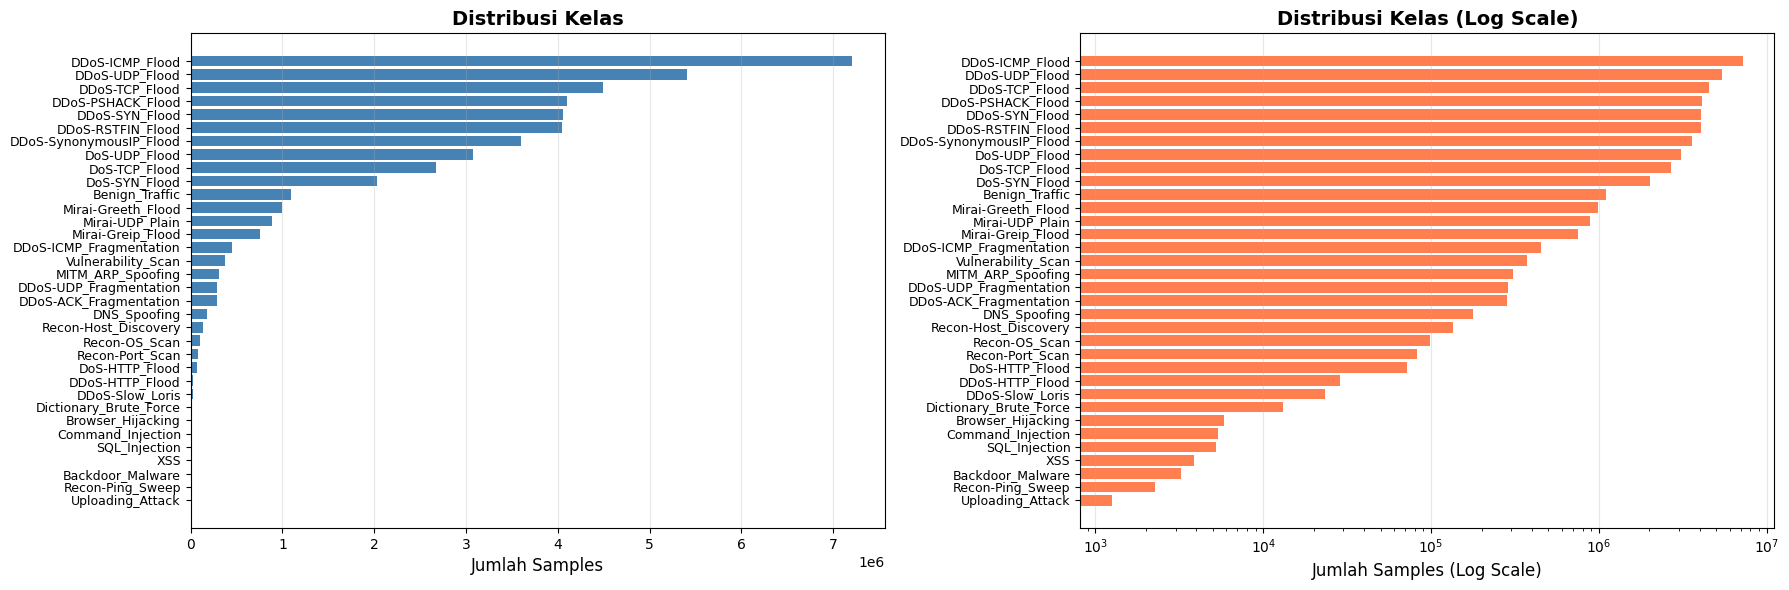

In [ ]:
label_col = 'Label'
class_counts = df[label_col].value_counts()

print(f"Jumlah kelas: {len(class_counts)}")
print(f"Total samples: {len(df):,}")

print("\nDistribusi kelas:")
for i, (class_name, count) in enumerate(class_counts.items(), 1):
    pct = count / len(df) * 100
    print(f"{i:2d}. {class_name:30s}: {count:8,} ({pct:5.2f}%)")

# Imbalance ratio
max_class = class_counts.max()
min_class = class_counts.min()
imbalance_ratio = max_class / min_class
print(f"\nImbalance Ratio: 1:{imbalance_ratio:.0f}")
print(f"Majority class: {class_counts.idxmax()} ({max_class:,})")
print(f"Minority class: {class_counts.idxmin()} ({min_class:,})")

# Visualisasi class distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart (sorted)
axes[0].barh(range(len(class_counts)), class_counts.values, color='steelblue')
axes[0].set_yticks(range(len(class_counts)))
axes[0].set_yticklabels(class_counts.index, fontsize=9)
axes[0].set_xlabel('Jumlah Samples', fontsize=12)
axes[0].set_title('Distribusi Kelas', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

# Log scale bar chart
axes[1].barh(range(len(class_counts)), class_counts.values, color='coral')
axes[1].set_yticks(range(len(class_counts)))
axes[1].set_yticklabels(class_counts.index, fontsize=9)
axes[1].set_xlabel('Jumlah Samples (Log Scale)', fontsize=12)
axes[1].set_xscale('log')
axes[1].set_title('Distribusi Kelas (Log Scale)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, '1_class_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

# Simpan distribusi kelas
class_dist_df = pd.DataFrame({
    'Class': class_counts.index,
    'Count': class_counts.values,
    'Percentage': (class_counts.values / len(df) * 100).round(4)
})
class_dist_df.to_csv(os.path.join(EDA_DIR, 'class_distribution.csv'), index=False)

**Statistik Fitur**

In [ ]:
# Pisahkan fitur numerik
features = df.drop(columns=[label_col])
numeric_features = features.select_dtypes(include=[np.number]).columns.tolist()

print(f"Jumlah fitur numerik: {len(numeric_features)}")

# Statistik deskriptif
desc_stats = features[numeric_features].describe()
print("\nStatistik deskriptif (5 fitur pertama):")
print(desc_stats.iloc[:, :5])

# Simpan semua statistik
desc_stats.T.to_csv(os.path.join(EDA_DIR, 'feature_statistics.csv'))

# Deteksi fitur dengan variance rendah
variance = features[numeric_features].var()
low_var_features = variance[variance < 0.01].index.tolist()

print(f"\nFitur dengan variance rendah (< 0.01): {len(low_var_features)}")
if len(low_var_features) > 0:
    print("Fitur:", low_var_features[:10], "..." if len(low_var_features) > 10 else "")

# Deteksi fitur dengan banyak nilai nol
zero_pct = (features[numeric_features] == 0).sum() / len(features) * 100
high_zero_features = zero_pct[zero_pct > 90].index.tolist()

print(f"\nFitur dengan >90% nilai nol: {len(high_zero_features)}")
if len(high_zero_features) > 0:
    print("Fitur:", high_zero_features[:10], "..." if len(high_zero_features) > 10 else "")

Jumlah fitur numerik: 39

Statistik deskriptif (5 fitur pertama):
       Header_Length  Protocol Type  Time_To_Live          Rate  \
count   4.677670e+07     46776700.0  4.677670e+07  4.677670e+07   
mean    1.376720e+01       9.050383  6.651937e+01           inf   
std     7.614555e+00       9.100497  2.071815e+01           NaN   
min     0.000000e+00            0.0  0.000000e+00  1.272070e-05   
25%     8.000000e+00            6.0  6.400000e+01  1.139354e+04   
50%     2.000000e+01            6.0  6.400000e+01  2.465497e+04   
75%     2.000000e+01           17.0  6.400000e+01  3.802288e+04   
max     6.000000e+01           47.0  2.550000e+02           inf   

       fin_flag_number  
count     4.677670e+07  
mean      8.737623e-02  
std       2.679854e-01  
min       0.000000e+00  
25%       0.000000e+00  
50%       0.000000e+00  
75%       0.000000e+00  
max       1.000000e+00  

Fitur dengan variance rendah (< 0.01): 10
Fitur: ['ece_flag_number', 'cwr_flag_number', 'DNS', 'Telnet',

**Analisis Korelasi Fitur**

Menghitung korelasi pada 50,000 samples...

Pasangan fitur dengan korelasi tinggi (>0.9): 15

10 Pasangan teratas:
  IPv <-> LLC: 1.000
  AVG <-> Tot size: 1.000
  ARP <-> IPv: -1.000
  ARP <-> LLC: -1.000
  fin_flag_number <-> fin_count: 0.999
  syn_flag_number <-> syn_count: 0.996
  rst_flag_number <-> rst_count: 0.995
  fin_count <-> rst_count: 0.983
  fin_flag_number <-> rst_count: 0.982
  rst_flag_number <-> fin_count: 0.977


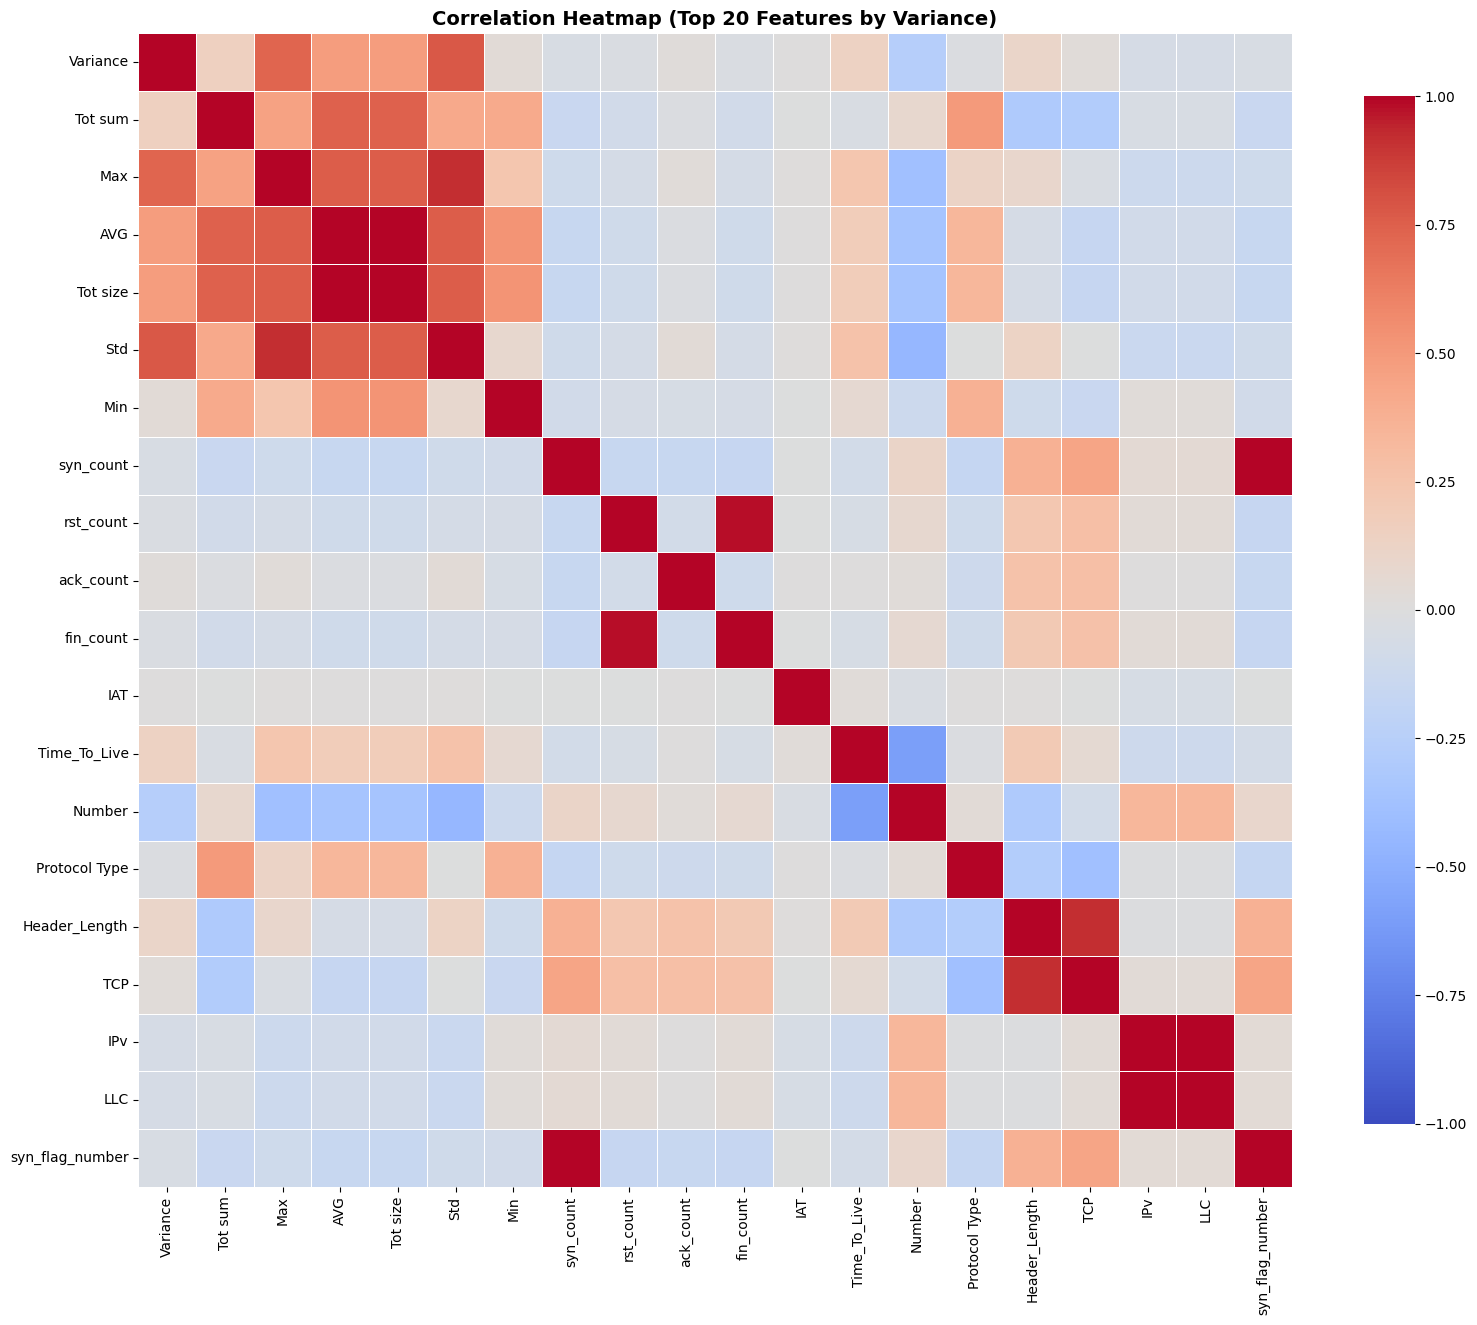

In [ ]:
# Hitung korelasi (ambil sample jika terlalu besar)
sample_size = min(50000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

print(f"Menghitung korelasi pada {sample_size:,} samples...")
correlation_matrix = df_sample[numeric_features].corr()

# Cari fitur yang sangat berkorelasi
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f"\nPasangan fitur dengan korelasi tinggi (>0.9): {len(high_corr_pairs)}")
if len(high_corr_pairs) > 0:
    print("\n10 Pasangan teratas:")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)[:10]:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")

# Visualisasi correlation matrix (subset)
fig, ax = plt.subplots(figsize=(16, 14))

# Ambil 20 fitur dengan variance tertinggi
top_features = variance.nlargest(20).index.tolist()
corr_subset = correlation_matrix.loc[top_features, top_features]

sns.heatmap(corr_subset, annot=False, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Correlation Heatmap (Top 20 Features by Variance)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, '2_correlation_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

**Analisis Distribusi Fitur**

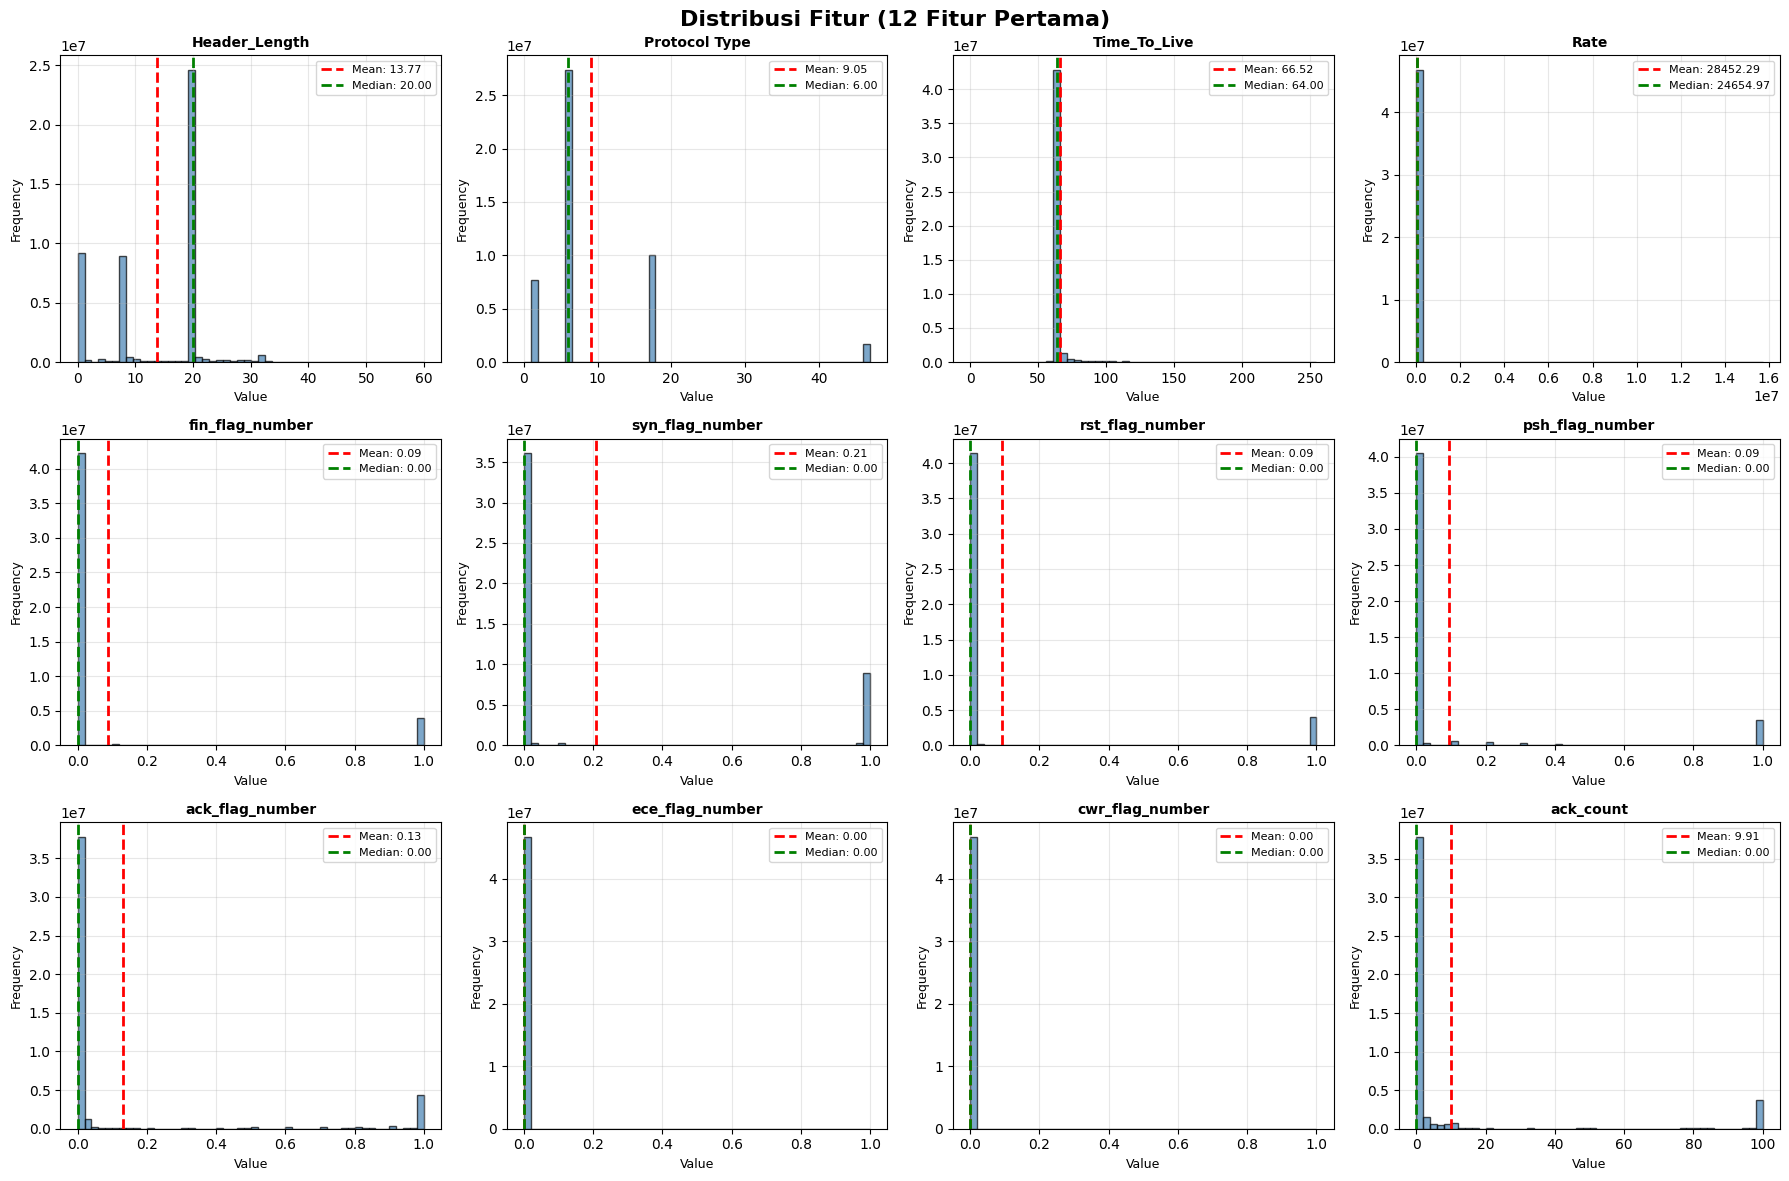

In [ ]:
# Analisis distribusi untuk 12 fitur pertama
n_features_to_plot = min(12, len(numeric_features))
features_to_plot = numeric_features[:n_features_to_plot]

fig, axes = plt.subplots(3, 4, figsize=(18, 12))
axes = axes.ravel()

for idx, feature in enumerate(features_to_plot):
    # Replace infinite values with NaN and then drop them, ensuring finite data for plotting
    data = df[feature].replace([np.inf, -np.inf], np.nan).dropna()

    # Skip plotting if all values became NaN after cleaning
    if data.empty:
        print(f"Skipping histogram for feature '{feature}' as it contains no finite values.")
        axes[idx].set_title(f"{feature} (No finite data)")
        axes[idx].text(0.5, 0.5, "No data to plot", horizontalalignment='center', verticalalignment='center', transform=axes[idx].transAxes)
        continue

    # Histogram
    axes[idx].hist(data, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(feature, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Value', fontsize=9)
    axes[idx].set_ylabel('Frequency', fontsize=9)
    axes[idx].grid(alpha=0.3)

    # Statistik
    mean_val = data.mean()
    median_val = data.median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.2f}')
    axes[idx].legend(fontsize=8)

plt.suptitle('Distribusi Fitur (12 Fitur Pertama)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, '3_feature_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

**Deteksi Outlier**

In [ ]:
# Deteksi outlier menggunakan IQR
outlier_summary = []

for feature in numeric_features[:20]:  # Cek 20 fitur pertama
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).sum()
    outlier_pct = outliers / len(df) * 100

    outlier_summary.append({
        'Feature': feature,
        'Outliers': outliers,
        'Percentage': round(outlier_pct, 2),
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Percentage', ascending=False)
print("Fitur dengan outlier terbanyak:")
print(outlier_df.head(10).to_string(index=False))

outlier_df.to_csv(os.path.join(EDA_DIR, 'outlier_analysis.csv'), index=False)

Fitur dengan outlier terbanyak:
        Feature  Outliers  Percentage   Q1    Q3  IQR
   Time_To_Live  12570222       26.87 64.0 64.00 0.00
syn_flag_number  10456311       22.35  0.0  0.01 0.01
      syn_count  10038780       21.46  0.0  1.00 1.00
ack_flag_number   8094435       17.30  0.0  0.01 0.01
psh_flag_number   8051585       17.21  0.0  0.00 0.00
      ack_count   7939746       16.97  0.0  1.00 1.00
          HTTPS   6734105       14.40  0.0  0.00 0.00
rst_flag_number   5859438       12.53  0.0  0.00 0.00
      rst_count   5859438       12.53  0.0  0.00 0.00
fin_flag_number   5348275       11.43  0.0  0.00 0.00


**Analisis Fitur Per-Kelas**

Kelas yang dianalisis:
  - DDoS-ICMP_Flood: 7,200,501 samples
  - DDoS-UDP_Fragmentation: 286,925 samples
  - Uploading_Attack: 1,252 samples


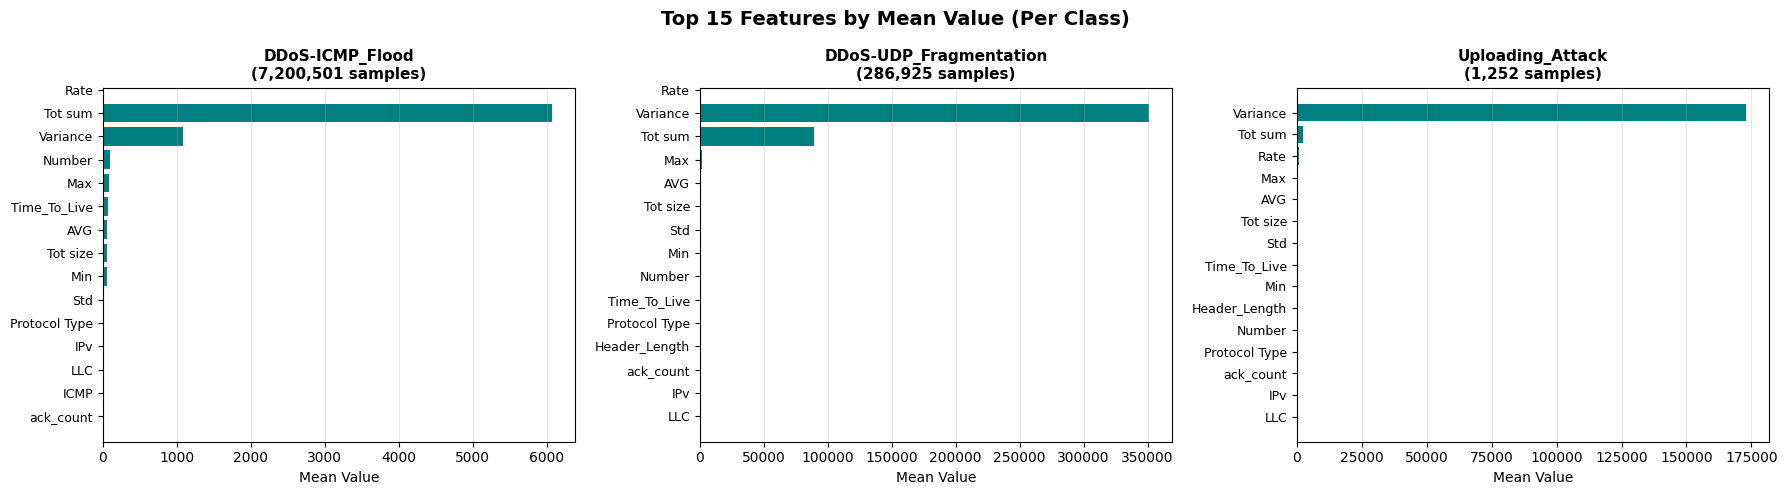

In [ ]:
# Analisis untuk 3 kelas (majority, minority, dan satu medium)
classes_to_analyze = [
    class_counts.idxmax(),  # Majority
    class_counts.index[len(class_counts)//2],  # Medium
    class_counts.idxmin(),  # Minority
]

print(f"Kelas yang dianalisis:")
for cls in classes_to_analyze:
    print(f"  - {cls}: {class_counts[cls]:,} samples")

# Hitung mean untuk setiap kelas
class_means = {}
for cls in classes_to_analyze:
    class_data = df[df[label_col] == cls][numeric_features]
    class_means[cls] = class_data.mean()

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, cls in enumerate(classes_to_analyze):
    # Ambil 15 fitur dengan nilai mean tertinggi
    top_features = class_means[cls].nlargest(15)

    axes[idx].barh(range(len(top_features)), top_features.values, color='teal')
    axes[idx].set_yticks(range(len(top_features)))
    axes[idx].set_yticklabels(top_features.index, fontsize=9)
    axes[idx].set_xlabel('Mean Value', fontsize=10)
    axes[idx].set_title(f'{cls}\n({class_counts[cls]:,} samples)',
                        fontsize=11, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].invert_yaxis()

plt.suptitle('Top 15 Features by Mean Value (Per Class)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, '4_per_class_feature_means.png'), dpi=300, bbox_inches='tight')
plt.show()

**Analisis PCA (Principal Component Analysis)**

Untuk pengurangan dimensi

Melakukan PCA pada 10,000 samples...

Jumlah komponen untuk 95% variance: 19


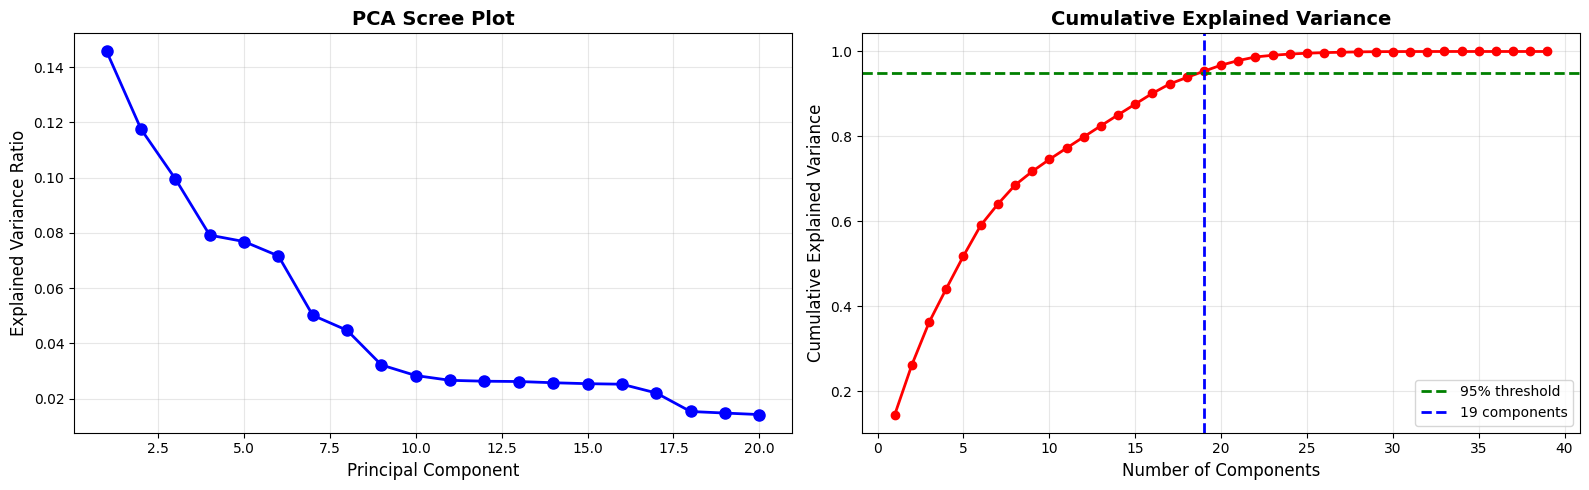


Variance explained by first 10 components: 0.7460


In [ ]:
# Gunakan sample untuk efisiensi
sample_size = 10000
df_pca_sample = df.sample(n=sample_size, random_state=42)

print(f"Melakukan PCA pada {sample_size:,} samples...")

# Normalisasi data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_pca_sample[numeric_features])

# PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance
explained_var = pca.explained_variance_ratio_
cumsum_var = np.cumsum(explained_var)

# Cari jumlah komponen untuk 95% variance
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
print(f"\nJumlah komponen untuk 95% variance: {n_components_95}")

# Visualisasi
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot
axes[0].plot(range(1, min(21, len(explained_var)+1)),
             explained_var[:20], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('PCA Scree Plot', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, min(51, len(cumsum_var)+1)),
             cumsum_var[:50], 'ro-', linewidth=2, markersize=6)
axes[1].axhline(y=0.95, color='green', linestyle='--', linewidth=2, label='95% threshold')
axes[1].axvline(x=n_components_95, color='blue', linestyle='--', linewidth=2,
                label=f'{n_components_95} components')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, '5_pca_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVariance explained by first 10 components: {cumsum_var[9]:.4f}")

**Ringkasan EDA**

In [ ]:
summary = {
    'Dataset Info': {
        'Total Samples': len(df),
        'Total Features': len(numeric_features),
        'Total Classes': len(class_counts),
        'Imbalance Ratio': f'1:{imbalance_ratio:.0f}',
        'Duplicates': f'{n_duplicates:,} ({n_duplicates/len(df)*100:.2f}%)'
    },
    'Feature Analysis': {
        'Low Variance Features (< 0.01)': len(low_var_features),
        'High Zero Features (> 90%)': len(high_zero_features),
        'High Correlation Pairs (> 0.9)': len(high_corr_pairs)
    },
    'PCA': {
        'Components for 95% Variance': int(n_components_95), # Convert to standard int
        'Variance by 10 Components': f'{cumsum_var[9]:.2%}'
    },
    'Recommendations': []
}

# Rekomendasi berdasarkan hasil EDA
if n_duplicates > len(df) * 0.1:
    summary['Recommendations'].append('HAPUS duplicate rows (>10% dari data)')

if len(low_var_features) > 0:
    summary['Recommendations'].append(f'Pertimbangkan hapus {len(low_var_features)} fitur dengan variance rendah')

if len(high_corr_pairs) > 10:
    summary['Recommendations'].append(f'Ada {len(high_corr_pairs)} pasangan fitur berkorelasi tinggi, pertimbangkan feature selection')

if imbalance_ratio > 1000:
    summary['Recommendations'].append('Imbalance ratio sangat tinggi (>1:1000), WAJIB pakai data augmentation')

print("\n### INFORMASI DATASET ###")
for key, value in summary['Dataset Info'].items():
    print(f"{key:25s}: {value}")

print("\n### ANALISIS FITUR ###")
for key, value in summary['Feature Analysis'].items():
    print(f"{key:40s}: {value}")

print("\n### PCA ###")
for key, value in summary['PCA'].items():
    print(f"{key:35s}: {value}")

print("\n### REKOMENDASI ###")
if summary['Recommendations']:
    for i, rec in enumerate(summary['Recommendations'], 1):
        print(f"{i}. {rec}")
else:
    print("Data dalam kondisi baik, siap untuk preprocessing")

# Simpan summary
import json
with open(os.path.join(EDA_DIR, 'eda_summary.json'), 'w') as f:
    json.dump(summary, f, indent=4)

print("LANGKAH (EDA) SELESAI!")

print(f"\nSemua hasil tersimpan di: {EDA_DIR}")
print("\nFile yang tersimpan:")
print("  - 1_class_distribution.png")
print("  - 2_correlation_heatmap.png")
print("  - 3_feature_distributions.png")
print("  - 4_per_class_feature_means.png")
print("  - 5_pca_analysis.png")
print("  - class_distribution.csv")
print("  - feature_statistics.csv")
print("  - outlier_analysis.csv")
print("  - eda_summary.json")
print("\nLangkah selanjutnya: Lanjut ke Phase 1 (Preprocessing)")


### INFORMASI DATASET ###
Total Samples            : 46776700
Total Features           : 39
Total Classes            : 34
Imbalance Ratio          : 1:5751
Duplicates               : 25,377,677 (54.25%)

### ANALISIS FITUR ###
Low Variance Features (< 0.01)          : 10
High Zero Features (> 90%)              : 11
High Correlation Pairs (> 0.9)          : 15

### PCA ###
Components for 95% Variance        : 19
Variance by 10 Components          : 74.60%

### REKOMENDASI ###
1. HAPUS duplicate rows (>10% dari data)
2. Pertimbangkan hapus 10 fitur dengan variance rendah
3. Ada 15 pasangan fitur berkorelasi tinggi, pertimbangkan feature selection
4. Imbalance ratio sangat tinggi (>1:1000), WAJIB pakai data augmentation
LANGKAH (EDA) SELESAI!

Semua hasil tersimpan di: /content/drive/My Drive/EDA_Results/

File yang tersimpan:
  - 1_class_distribution.png
  - 2_correlation_heatmap.png
  - 3_feature_distributions.png
  - 4_per_class_feature_means.png
  - 5_pca_analysis.png
  - class_distr

# **Langkah 1: Pre-Processing Data**

###**1.1 Load Dataset**

In [ ]:
df = pd.read_parquet(DATASET_PATH)

print(f"Dataset berhasil diload!")
print(f"Total rows: {df.shape[0]:,}")
print(f"Total columns: {df.shape[1]}")
print(f"Penggunaan Memori: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset berhasil diload!
Total rows: 46,776,700
Total columns: 40
Penggunaan Memori: 10599.42 MB


###**1.2 Inspeksi Awal**

1.2.1 Cek Kolom dan Tipe Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46776700 entries, 0 to 3845
Data columns (total 40 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Header_Length    float32
 1   Protocol Type    Int32  
 2   Time_To_Live     float32
 3   Rate             float32
 4   fin_flag_number  float32
 5   syn_flag_number  float32
 6   rst_flag_number  float32
 7   psh_flag_number  float32
 8   ack_flag_number  float32
 9   ece_flag_number  float32
 10  cwr_flag_number  float32
 11  ack_count        Int32  
 12  syn_count        Int32  
 13  fin_count        Int32  
 14  rst_count        Int32  
 15  HTTP             float32
 16  HTTPS            float32
 17  DNS              float32
 18  Telnet           float32
 19  SMTP             float32
 20  SSH              float32
 21  IRC              float32
 22  TCP              float32
 23  UDP              float32
 24  DHCP             float32
 25  ARP              float32
 26  ICMP             float32
 27  IGMP             fl

1.2.2 Distribusi Kelas (34 Kelas Individual)

In [ ]:
print(f"Distribusi Kelas (34 Serangan Individual):")
class_counts = df[label_col].value_counts()
print(class_counts)

Distribusi Kelas (34 Serangan Individual):
Label
DDoS-ICMP_Flood            7200501
DDoS-UDP_Flood             5412231
DDoS-TCP_Flood             4497649
DDoS-PSHACK_Flood          4094772
DDoS-SYN_Flood             4059179
DDoS-RSTFIN_Flood          4045279
DDoS-SynonymousIP_Flood    3598133
DoS-UDP_Flood              3072993
DoS-TCP_Flood              2671430
DoS-SYN_Flood              2028836
Benign_Traffic             1098191
Mirai-Greeth_Flood          991834
Mirai-UDP_Plain             890574
Mirai-Greip_Flood           751646
DDoS-ICMP_Fragmentation     452490
Vulnerability_Scan          373351
MITM_ARP_Spoofing           307560
DDoS-UDP_Fragmentation      286925
DDoS-ACK_Fragmentation      285075
DNS_Spoofing                178898
Recon-Host_Discovery        134378
Recon-OS_Scan                98259
Recon-Port_Scan              82284
DoS-HTTP_Flood               71861
DDoS-HTTP_Flood              28790
DDoS-Slow_Loris              23426
Dictionary_Brute_Force       13064
Browse

In [ ]:
print(f"Persentase Kelas:")
class_pct = (class_counts / len(df) * 100).round(4)
print(class_pct)

Persentase Kelas:
Label
DDoS-ICMP_Flood            15.3933
DDoS-UDP_Flood             11.5704
DDoS-TCP_Flood              9.6151
DDoS-PSHACK_Flood           8.7539
DDoS-SYN_Flood              8.6778
DDoS-RSTFIN_Flood           8.6481
DDoS-SynonymousIP_Flood     7.6921
DoS-UDP_Flood               6.5695
DoS-TCP_Flood               5.7110
DoS-SYN_Flood               4.3373
Benign_Traffic              2.3477
Mirai-Greeth_Flood          2.1204
Mirai-UDP_Plain             1.9039
Mirai-Greip_Flood           1.6069
DDoS-ICMP_Fragmentation     0.9673
Vulnerability_Scan          0.7982
MITM_ARP_Spoofing           0.6575
DDoS-UDP_Fragmentation      0.6134
DDoS-ACK_Fragmentation      0.6094
DNS_Spoofing                0.3825
Recon-Host_Discovery        0.2873
Recon-OS_Scan               0.2101
Recon-Port_Scan             0.1759
DoS-HTTP_Flood              0.1536
DDoS-HTTP_Flood             0.0615
DDoS-Slow_Loris             0.0501
Dictionary_Brute_Force      0.0279
Browser_Hijacking           0.0

1.2.3 Menghitung Imbalance Ratio

In [ ]:
min_class = class_counts.min()
max_class = class_counts.max()
imbalance_ratio = max_class / min_class

print(f"Imbalance Ratio: 1:{imbalance_ratio:.0f}")
print(f"Kelas Mayoritas: {class_counts.idxmax()} ({max_class:,} samples)")
print(f"Kelas Minoritas: {class_counts.idxmin()} ({min_class:,} samples)")

Imbalance Ratio: 1:5751
Kelas Mayoritas: DDoS-ICMP_Flood (7,200,501 samples)
Kelas Minoritas: Uploading_Attack (1,252 samples)


1.2.4 Menyimpan Distribusi Kelas

In [ ]:
class_dist_dict = {
    'counts': {str(k): int(v) for k, v in class_counts.to_dict().items()},
    'percentages': {str(k): float(v) for k, v in class_pct.to_dict().items()},
    'imbalance_ratio': float(imbalance_ratio),
    'majority_class': str(class_counts.idxmax()),
    'minority_class': str(class_counts.idxmin())
}

with open(os.path.join(RESULTS_DIR, 'class_distribution.json'), 'w') as f:
    json.dump(class_dist_dict, f, indent=4)

print("Distribusi kelas tersimpan!")

Distribusi kelas tersimpan!


###**1.3 Cek Kualitas Data & Cleaning Data**

1.3.1 Missing Values

In [ ]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(4)
missing_df = pd.DataFrame({
    'Jumlah_Missing': missing,
    'Persentase_Missing': missing_pct
})
missing_df = missing_df[missing_df['Jumlah_Missing'] > 0].sort_values('Jumlah_Missing', ascending=False)

if len(missing_df) > 0:
    print("Kolom dengan missing values:")
    print(missing_df)

    # Handle missing values
    print("\nMenangani missing values...")
    for col in missing_df.index:
        if missing_df.loc[col, 'Persentase_Missing'] < 1.0:
            df = df.dropna(subset=[col])
            print(f"   Baris dengan missing values di '{col}' dihapus")
        else:
            if df[col].dtype in ['float32', 'float64', 'int32', 'int64', 'Int32']:
                df[col].fillna(df[col].median(), inplace=True)
                print(f"   Missing values di '{col}' diisi dengan median")
            else:
                df[col].fillna(df[col].mode()[0], inplace=True)
                print(f"   Missing values di '{col}' diisi dengan modus")
else:
    print("\nTidak ada missing values!")

Kolom dengan missing values:
                 Jumlah_Missing  Persentase_Missing
Variance                    705              0.0015
Std                         704              0.0015
Tot size                      3              0.0000
Number                        3              0.0000
IAT                           3              0.0000
AVG                           2              0.0000
fin_flag_number               1              0.0000
rst_flag_number               1              0.0000
syn_flag_number               1              0.0000
psh_flag_number               1              0.0000
ack_flag_number               1              0.0000
HTTP                          1              0.0000
HTTPS                         1              0.0000
ece_flag_number               1              0.0000
cwr_flag_number               1              0.0000
ack_count                     1              0.0000
syn_count                     1              0.0000
fin_count                     1    

1.3.2 Infinite Values

In [ ]:
# Pilih kolom numerik saja
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

inf_counts = {}
for col in numeric_cols:
    inf_count = np.isinf(df[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count

if inf_counts:
    print("Kolom dengan nilai infinite:")
    for col, count in inf_counts.items():
        print(f"   {col}: {count}")

    print("\nMengganti nilai infinite dengan max/min kolom...")
    for col in inf_counts.keys():
        # Mengganti nilai np.inf dengan nilai maksimum yang valid di kolom tersebut
        df[col] = df[col].replace([np.inf], df[col][~np.isinf(df[col])].max())
        # Mengganti nilai -np.inf dengan nilai minimum yang valid di kolom tersebut
        df[col] = df[col].replace([-np.inf], df[col][~np.isinf(df[col])].min())
        print(f"   Nilai infinite di '{col}' diperbaiki")
else:
    print("\nTidak ada nilai infinite!")

Kolom dengan nilai infinite:
   Rate: 335

Mengganti nilai infinite dengan max/min kolom...


/tmp/ipython-input-1584163219.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace([np.inf], df[col][~np.isinf(df[col])].max(), inplace=True)


   Nilai infinite di 'Rate' diperbaiki


/tmp/ipython-input-1584163219.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace([-np.inf], df[col][~np.isinf(df[col])].min(), inplace=True)


1.3.3 Duplicate Values

In [ ]:
print("Duplicate Rows:")
n_duplicates = df.duplicated().sum()
print(f" Total duplicates: {n_duplicates:,} ({n_duplicates/len(df)*100:.2f}%)")

Duplicate Rows:
 Total duplicates: 25,377,391 (54.25%)


In [ ]:
# Hapus semua baris yang identik/duplikat
df = df.drop_duplicates()

# Cek kembali bentuk data setelah duplikasi dihapus
print(f"Jumlah data setelah hapus duplikat: {df.shape}")

Jumlah data setelah hapus duplikat: (21398604, 40)


#####Visualisasi Hasil Hapus Duplikat

In [ ]:
DATASET_PATH = '/content/drive/My Drive/Dataset/dataset_final_100_percent_32bit.parquet'
PROCESSED_DIR = '/content/drive/My Drive/Baseline/Processed_Data/'
EDA_DIR = '/content/drive/My Drive/EDA_Results/'

# Load dataset BEFORE duplicate removal
print("Memuat dataset BEFORE duplicate removal...")
df_before = pd.read_parquet(DATASET_PATH)

# Load dataset AFTER duplicate removal (dari preprocessing)
print("Memuat dataset AFTER duplicate removal...")

# Gunakan data dari hasil preprocessing
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))

with open(os.path.join(PROCESSED_DIR, 'label_encoder.pkl'), 'rb') as f:
    label_encoder = pickle.load(f)

# Rekonstruksi distribusi after duplicate removal
y_all = np.concatenate([y_train, y_test])
class_names = label_encoder.classes_

# Convert encoded labels ke class names
y_decoded = [label_encoder.inverse_transform([label])[0] for label in y_all]
class_counts_after = pd.Series(Counter(y_decoded))

# Get distribution before
label_col = 'Label'
class_counts_before = df_before[label_col].value_counts()

print(f"\nBefore: {len(df_before):,} samples")
print(f"After: {len(y_all):,} samples")
print(f"Removed: {len(df_before) - len(y_all):,} duplicates ({(len(df_before) - len(y_all))/len(df_before)*100:.2f}%)")

Memuat dataset BEFORE duplicate removal...
Memuat dataset AFTER duplicate removal...

Before: 46,776,700 samples
After: 21,398,604 samples
Removed: 25,378,096 duplicates (54.25%)


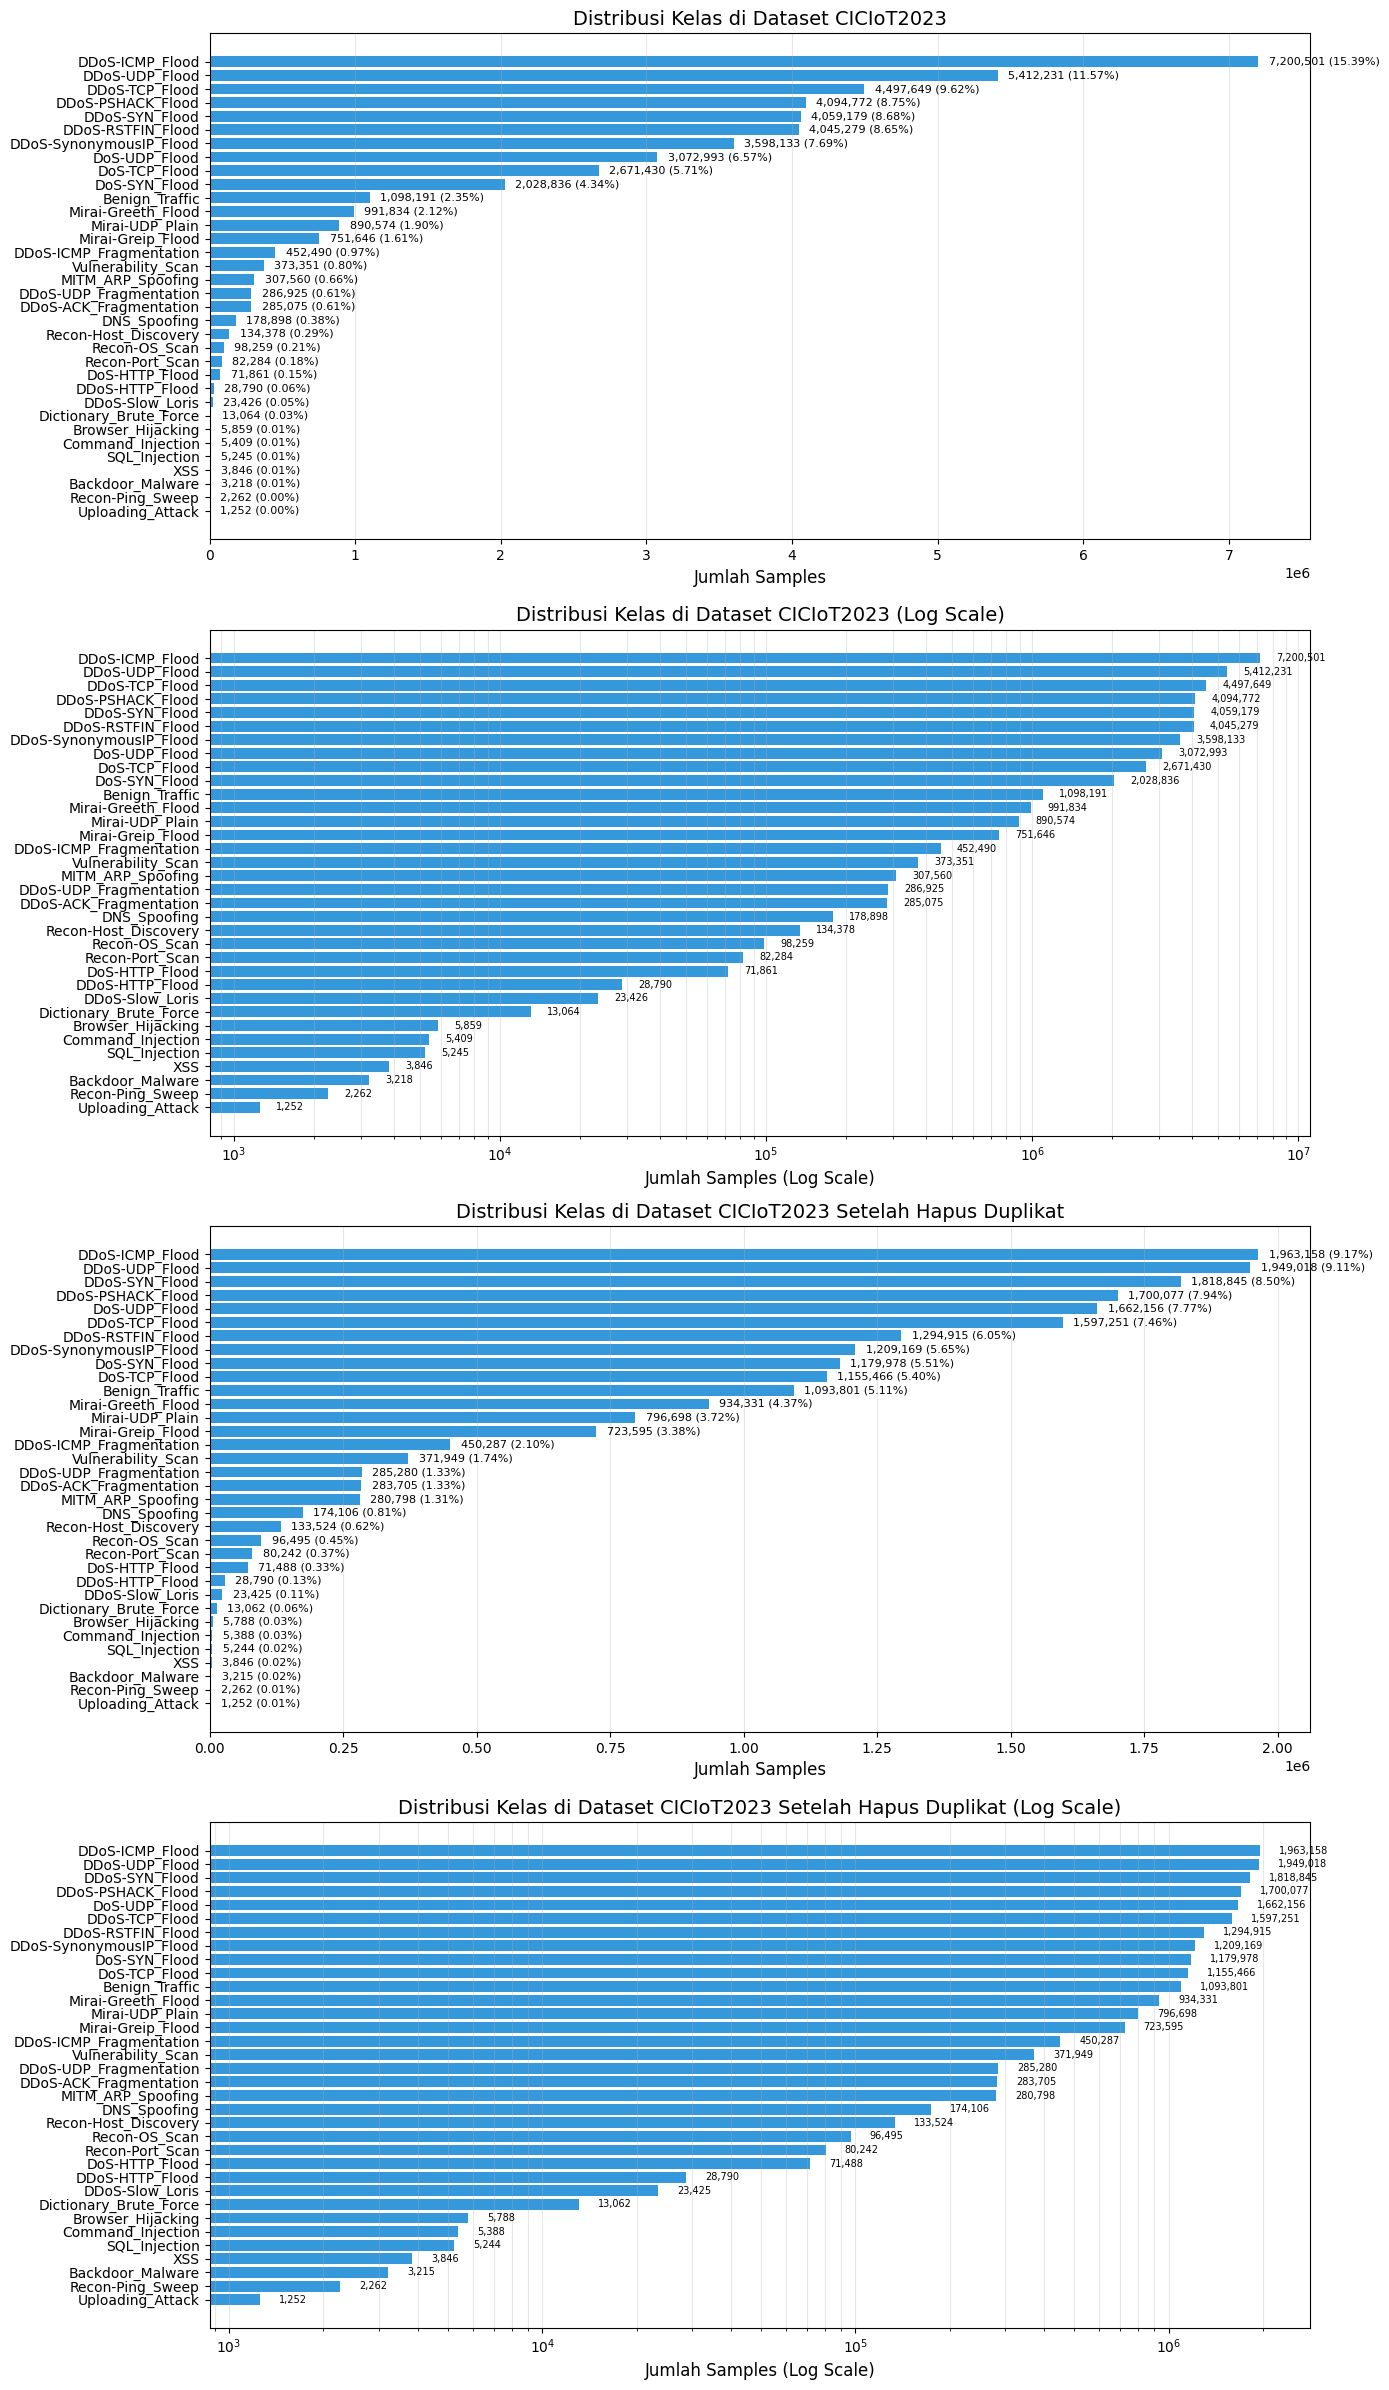


Visualisasi distribusi kelas (revised) tersimpan!


In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(14, 24))

# Explicitly sort class_counts_after for consistent plotting as requested by the user
class_counts_after = class_counts_after.sort_values(ascending=False)

# ========== SUBPLOT 1: BEFORE (Sorted) ==========
ax1 = axes[0]
bars1 = ax1.barh(range(len(class_counts_before)), class_counts_before.values, color='#3498db')
ax1.set_yticks(range(len(class_counts_before)))
ax1.set_yticklabels(class_counts_before.index, fontsize=10)
ax1.set_xlabel('Jumlah Samples', fontsize=12)
ax1.set_title('Distribusi Kelas di Dataset CICIoT2023',
              fontsize=14)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Tambahkan angka di setiap bar
for i, (bar, count) in enumerate(zip(bars1, class_counts_before.values)):
    width = bar.get_width()
    percentage = count / len(df_before) * 100
    ax1.text(width + max(class_counts_before.values)*0.01,
            bar.get_y() + bar.get_height()/2,
            f'{count:,} ({percentage:.2f}%)',
            va='center', fontsize=8)

# ========== NEW SUBPLOT 2: BEFORE (Log Scale) ==========
ax2 = axes[1]
bars_before_log = ax2.barh(range(len(class_counts_before)), class_counts_before.values, color='#3498db')
ax2.set_yticks(range(len(class_counts_before)))
ax2.set_yticklabels(class_counts_before.index, fontsize=10)
ax2.set_xlabel('Jumlah Samples (Log Scale)', fontsize=12)
ax2.set_xscale('log')
ax2.set_title('Distribusi Kelas di Dataset CICIoT2023 (Log Scale)',
              fontsize=14)
ax2.grid(axis='x', alpha=0.3, which='both')
ax2.invert_yaxis()
# Tambahkan angka di setiap bar (log scale)
for i, (bar, count) in enumerate(zip(bars_before_log, class_counts_before.values)):
    width = bar.get_width()
    ax2.text(width * 1.15,
            bar.get_y() + bar.get_height()/2,
            f'{count:,}',
            va='center', fontsize=7)


# ========== SUBPLOT 3: AFTER (Sorted) ==========
ax3 = axes[2]
bars2 = ax3.barh(range(len(class_counts_after)), class_counts_after.values, color='#3498db')
ax3.set_yticks(range(len(class_counts_after)))
ax3.set_yticklabels(class_counts_after.index, fontsize=10)
ax3.set_xlabel('Jumlah Samples', fontsize=12)
ax3.set_title('Distribusi Kelas di Dataset CICIoT2023 Setelah Hapus Duplikat',
              fontsize=14)
ax3.grid(axis='x', alpha=0.3)
ax3.invert_yaxis()

# Tambahkan angka di setiap bar
for i, (bar, count) in enumerate(zip(bars2, class_counts_after.values)):
    width = bar.get_width()
    percentage = count / len(y_all) * 100
    ax3.text(width + max(class_counts_after.values)*0.01,
            bar.get_y() + bar.get_height()/2,
            f'{count:,} ({percentage:.2f}%)',
            va='center', fontsize=8)

# ========== SUBPLOT 4: AFTER (Log Scale) ==========
ax4 = axes[3]
bars3 = ax4.barh(range(len(class_counts_after)), class_counts_after.values, color='#3498db')
ax4.set_yticks(range(len(class_counts_after)))
ax4.set_yticklabels(class_counts_after.index, fontsize=10)
ax4.set_xlabel('Jumlah Samples (Log Scale)', fontsize=12)
ax4.set_xscale('log')
ax4.set_title('Distribusi Kelas di Dataset CICIoT2023 Setelah Hapus Duplikat (Log Scale)',
              fontsize=14)
ax4.grid(axis='x', alpha=0.3, which='both')
ax4.invert_yaxis()

# Tambahkan angka di setiap bar (log scale)
for i, (bar, count) in enumerate(zip(bars3, class_counts_after.values)):
    width = bar.get_width()
    ax4.text(width * 1.15,
            bar.get_y() + bar.get_height()/2,
            f'{count:,}',
            va='center', fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, '1_class_distribution_revised.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi distribusi kelas (revised) tersimpan!")

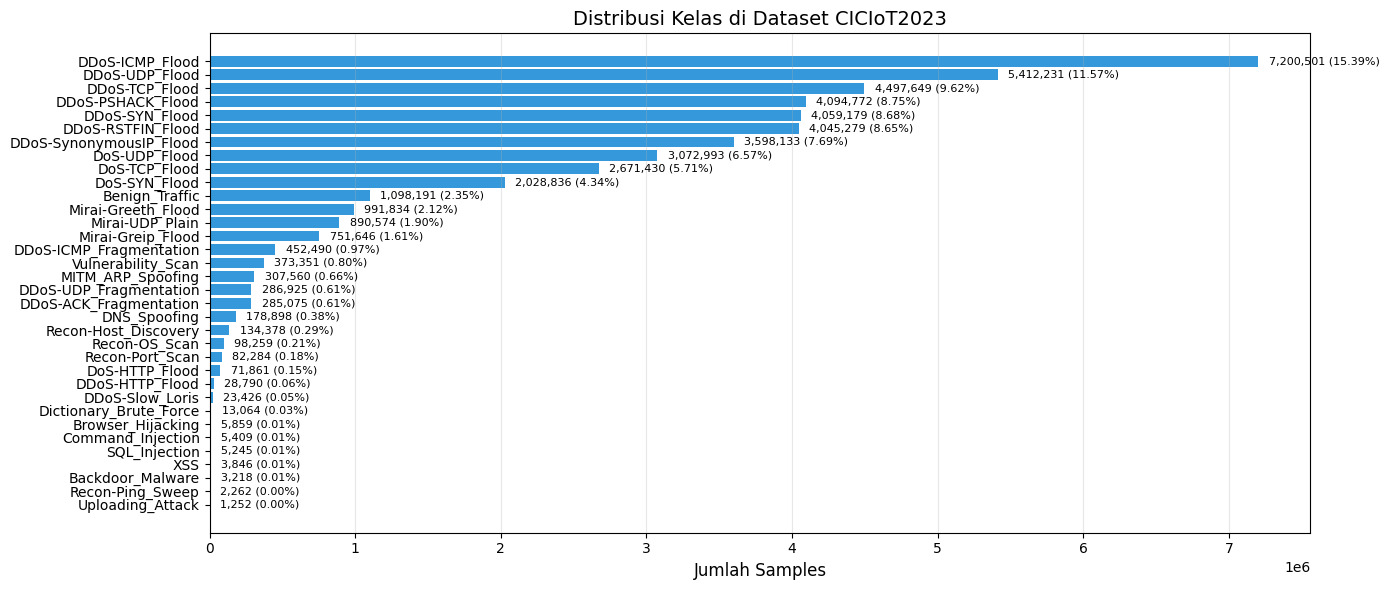


Visualisasi distribusi kelas tersimpan!


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# ========== PLOT 1: BEFORE (Sorted) ==========
bars = ax.barh(range(len(class_counts_before)), class_counts_before.values, color='#3498db')
ax.set_yticks(range(len(class_counts_before)))
ax.set_yticklabels(class_counts_before.index, fontsize=10)
ax.set_xlabel('Jumlah Samples', fontsize=12)
ax.set_title('Distribusi Kelas di Dataset CICIoT2023',
              fontsize=14)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# Tambahkan angka di setiap bar
for i, (bar, count) in enumerate(zip(bars, class_counts_before.values)):
    width = bar.get_width()
    percentage = count / len(df_before) * 100
    ax.text(width + max(class_counts_before.values)*0.01,
            bar.get_y() + bar.get_height()/2,
            f'{count:,} ({percentage:.2f}%)',
            va='center', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, 'class_distribution_before.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi distribusi kelas tersimpan!")

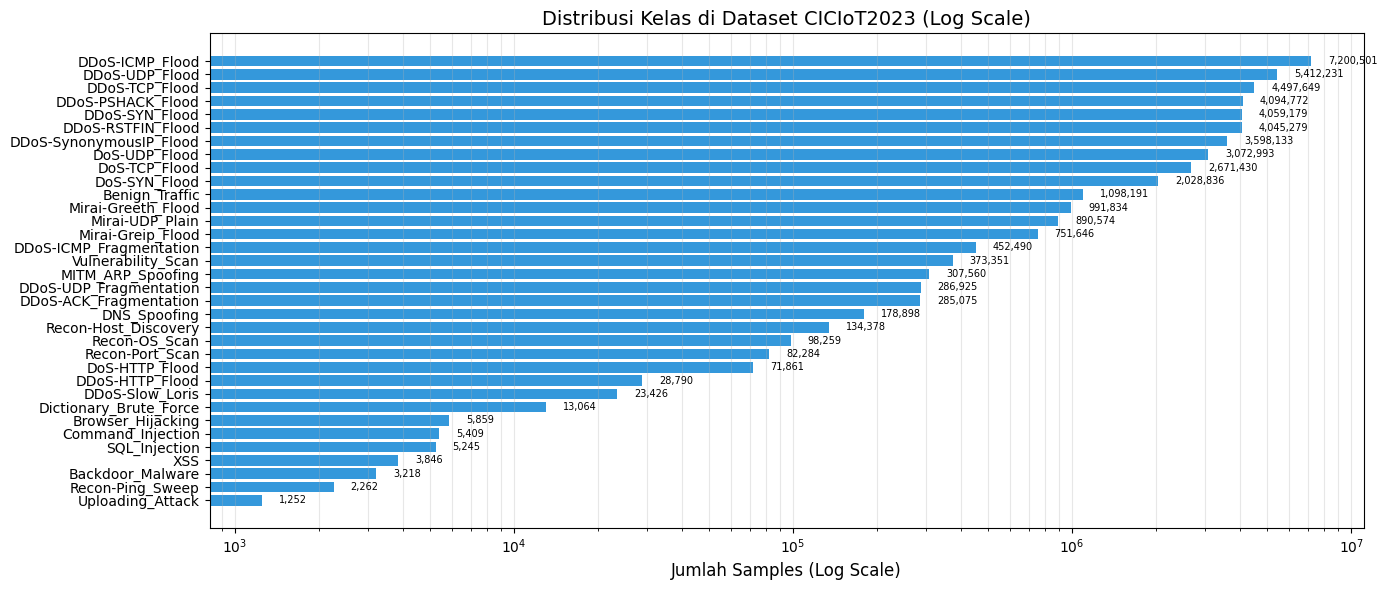


Visualisasi distribusi kelas (Log Scale) tersimpan!


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6)) # Create a single subplot

# ========== PLOT 2: BEFORE (Log Scale) ==========
bars_before_log = ax.barh(range(len(class_counts_before)), class_counts_before.values, color='#3498db')
ax.set_yticks(range(len(class_counts_before)))
ax.set_yticklabels(class_counts_before.index, fontsize=10)
ax.set_xlabel('Jumlah Samples (Log Scale)', fontsize=12)
ax.set_xscale('log')
ax.set_title('Distribusi Kelas di Dataset CICIoT2023 (Log Scale)',
              fontsize=14)
ax.grid(axis='x', alpha=0.3, which='both')
ax.invert_yaxis()
# Tambahkan angka di setiap bar (log scale)
for i, (bar, count) in enumerate(zip(bars_before_log, class_counts_before.values)):
    width = bar.get_width()
    ax.text(width * 1.15,
            bar.get_y() + bar.get_height()/2,
            f'{count:,}',
            va='center', fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, 'class_distribution_before_log_scale.png'), # Change filename for clarity
            dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi distribusi kelas (Log Scale) tersimpan!")

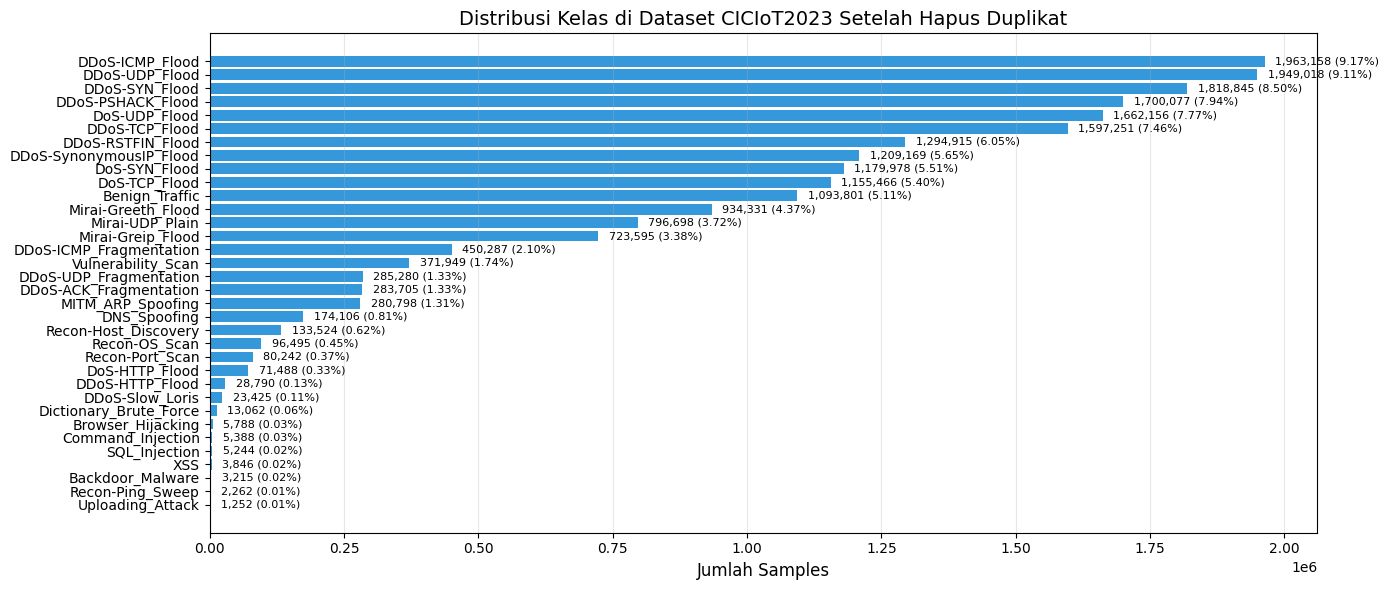


Visualisasi distribusi kelas setelah hapus duplikat tersimpan!


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6)) # Create a single subplot

# ========== SUBPLOT 3: AFTER (Sorted) ==========

bars = ax.barh(range(len(class_counts_after)), class_counts_after.values, color='#3498db')
ax.set_yticks(range(len(class_counts_after)))
ax.set_yticklabels(class_counts_after.index, fontsize=10)
ax.set_xlabel('Jumlah Samples', fontsize=12)
ax.set_title('Distribusi Kelas di Dataset CICIoT2023 Setelah Hapus Duplikat',
              fontsize=14)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# Tambahkan angka di setiap bar
for i, (bar, count) in enumerate(zip(bars2, class_counts_after.values)):
    width = bar.get_width()
    percentage = count / len(y_all) * 100
    ax.text(width + max(class_counts_after.values)*0.01,
            bar.get_y() + bar.get_height()/2,
            f'{count:,} ({percentage:.2f}%)',
            va='center', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, 'class_distribution_after.png'), # Change filename for clarity
            dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi distribusi kelas setelah hapus duplikat tersimpan!")

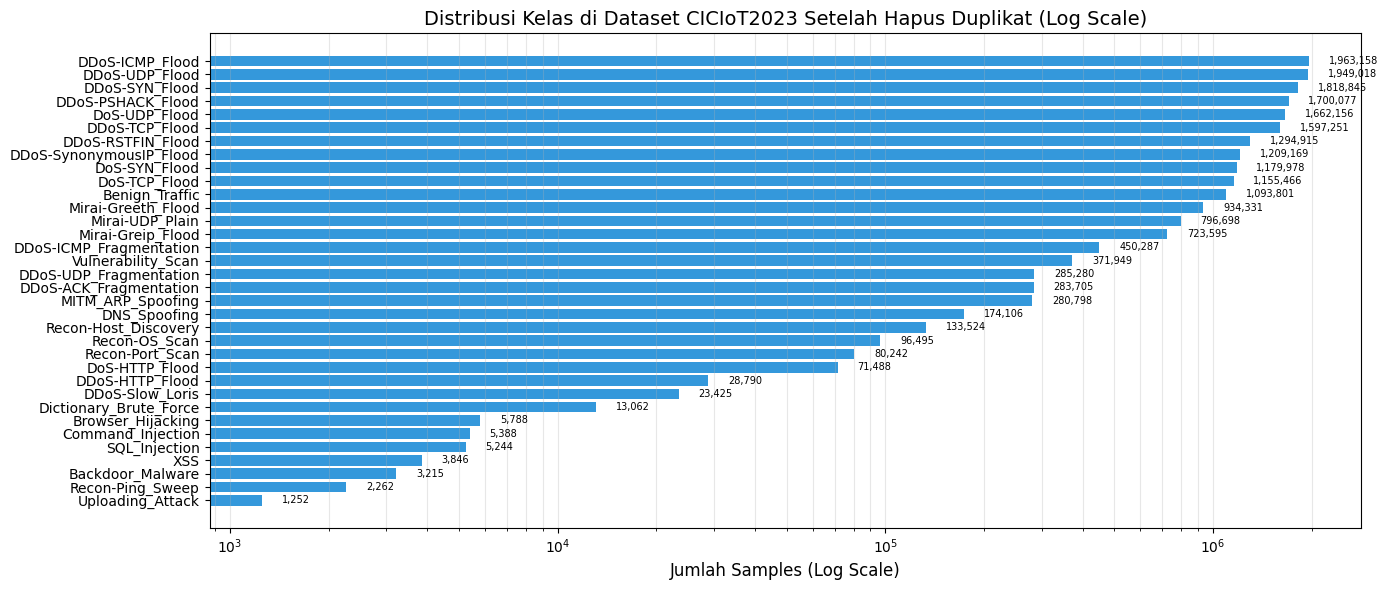


Visualisasi distribusi kelas (Log Scale) setelah hapus duplikat tersimpan!


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6)) # Create a single subplot

# ========== PLOT 4: AFTER (Log Scale) ==========

bars = ax.barh(range(len(class_counts_after)), class_counts_after.values, color='#3498db')
ax.set_yticks(range(len(class_counts_after)))
ax.set_yticklabels(class_counts_after.index, fontsize=10)
ax.set_xlabel('Jumlah Samples (Log Scale)', fontsize=12)
ax.set_xscale('log')
ax.set_title('Distribusi Kelas di Dataset CICIoT2023 Setelah Hapus Duplikat (Log Scale)',
              fontsize=14)
ax.grid(axis='x', alpha=0.3, which='both')
ax.invert_yaxis()

# Tambahkan angka di setiap bar (log scale)
for i, (bar, count) in enumerate(zip(bars3, class_counts_after.values)):
    width = bar.get_width()
    ax.text(width * 1.15,
            bar.get_y() + bar.get_height()/2,
            f'{count:,}',
            va='center', fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(EDA_DIR, 'class_distribution_after_log_scale.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualisasi distribusi kelas (Log Scale) setelah hapus duplikat tersimpan!")

In [ ]:
comparison_data = []
for class_name in class_counts_before.index:
    before_count = class_counts_before[class_name]
    after_count = class_counts_after.get(class_name, 0)
    removed = before_count - after_count
    removed_pct = (removed / before_count * 100) if before_count > 0 else 0

    comparison_data.append({
        'Class': class_name,
        'Before': before_count,
        'After': after_count,
        'Removed': removed,
        'Removed %': round(removed_pct, 2)
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Removed', ascending=False)

print("\nTop 17 kelas dengan duplikat terbanyak:")
print(comparison_df.head(17).to_string(index=False))

# Simpan comparison
comparison_df.to_csv(os.path.join(EDA_DIR, 'class_comparison_before_after.csv'), index=False)

print(f"\nTotal duplicates removed: {(len(df_before) - len(y_all)):,}")
print(f"Percentage: {(len(df_before) - len(y_all))/len(df_before)*100:.2f}%")


Top 17 kelas dengan duplikat terbanyak:
                  Class  Before   After  Removed  Removed %
        DDoS-ICMP_Flood 7200501 1963158  5237343      72.74
         DDoS-UDP_Flood 5412231 1949018  3463213      63.99
         DDoS-TCP_Flood 4497649 1597251  2900398      64.49
      DDoS-RSTFIN_Flood 4045279 1294915  2750364      67.99
      DDoS-PSHACK_Flood 4094772 1700077  2394695      58.48
DDoS-SynonymousIP_Flood 3598133 1209169  2388964      66.39
         DDoS-SYN_Flood 4059179 1818845  2240334      55.19
          DoS-TCP_Flood 2671430 1155466  1515964      56.75
          DoS-UDP_Flood 3072993 1662156  1410837      45.91
          DoS-SYN_Flood 2028836 1179978   848858      41.84
        Mirai-UDP_Plain  890574  796698    93876      10.54
     Mirai-Greeth_Flood  991834  934331    57503       5.80
      Mirai-Greip_Flood  751646  723595    28051       3.73
      MITM_ARP_Spoofing  307560  280798    26762       8.70
           DNS_Spoofing  178898  174106     4792       2.68

###**1.4 Pemisahan Fitur dengan Label & Label Encoder**

1.4.1 Memisahkan Fitur dengan Label

In [ ]:
X = df.drop(columns=[label_col])
y = df[label_col]

print(f"Ukuran fitur (X): {X.shape}")
print(f"Ukuran label (y): {y.shape}")
print(f"Jumlah fitur: {X.shape[1]}")
print(f"Jumlah kelas: {y.nunique()}")

Ukuran fitur (X): (21398604, 39)
Ukuran label (y): (21398604,)
Jumlah fitur: 39
Jumlah kelas: 34


1.4.2 Encode Label

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Mapping Label Encoding:")
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
for label_name, label_encoded in sorted(label_mapping.items(), key=lambda x: x[1]):
    print(f"   {label_encoded}: {label_name}")

Mapping Label Encoding:
   0: Backdoor_Malware
   1: Benign_Traffic
   2: Browser_Hijacking
   3: Command_Injection
   4: DDoS-ACK_Fragmentation
   5: DDoS-HTTP_Flood
   6: DDoS-ICMP_Flood
   7: DDoS-ICMP_Fragmentation
   8: DDoS-PSHACK_Flood
   9: DDoS-RSTFIN_Flood
   10: DDoS-SYN_Flood
   11: DDoS-Slow_Loris
   12: DDoS-SynonymousIP_Flood
   13: DDoS-TCP_Flood
   14: DDoS-UDP_Flood
   15: DDoS-UDP_Fragmentation
   16: DNS_Spoofing
   17: Dictionary_Brute_Force
   18: DoS-HTTP_Flood
   19: DoS-SYN_Flood
   20: DoS-TCP_Flood
   21: DoS-UDP_Flood
   22: MITM_ARP_Spoofing
   23: Mirai-Greeth_Flood
   24: Mirai-Greip_Flood
   25: Mirai-UDP_Plain
   26: Recon-Host_Discovery
   27: Recon-OS_Scan
   28: Recon-Ping_Sweep
   29: Recon-Port_Scan
   30: SQL_Injection
   31: Uploading_Attack
   32: Vulnerability_Scan
   33: XSS


In [ ]:
# Simpan label encoder
with open(os.path.join(PROCESSED_DIR, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(le, f)

# Simpan mapping dalam format yang bisa dibaca
label_mapping_readable = {str(k): int(v) for k, v in label_mapping.items()}
with open(os.path.join(RESULTS_DIR, 'label_mapping.json'), 'w') as f:
    json.dump(label_mapping_readable, f, indent=4)

print("Label encoder tersimpan!")

Label encoder tersimpan!


###**1.5 Split Data (80% Train - 20% Test)**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"Ukuran train set: {X_train.shape}")
print(f"Ukuran test set: {X_test.shape}")

print(f"\nDistribusi kelas di train set:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx in train_dist.index:
    class_name = le.inverse_transform([idx])[0]
    print(f"   {idx} ({class_name}): {train_dist[idx]:,}")

print(f"\nDistribusi kelas di test set:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for idx in test_dist.index:
    class_name = le.inverse_transform([idx])[0]
    print(f"   {idx} ({class_name}): {test_dist[idx]:,}")

Ukuran train set: (17118883, 39)
Ukuran test set: (4279721, 39)

Distribusi kelas di train set:
   0 (Backdoor_Malware): 2,572
   1 (Benign_Traffic): 875,041
   2 (Browser_Hijacking): 4,630
   3 (Command_Injection): 4,310
   4 (DDoS-ACK_Fragmentation): 226,964
   5 (DDoS-HTTP_Flood): 23,032
   6 (DDoS-ICMP_Flood): 1,570,526
   7 (DDoS-ICMP_Fragmentation): 360,230
   8 (DDoS-PSHACK_Flood): 1,360,062
   9 (DDoS-RSTFIN_Flood): 1,035,932
   10 (DDoS-SYN_Flood): 1,455,076
   11 (DDoS-Slow_Loris): 18,740
   12 (DDoS-SynonymousIP_Flood): 967,335
   13 (DDoS-TCP_Flood): 1,277,801
   14 (DDoS-UDP_Flood): 1,559,214
   15 (DDoS-UDP_Fragmentation): 228,224
   16 (DNS_Spoofing): 139,285
   17 (Dictionary_Brute_Force): 10,450
   18 (DoS-HTTP_Flood): 57,190
   19 (DoS-SYN_Flood): 943,982
   20 (DoS-TCP_Flood): 924,373
   21 (DoS-UDP_Flood): 1,329,725
   22 (MITM_ARP_Spoofing): 224,638
   23 (Mirai-Greeth_Flood): 747,465
   24 (Mirai-Greip_Flood): 578,876
   25 (Mirai-UDP_Plain): 637,358
   26 (Recon-

###**1.6 Normalisasi Fitur (StandardScaler)**

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Fitur dinormalisasi menggunakan StandardScaler")
print(f"   Mean dari scaled train set: {X_train_scaled.mean():.8f}")
print(f"   Std dari scaled train set: {X_train_scaled.std():.8f}")

# Simpan scaler
with open(os.path.join(PROCESSED_DIR, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print("\nScaler tersimpan!")

Fitur dinormalisasi menggunakan StandardScaler
   Mean dari scaled train set: 0.00000000
   Std dari scaled train set: 1.00000000

Scaler tersimpan!


 ### **1.7 Menyimpan Data Terproses**

1.7.1 Simpan Sebagai Numpy Arrays

In [ ]:
np.save(os.path.join(PROCESSED_DIR, 'X_train.npy'), X_train_scaled)
np.save(os.path.join(PROCESSED_DIR, 'X_test.npy'), X_test_scaled)
np.save(os.path.join(PROCESSED_DIR, 'y_train.npy'), y_train)
np.save(os.path.join(PROCESSED_DIR, 'y_test.npy'), y_test)

1.7.2 Simpan Nama Fitur

In [ ]:
feature_names = X.columns.tolist()
with open(os.path.join(PROCESSED_DIR, 'feature_names.json'), 'w') as f:
    json.dump(feature_names, f)

In [ ]:
print("Data terproses berhasil disimpan!")
print(f"   Lokasi: {PROCESSED_DIR}")
print(f"   File:")
print(f"      - X_train.npy ({X_train_scaled.nbytes / 1024**2:.2f} MB)")
print(f"      - X_test.npy ({X_test_scaled.nbytes / 1024**2:.2f} MB)")
print(f"      - y_train.npy ({y_train.nbytes / 1024**2:.2f} MB)")
print(f"      - y_test.npy ({y_test.nbytes / 1024**2:.2f} MB)")
print(f"      - scaler.pkl")
print(f"      - label_encoder.pkl")
print(f"      - feature_names.json")

Data terproses berhasil disimpan!
   Lokasi: /content/drive/My Drive/Baseline/Processed_Data/
   File:
      - X_train.npy (5093.66 MB)
      - X_test.npy (1273.42 MB)
      - y_train.npy (130.61 MB)
      - y_test.npy (32.65 MB)
      - scaler.pkl
      - label_encoder.pkl
      - feature_names.json


###**Ringkasan**

In [ ]:
summary = {
    'nama_dataset': 'CICIoT2023',
    'total_samples': int(len(df)),
    'jumlah_fitur': int(X.shape[1]),
    'jumlah_kelas': int(len(np.unique(y_encoded))),
    'train_samples': int(X_train.shape[0]),
    'test_samples': int(X_test.shape[0]),
    'train_test_ratio': '80:20',
    'normalisasi': 'StandardScaler',
    'label_encoding': 'LabelEncoder',
    'feature_names': feature_names,
    'class_names': le.classes_.tolist(),
    'imbalance_ratio': float(imbalance_ratio)
}

with open(os.path.join(RESULTS_DIR, 'preprocessing_summary.json'), 'w') as f:
    json.dump(summary, f, indent=4)

print("Preprocessing selesai!")
print(f"\nDataset: {summary['nama_dataset']}")
print(f"Total Samples: {summary['total_samples']:,}")
print(f"Jumlah Fitur: {summary['jumlah_fitur']}")
print(f"Jumlah Kelas: {summary['jumlah_kelas']}")
print(f"Train Samples: {summary['train_samples']:,}")
print(f"Test Samples: {summary['test_samples']:,}")
print(f"Imbalance Ratio: 1:{summary['imbalance_ratio']:.0f}")

Preprocessing selesai!

Dataset: CICIoT2023
Total Samples: 21,398,604
Jumlah Fitur: 39
Jumlah Kelas: 34
Train Samples: 17,118,883
Test Samples: 4,279,721
Imbalance Ratio: 1:5751


In [ ]:
# Cek RAM Sistem Tersisa
mem = psutil.virtual_memory()
print(f"RAM Sistem Tersisa: {mem.available / (1024**3):.2f} GB")

RAM Sistem Tersisa: 23.42 GB


# **Langkah 2: Melatih Model Baseline (34 Kelas)**

#####Analisis Masalah


1. RAM crash saat training LightGBM - ini karena LightGBM GPU memakan RAM lebih besar.

2. Sampled dataset menurunkan performa kedua model, maka keputusan saya adalah untuk fokus ke Full dataset saja selanjutnya untuk model LightGBM & DNN.

3. Perlu load model yang sudah ditraining supaya tidak perlu mentrainingnya kembali.

Solusi:

1. Langkah 2 direvisi dan Melanjutkan training model LightGBM & DNN

2. Menghapus proses **2.2 Sampling Strategy (UnderSampling)**

3. Load model RF dan XGBoost yang sudah tersimpan dan Skip training ulang model yang sudah ada

4. Fokus hanya training LightGBM dan DNN (Full dataset only)

5. Menambahkan logging detail (tidak memakan RAM tambahan, hanya print progress)

6. Optimasi memory management untuk mencegah crash

###**2.1 Definisi Fungsi Pembantu (Helper Functions)**

In [2]:
def get_memory_usage():
    """Mendapatkan penggunaan RAM sistem"""
    memory = psutil.virtual_memory()
    used_gb = (memory.total - memory.available) / (1024**3)
    total_gb = memory.total / (1024**3)
    available_gb = memory.available / (1024**3)
    percent = memory.percent
    return used_gb, total_gb, available_gb, percent

def print_memory_status(stage=""):
    """Print status memori"""
    used, total, available, percent = get_memory_usage()
    print(f"\n[Memory Status - {stage}]")
    print(f"  Used: {used:.2f} GB / {total:.2f} GB ({percent:.1f}%)")
    print(f"  Available: {available:.2f} GB")

def clear_memory():
    """Bersihkan memory"""
    gc.collect()
    print("  Memory cleared")

###**2.2 Load Kembali Hasil Pre-Processing Data**

In [4]:
# Definisi Path
PROCESSED_DIR = '/content/drive/My Drive/Baseline/Processed_Data/'
MODELS_DIR = '/content/drive/My Drive/Baseline/Models/'
RESULTS_DIR = '/content/drive/My Drive/Baseline/Results/'
CHECKPOINT_DIR = '/content/drive/My Drive/Baseline/Checkpoints/'

# Direktori/folder
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print_memory_status("Setelah Mount Drive")

print("\nMemuat data terproses dari Google Drive...")

X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))

with open(os.path.join(PROCESSED_DIR, 'label_encoder.pkl'), 'rb') as f:
    label_encoder = pickle.load(f)

with open(os.path.join(PROCESSED_DIR, 'feature_names.json'), 'r') as f:
    feature_names = json.load(f)

print(f"\nData dimuat:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Jumlah kelas: {len(np.unique(y_train))}")
print(f"Jumlah fitur: {len(feature_names)}")

print_memory_status("Setelah Load Data")


[Memory Status - Setelah Mount Drive]
  Used: 2.48 GB / 50.99 GB (4.9%)
  Available: 48.51 GB

Memuat data terproses dari Google Drive...

Data dimuat:
X_train shape: (17118883, 39)
X_test shape: (4279721, 39)
y_train shape: (17118883,)
y_test shape: (4279721,)
Jumlah kelas: 34
Jumlah fitur: 39

[Memory Status - Setelah Load Data]
  Used: 35.40 GB / 50.99 GB (69.4%)
  Available: 15.59 GB


###**2.3 Definisi Fungsi Evaluasi**

In [3]:
def evaluate_model(y_true, y_pred, model_name, training_time):
    """
    Fungsi untuk evaluasi model dengan berbagai metrik
    """
    results = {
        'model_name': model_name,
        'dataset_type': 'Full',
        'training_time_seconds': training_time,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'mcc': matthews_corrcoef(y_true, y_pred)
    }

    cm = confusion_matrix(y_true, y_pred)
    class_names = label_encoder.classes_
    report = classification_report(y_true, y_pred, target_names=class_names,
                                   output_dict=True, zero_division=0)

    return results, cm, report

In [4]:
def print_results(results):
    """
    Print hasil evaluasi dengan format yang rapi
    """
    print(f"\n{'='*60}")
    print(f"HASIL EVALUASI: {results['model_name']} ({results['dataset_type']})")
    print(f"{'='*60}")
    print(f"Waktu Training: {results['training_time_seconds']:.2f} detik ({results['training_time_seconds']/60:.2f} menit)")
    print(f"\nMetrik Utama:")
    print(f"  Accuracy          : {results['accuracy']:.4f}")
    print(f"  Precision (Macro) : {results['precision_macro']:.4f}")
    print(f"  Precision (Weighted): {results['precision_weighted']:.4f}")
    print(f"  Recall (Macro)    : {results['recall_macro']:.4f}")
    print(f"  Recall (Weighted) : {results['recall_weighted']:.4f}")
    print(f"  F1-Score (Macro)  : {results['f1_macro']:.4f}")
    print(f"  F1-Score (Weighted): {results['f1_weighted']:.4f}")
    print(f"  MCC               : {results['mcc']:.4f}")

In [ ]:
all_results = []

###**2.4 Training Random Forest**

2.4.1 Random Forest - Full Dataset

In [ ]:
start_time = time.time()

rf_full = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Mulai training...")
rf_full.fit(X_train, y_train)
rf_full_time = time.time() - start_time

print("Melakukan prediksi...")
y_pred_rf_full = rf_full.predict(X_test)

rf_full_results, rf_full_cm, rf_full_report = evaluate_model(
    y_test, y_pred_rf_full, "Random Forest", rf_full_time, "Full"
)
print_results(rf_full_results)
all_results.append(rf_full_results)

Mulai training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 17.6min finished


Melakukan prediksi...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   28.3s finished



HASIL EVALUASI: Random Forest (Full)
Waktu Training: 1059.58 detik (17.66 menit)

Metrik Utama:
  Accuracy          : 0.7903
  Precision (Macro) : 0.7847
  Precision (Weighted): 0.7988
  Recall (Macro)    : 0.5974
  Recall (Weighted) : 0.7903
  F1-Score (Macro)  : 0.6130
  F1-Score (Weighted): 0.7812
  MCC               : 0.7776


In [ ]:
# Simpan model
with open(os.path.join(MODELS_DIR, 'baseline_rf_full.pkl'), 'wb') as f:
    pickle.dump(rf_full, f)
np.save(os.path.join(RESULTS_DIR, 'cm_rf_full.npy'), rf_full_cm)
with open(os.path.join(RESULTS_DIR, 'report_rf_full.json'), 'w') as f:
    json.dump(rf_full_report, f, indent=4)

2.4.2 Random Forest - Sampled Dataset

In [ ]:
start_time = time.time()

rf_sampled = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Mulai training...")
rf_sampled.fit(X_train_sampled, y_train_sampled)
rf_sampled_time = time.time() - start_time

print("Melakukan prediksi...")
y_pred_rf_sampled = rf_sampled.predict(X_test)

rf_sampled_results, rf_sampled_cm, rf_sampled_report = evaluate_model(
    y_test, y_pred_rf_sampled, "Random Forest", rf_sampled_time, "Sampled"
)
print_results(rf_sampled_results)
all_results.append(rf_sampled_results)

Mulai training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.5min finished


Melakukan prediksi...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   29.0s finished



HASIL EVALUASI: Random Forest (Sampled)
Waktu Training: 571.42 detik (9.52 menit)

Metrik Utama:
  Accuracy          : 0.7886
  Precision (Macro) : 0.7709
  Precision (Weighted): 0.7986
  Recall (Macro)    : 0.6018
  Recall (Weighted) : 0.7886
  F1-Score (Macro)  : 0.6123
  F1-Score (Weighted): 0.7806
  MCC               : 0.7758


In [ ]:
# Simpan model
with open(os.path.join(MODELS_DIR, 'baseline_rf_sampled.pkl'), 'wb') as f:
    pickle.dump(rf_sampled, f)
np.save(os.path.join(RESULTS_DIR, 'cm_rf_sampled.npy'), rf_sampled_cm)
with open(os.path.join(RESULTS_DIR, 'report_rf_sampled.json'), 'w') as f:
    json.dump(rf_sampled_report, f, indent=4)

In [ ]:
# Cek RAM Sistem Tersisa
mem = psutil.virtual_memory()
print(f"RAM Sistem Tersisa: {mem.available / (1024**3):.2f} GB")

RAM Sistem Tersisa: 34.10 GB


###**2.5 Training XGBoost**

2.5.1 XGBoost - Full Dataset

In [ ]:
start_time = time.time()

xgb_full = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    tree_method='hist', # Mengubah 'gpu_hist' menjadi 'hist' karena error menunjukkan 'gpu_hist' tidak dikenali
    device='cuda', # Tetap menggunakan 'cuda' jika runtime mendukung, namun 'tree_method' yang penting
    random_state=42,
    n_jobs=-1
)

In [ ]:
print("Mulai training...")
xgb_full.fit(X_train, y_train, verbose=True)
xgb_full_time = time.time() - start_time

print("Melakukan prediksi...")
y_pred_xgb_full = xgb_full.predict(X_test)

xgb_full_results, xgb_full_cm, xgb_full_report = evaluate_model(
    y_test, y_pred_xgb_full, "XGBoost", xgb_full_time, "Full"
)
print_results(xgb_full_results)
all_results.append(xgb_full_results)

Mulai training...
Melakukan prediksi...


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:774: UserWarning: [13:18:20] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)



HASIL EVALUASI: XGBoost (Full)
Waktu Training: 651.33 detik (10.86 menit)

Metrik Utama:
  Accuracy          : 0.7943
  Precision (Macro) : 0.7660
  Precision (Weighted): 0.7989
  Recall (Macro)    : 0.6140
  Recall (Weighted) : 0.7943
  F1-Score (Macro)  : 0.6350
  F1-Score (Weighted): 0.7891
  MCC               : 0.7813


In [ ]:
# Simpan model
xgb_full.save_model(os.path.join(MODELS_DIR, 'baseline_xgboost_full.json'))
np.save(os.path.join(RESULTS_DIR, 'cm_xgboost_full.npy'), xgb_full_cm)
with open(os.path.join(RESULTS_DIR, 'report_xgboost_full.json'), 'w') as f:
    json.dump(xgb_full_report, f, indent=4)

2.5.2 XGBoost - Sampled Dataset

In [ ]:
start_time = time.time()

xgb_sampled = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    tree_method='hist', # Mengubah 'gpu_hist' menjadi 'hist' karena error menunjukkan 'gpu_hist' tidak dikenali
    device='cuda', # Tetap menggunakan 'cuda' jika runtime mendukung, namun 'tree_method' yang penting
    random_state=42,
    n_jobs=-1
)

In [ ]:
print("Mulai training...")
xgb_sampled.fit(X_train_sampled, y_train_sampled, verbose=True)
xgb_sampled_time = time.time() - start_time

print("Melakukan prediksi...")
y_pred_xgb_sampled = xgb_sampled.predict(X_test)

xgb_sampled_results, xgb_sampled_cm, xgb_sampled_report = evaluate_model(
    y_test, y_pred_xgb_sampled, "XGBoost", xgb_sampled_time, "Sampled"
)
print_results(xgb_sampled_results)
all_results.append(xgb_sampled_results)

Mulai training...
Melakukan prediksi...

HASIL EVALUASI: XGBoost (Sampled)
Waktu Training: 363.36 detik (6.06 menit)

Metrik Utama:
  Accuracy          : 0.7931
  Precision (Macro) : 0.7506
  Precision (Weighted): 0.7992
  Recall (Macro)    : 0.6186
  Recall (Weighted) : 0.7931
  F1-Score (Macro)  : 0.6342
  F1-Score (Weighted): 0.7884
  MCC               : 0.7801


In [ ]:
# Simpan model
xgb_sampled.save_model(os.path.join(MODELS_DIR, 'baseline_xgboost_sampled.json'))
np.save(os.path.join(RESULTS_DIR, 'cm_xgboost_sampled.npy'), xgb_sampled_cm)
with open(os.path.join(RESULTS_DIR, 'report_xgboost_sampled.json'), 'w') as f:
    json.dump(xgb_sampled_report, f, indent=4)

###**2.6 Load Model Yang Sudah Pernah Dilatih Sebelumnya (RF & XGBoost)**

2.6.1 Load Kembali Model Random Forest **Full Dataset**

In [ ]:
print("Loading Random Forest (Full)...")
try:
    with open(os.path.join(MODELS_DIR, 'baseline_rf_full.pkl'), 'rb') as f:
        rf_full = pickle.load(f)

    with open(os.path.join(RESULTS_DIR, 'report_rf_full.json'), 'r') as f:
        rf_full_report = json.load(f)

    # Ekstrak hasil dari report
    rf_full_results = {
        'model_name': 'Random Forest',
        'dataset_type': 'Full',
        'training_time_seconds': 1059.58,  # Dari hasil training
        'accuracy': 0.7903,
        'precision_macro': 0.7847,
        'precision_weighted': 0.7988,
        'recall_macro': 0.5974,
        'recall_weighted': 0.7903,
        'f1_macro': 0.6130,
        'f1_weighted': 0.7812,
        'mcc': 0.7776
    }

    all_results.append(rf_full_results)
    print("  Model RF (Full) berhasil dimuat!")
    print(f"  Accuracy: {rf_full_results['accuracy']:.4f}")
    print(f"  F1-Score (Macro): {rf_full_results['f1_macro']:.4f}")

except Exception as e:
    print(f"  Error loading RF (Full): {e}")
    rf_full = None

Loading Random Forest (Full)...
  Model RF (Full) berhasil dimuat!
  Accuracy: 0.7903
  F1-Score (Macro): 0.6130


2.6.2 Load Kembali Model XGBoost **Full Dataset**

In [ ]:
print("Loading XGBoost (Full)...")
try:
    xgb_full = xgb.XGBClassifier()
    xgb_full.load_model(os.path.join(MODELS_DIR, 'baseline_xgboost_full.json'))

    with open(os.path.join(RESULTS_DIR, 'report_xgboost_full.json'), 'r') as f:
        xgb_full_report = json.load(f)

    xgb_full_results = {
        'model_name': 'XGBoost',
        'dataset_type': 'Full',
        'training_time_seconds': 651.33,
        'accuracy': 0.7943,
        'precision_macro': 0.7660,
        'precision_weighted': 0.7989,
        'recall_macro': 0.6140,
        'recall_weighted': 0.7943,
        'f1_macro': 0.6350,
        'f1_weighted': 0.7891,
        'mcc': 0.7813
    }

    all_results.append(xgb_full_results)
    print("  Model XGBoost (Full) berhasil dimuat!")
    print(f"  Accuracy: {xgb_full_results['accuracy']:.4f}")
    print(f"  F1-Score (Macro): {xgb_full_results['f1_macro']:.4f}")

except Exception as e:
    print(f"  Error loading XGBoost (Full): {e}")
    xgb_full = None

print_memory_status("Setelah Load Models")

Loading XGBoost (Full)...
  Model XGBoost (Full) berhasil dimuat!
  Accuracy: 0.7943
  F1-Score (Macro): 0.6350

[Memory Status - Setelah Load Models]
  Used: 12.53 GB / 50.99 GB (24.6%)
  Available: 38.46 GB


###**2.7 Training LightGBM Full Dataset (CPU VERSION)**

In [ ]:
print("Catatan: Menggunakan LightGBM CPU untuk stabilitas memori")

# Clear memory sebelum training
clear_memory()
print_memory_status("\nSebelum Training LightGBM")

Catatan: Menggunakan LightGBM CPU untuk stabilitas memori
  Memory cleared

[Memory Status - 
Sebelum Training LightGBM]
  Used: 12.53 GB / 50.99 GB (24.6%)
  Available: 38.46 GB


In [ ]:
start_time = time.time()

# Callback untuk logging progress
class LightGBMCallback:
    def __init__(self, total_iterations):
        self.total_iterations = total_iterations
        self.current_iteration = 0
        self.start_time = time.time()

    def __call__(self, env):
        self.current_iteration += 1
        if self.current_iteration % 10 == 0 or self.current_iteration == self.total_iterations:
            progress = (self.current_iteration / self.total_iterations) * 100
            elapsed = time.time() - self.start_time
            used, total, available, percent = get_memory_usage()
            print(f"  Iteration {self.current_iteration}/{self.total_iterations} "
                  f"({progress:.1f}%) - "
                  f"Time: {elapsed:.1f}s - "
                  f"RAM: {percent:.1f}% used ({available:.1f} GB available)")

lgb_callback = LightGBMCallback(100)

In [ ]:
lgb_full = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multiclass',
    num_class=len(np.unique(y_train)),
    device='cpu',  # Menggunakan CPU untuk stabilitas
    random_state=42,
    n_jobs=-1,
    verbose=-1  # Suppress default logging
)

In [ ]:
print("Mulai training LightGBM...")
print("\nProgress akan ditampilkan setiap 10 iterasi")

try:
    lgb_full.fit(
        X_train, y_train,
        callbacks=[lgb_callback]
    )

    lgb_full_time = time.time() - start_time
    print(f"\nTraining selesai dalam {lgb_full_time:.2f} detik ({lgb_full_time/60:.2f} menit)")

    print_memory_status("Setelah Training LightGBM")

    # Prediksi
    print("\nMelakukan prediksi pada test set...")
    y_pred_lgb_full = lgb_full.predict(X_test)

    # Evaluasi
    lgb_full_results, lgb_full_cm, lgb_full_report = evaluate_model(
        y_test, y_pred_lgb_full, "LightGBM", lgb_full_time
    )
    print_results(lgb_full_results)
    all_results.append(lgb_full_results)

    # Simpan model
    print("\nMenyimpan model LightGBM...")
    with open(os.path.join(MODELS_DIR, 'baseline_lightgbm_full.pkl'), 'wb') as f:
        pickle.dump(lgb_full, f)
    np.save(os.path.join(RESULTS_DIR, 'cm_lightgbm_full.npy'), lgb_full_cm)
    with open(os.path.join(RESULTS_DIR, 'report_lightgbm_full.json'), 'w') as f:
        json.dump(lgb_full_report, f, indent=4)
    print("Model LightGBM tersimpan!")

    # Clear memory
    del y_pred_lgb_full
    clear_memory()

except Exception as e:
    print(f"\nError saat training LightGBM: {e}")
    print("Melanjutkan ke training DNN...")

print_memory_status("Setelah LightGBM")

Mulai training LightGBM...

Progress akan ditampilkan setiap 10 iterasi
  Iteration 10/100 (10.0%) - Time: 149.3s - RAM: 45.5% used (27.8 GB available)
  Iteration 20/100 (20.0%) - Time: 279.4s - RAM: 45.5% used (27.8 GB available)
  Iteration 30/100 (30.0%) - Time: 406.9s - RAM: 45.4% used (27.9 GB available)
  Iteration 40/100 (40.0%) - Time: 539.4s - RAM: 45.4% used (27.8 GB available)
  Iteration 50/100 (50.0%) - Time: 674.0s - RAM: 45.4% used (27.8 GB available)
  Iteration 60/100 (60.0%) - Time: 811.3s - RAM: 45.4% used (27.9 GB available)
  Iteration 70/100 (70.0%) - Time: 964.3s - RAM: 45.4% used (27.8 GB available)
  Iteration 80/100 (80.0%) - Time: 1122.3s - RAM: 45.4% used (27.8 GB available)
  Iteration 90/100 (90.0%) - Time: 1288.2s - RAM: 46.9% used (27.1 GB available)
  Iteration 100/100 (100.0%) - Time: 1455.2s - RAM: 46.9% used (27.1 GB available)

Training selesai dalam 1455.87 detik (24.26 menit)

[Memory Status - Setelah Training LightGBM]
  Used: 13.15 GB / 50.99 G

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



HASIL EVALUASI: LightGBM (Full)
Waktu Training: 1455.87 detik (24.26 menit)

Metrik Utama:
  Accuracy          : 0.6584
  Precision (Macro) : 0.5268
  Precision (Weighted): 0.7145
  Recall (Macro)    : 0.4830
  Recall (Weighted) : 0.6584
  F1-Score (Macro)  : 0.4880
  F1-Score (Weighted): 0.6570
  MCC               : 0.6477

Menyimpan model LightGBM...
Model LightGBM tersimpan!
  Memory cleared

[Memory Status - Setelah LightGBM]
  Used: 13.15 GB / 50.99 GB (25.8%)
  Available: 37.84 GB


###**2.8 Hyperparameter Tuning LightGBM**

**2.8.1 Stratified Sampling Untuk Efisiensi (Key Optimization)**

In [7]:
# Ambil 10% data (stratified) = ~1.7M samples
# sudah cukup representatif dan jauh lebih cepat
SAMPLE_FRACTION = 0.10
sample_size = int(len(X_train) * SAMPLE_FRACTION)

print(f"\nMengambil {SAMPLE_FRACTION*100:.0f}% data ({sample_size:,} samples) dengan stratified sampling...")
print("Catatan: Sampling mempertahankan proporsi setiap kelas")

sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=42)
for train_idx, _ in sss.split(X_train, y_train):
    X_train_sample = X_train[train_idx]
    y_train_sample = y_train[train_idx]

print(f"\nSample shape: {X_train_sample.shape}")
print(f"Original: {len(X_train):,} → Sample: {len(X_train_sample):,}")
print(f"Reduction: {(1 - len(X_train_sample)/len(X_train))*100:.1f}%")

# Verifikasi distribusi kelas
original_dist = Counter(y_train)
sample_dist = Counter(y_train_sample)

print(f"\nVerifikasi distribusi (5 kelas terbesar):")
for class_id in sorted(original_dist.keys(), key=lambda x: original_dist[x], reverse=True)[:5]:
    orig_pct = original_dist[class_id] / len(y_train) * 100
    sample_pct = sample_dist[class_id] / len(y_train_sample) * 100
    print(f"  Class {class_id}: Original {orig_pct:.2f}% → Sample {sample_pct:.2f}%")


Mengambil 10% data (1,711,888 samples) dengan stratified sampling...
Catatan: Sampling mempertahankan proporsi setiap kelas

Sample shape: (1711888, 39)
Original: 17,118,883 → Sample: 1,711,888
Reduction: 90.0%

Verifikasi distribusi (5 kelas terbesar):
  Class 6: Original 9.17% → Sample 9.17%
  Class 14: Original 9.11% → Sample 9.11%
  Class 10: Original 8.50% → Sample 8.50%
  Class 8: Original 7.94% → Sample 7.94%
  Class 21: Original 7.77% → Sample 7.77%


**2.8.2 Konfigurasi Tuning**

In [10]:
# Strategi tuning
N_TRIALS = 30  # Jumlah kombinasi hyperparameter yang akan dicoba, sebelumnya 50
CV_FOLDS = 2   # Cross-validation folds (2 untuk hemat waktu), sebelumnya 3
TIMEOUT = 5400 # Maksimal 1.5 jam (5400 detik), sebelumnya 5400

print(f"Konfigurasi:")
print(f"  Sample size: {len(X_train_sample):,} ({SAMPLE_FRACTION*100:.0f}% dari data)")
print(f"  Jumlah trials: {N_TRIALS}")
print(f"  CV folds: {CV_FOLDS}")
print(f"  Timeout: {TIMEOUT/3600:.1f} jam")
print(f"  Metrik optimasi: F1-Score (Macro)")

Konfigurasi:
  Sample size: 1,711,888 (10% dari data)
  Jumlah trials: 30
  CV folds: 2
  Timeout: 1.5 jam
  Metrik optimasi: F1-Score (Macro)


**2.8.3 Fungsi objective untuk Optuna**

In [11]:
def objective(trial):
    """
    Fungsi objective untuk Optuna (Optimized)
    Mencari hyperparameter yang maksimalkan F1-Score (Macro)
    """

    # Hyperparameter search space
    params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_train)),
        'metric': 'multi_logloss',
        'verbosity': -1,
        'device': 'cpu',
        'random_state': 42,
        'force_col_wise': True, # Optimization

        # Hyperparameters to tune
        'num_leaves': trial.suggest_int('num_leaves', 31, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, val_idx in skf.split(X_train_sample, y_train_sample):
        X_tr, X_val = X_train_sample[train_idx], X_train_sample[val_idx]
        y_tr, y_val = y_train_sample[train_idx], y_train_sample[val_idx]

        # Train model
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
        )

        # Predict
        y_pred = model.predict(X_val)

        # Calculate F1-Score (Macro)
        f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
        f1_scores.append(f1)

    # Return mean F1-Score
    return np.mean(f1_scores)

**2.8.4 Menjalankan Optuna Optimization**

In [12]:
print("\n" + "="*60)
print("MEMULAI HYPERPARAMETER TUNING")
print("="*60)

print("\nCatatan:")
print("  - Proses ini akan memakan waktu 1-1.5 jam")
print("  - Progress akan ditampilkan setiap 5 trials")
print("  - Best parameters akan di-update secara real-time")
print("\nMulai tuning...")

# Buat study
study = optuna.create_study(
    direction='maximize',  # Maksimalkan F1-Score
    study_name='lightgbm_tuning_optimizied',
    sampler=TPESampler(seed=42)
)

# Callback untuk progress
def callback(study, trial):
    if trial.number % 5 == 0 or trial.number == N_TRIALS - 1:
        print(f"\nTrial {trial.number + 1}/{N_TRIALS}:")
        print(f"  Current F1-Score: {trial.value:.4f}")
        print(f"  Best F1-Score: {study.best_value:.4f}")
        elapsed = time.time() - start_time
        print(f"  Time elapsed: {elapsed:.0f}s ({elapsed/60:.1f} min)")
        remaining_trials = N_TRIALS - trial.number - 1
        if trial.number > 0:
            avg_time_per_trial = elapsed / (trial.number + 1)
            est_remaining = avg_time_per_trial * remaining_trials
            print(f"  Estimated remaining: {est_remaining/60:.1f} min")

# Jalankan optimization
start_time = time.time()

study.optimize(
    objective,
    n_trials=N_TRIALS,
    timeout=TIMEOUT,
    callbacks=[callback],
    show_progress_bar=True
)

elapsed_time = time.time() - start_time

print("\n" + "="*60)
print("TUNING SELESAI!")
print("="*60)
print(f"\nWaktu total: {elapsed_time:.2f} detik ({elapsed_time/60:.2f} menit)")
print(f"Jumlah trials selesai: {len(study.trials)}")
print(f"\nBest F1-Score (CV on Sample): {study.best_value:.4f}")

[I 2025-11-21 11:10:14,047] A new study created in memory with name: lightgbm_tuning_optimizied



MEMULAI HYPERPARAMETER TUNING

Catatan:
  - Proses ini akan memakan waktu 1-1.5 jam
  - Progress akan ditampilkan setiap 5 trials
  - Best parameters akan di-update secara real-time

Mulai tuning...


  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 11:12:28,303] Trial 0 finished with value: 0.5590952225609953 and parameters: {'num_leaves': 57, 'max_depth': 15, 'learning_rate': 0.08960785365368121, 'n_estimators': 140, 'min_child_samples': 24, 'min_child_weight': 0.004207053950287938, 'subsample': 0.6232334448672797, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.0006440507553993703, 'reg_lambda': 0.004619347374377372}. Best is trial 0 with value: 0.5590952225609953.

Trial 1/30:
  Current F1-Score: 0.5591
  Best F1-Score: 0.5591
  Time elapsed: 134s (2.2 min)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 11:13:20,207] Trial 1 finished with value: 0.5468347150220326 and parameters: {'num_leaves': 32, 'max_depth': 15, 'learning_rate': 0.12106896936002161, 'n_estimators': 82, 'min_child_samples': 26, 'min_child_weight': 0.00541524411940254, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'reg_alpha': 2.85469785779718e-05, 'reg_lambda': 2.1371407316372935e-06}. Best is trial 0 with value: 0.5590952225609953.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 11:19:44,543] Trial 2 finished with value: 0.5931948316985428 and parameters: {'num_leaves': 73, 'max_depth': 6, 'learning_rate': 0.023993242906812727, 'n_estimators': 105, 'min_child_samples': 51, 'min_child_weight': 1.382623217936987, 'subsample': 0.6798695128633439, 'colsample_bytree': 0.8056937753654446, 'reg_alpha': 0.0005486767416600901, 'reg_lambda': 2.3528990899815284e-08}. Best is trial 2 with value: 0.5931948316985428.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 11:32:16,426] Trial 3 finished with value: 0.5915529836202775 and parameters: {'num_leaves': 73, 'max_depth': 6, 'learning_rate': 0.012151617026673379, 'n_estimators': 193, 'min_child_samples': 97, 'min_child_weight': 1.7123375973163988, 'subsample': 0.7218455076693483, 'colsample_bytree': 0.6390688456025535, 'reg_alpha': 0.0029775853025212607, 'reg_lambda': 3.320625892007924e-05}. Best is trial 2 with value: 0.5931948316985428.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 11:43:04,759] Trial 4 finished with value: 0.6096568868641354 and parameters: {'num_leaves': 39, 'max_depth': 10, 'learning_rate': 0.011085122517311707, 'n_estimators': 187, 'min_child_samples': 33, 'min_child_weight': 0.4467752817973907, 'subsample': 0.7246844304357644, 'colsample_bytree': 0.8080272084711243, 'reg_alpha': 0.00023641892308789696, 'reg_lambda': 3.0118659882617117e-07}. Best is trial 4 with value: 0.6096568868641354.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 11:51:42,802] Trial 5 finished with value: 0.6170236893013985 and parameters: {'num_leaves': 98, 'max_depth': 13, 'learning_rate': 0.16684619386293467, 'n_estimators': 185, 'min_child_samples': 64, 'min_child_weight': 4.869640941520899, 'subsample': 0.6353970008207678, 'colsample_bytree': 0.6783931449676581, 'reg_alpha': 2.300479202014574e-08, 'reg_lambda': 4.005370050283172e-06}. Best is trial 5 with value: 0.6170236893013985.

Trial 6/30:
  Current F1-Score: 0.6170
  Best F1-Score: 0.6170
  Time elapsed: 2489s (41.5 min)
  Estimated remaining: 165.9 min


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 11:59:07,298] Trial 6 finished with value: 0.6116688720758687 and parameters: {'num_leaves': 58, 'max_depth': 7, 'learning_rate': 0.11973258472758717, 'n_estimators': 103, 'min_child_samples': 35, 'min_child_weight': 0.14817820606039092, 'subsample': 0.6563696899899051, 'colsample_bytree': 0.9208787923016158, 'reg_alpha': 3.9482545946332394e-08, 'reg_lambda': 0.7854083114461319}. Best is trial 5 with value: 0.6170236893013985.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 12:14:36,966] Trial 7 finished with value: 0.5976132741041758 and parameters: {'num_leaves': 85, 'max_depth': 7, 'learning_rate': 0.010166803740022877, 'n_estimators': 173, 'min_child_samples': 74, 'min_child_weight': 0.8241925264876453, 'subsample': 0.9085081386743783, 'colsample_bytree': 0.6296178606936361, 'reg_alpha': 7.374385355858303e-06, 'reg_lambda': 8.451863533931625e-08}. Best is trial 5 with value: 0.6170236893013985.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 12:18:49,057] Trial 8 finished with value: 0.6031997494225873 and parameters: {'num_leaves': 91, 'max_depth': 11, 'learning_rate': 0.026946865572417687, 'n_estimators': 59, 'min_child_samples': 38, 'min_child_weight': 0.01998634077852888, 'subsample': 0.8918424713352255, 'colsample_bytree': 0.8550229885420852, 'reg_alpha': 0.12522814303053625, 'reg_lambda': 5.994036749692399e-05}. Best is trial 5 with value: 0.6170236893013985.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 12:20:46,661] Trial 9 finished with value: 0.5761538875454586 and parameters: {'num_leaves': 39, 'max_depth': 12, 'learning_rate': 0.09767966657678313, 'n_estimators': 134, 'min_child_samples': 80, 'min_child_weight': 0.09444574254983566, 'subsample': 0.8090931317527976, 'colsample_bytree': 0.7710164073434198, 'reg_alpha': 1.5971768764426203e-08, 'reg_lambda': 7.296782748701773e-08}. Best is trial 5 with value: 0.6170236893013985.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 12:30:33,683] Trial 10 finished with value: 0.6098791990769153 and parameters: {'num_leaves': 99, 'max_depth': 13, 'learning_rate': 0.1825563159902062, 'n_estimators': 158, 'min_child_samples': 66, 'min_child_weight': 4.272274816226787, 'subsample': 0.983908298378168, 'colsample_bytree': 0.7140319566048057, 'reg_alpha': 5.0090916664783e-07, 'reg_lambda': 0.0042273554248153395}. Best is trial 5 with value: 0.6170236893013985.

Trial 11/30:
  Current F1-Score: 0.6099
  Best F1-Score: 0.6170
  Time elapsed: 4820s (80.3 min)
  Estimated remaining: 138.7 min


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 12:37:13,358] Trial 11 finished with value: 0.6161469952688788 and parameters: {'num_leaves': 58, 'max_depth': 9, 'learning_rate': 0.0518502305697519, 'n_estimators': 106, 'min_child_samples': 51, 'min_child_weight': 0.14698251207077181, 'subsample': 0.6030681422062967, 'colsample_bytree': 0.9991341564292442, 'reg_alpha': 1.0909824268879713e-08, 'reg_lambda': 0.38919235525847834}. Best is trial 5 with value: 0.6170236893013985.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-11-21 12:43:25,025] Trial 12 finished with value: 0.6100725036960426 and parameters: {'num_leaves': 53, 'max_depth': 10, 'learning_rate': 0.04614346364819264, 'n_estimators': 108, 'min_child_samples': 54, 'min_child_weight': 7.974439635104063, 'subsample': 0.6012548614355226, 'colsample_bytree': 0.9984066126989743, 'reg_alpha': 3.712204526746049e-07, 'reg_lambda': 0.3854071930119104}. Best is trial 5 with value: 0.6170236893013985.

TUNING SELESAI!

Waktu total: 5590.98 detik (93.18 menit)
Jumlah trials selesai: 13

Best F1-Score (CV on Sample): 0.6170


**2.8.5 Hyperparameter Terbaik**

In [13]:
best_params = study.best_params
print("\nBest parameters found:")
for param, value in best_params.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")

# Simpan best params
best_params_info = {
    'best_params': best_params,
    'best_cv_f1_macro': float(study.best_value),
    'n_trials': len(study.trials),
    'tuning_time_seconds': elapsed_time,
    'sample_size': len(X_train_sample),
    'sample_fraction': SAMPLE_FRACTION,
    'cv_folds': CV_FOLDS
}

with open(os.path.join(RESULTS_DIR, 'lightgbm_best_params_optimized.json'), 'w') as f:
    json.dump(best_params_info, f, indent=4)

print("\nBest parameters tersimpan!")


Best parameters found:
  num_leaves: 98
  max_depth: 13
  learning_rate: 0.166846
  n_estimators: 185
  min_child_samples: 64
  min_child_weight: 4.869641
  subsample: 0.635397
  colsample_bytree: 0.678393
  reg_alpha: 0.000000
  reg_lambda: 0.000004

Best parameters tersimpan!


**2.8.6 Melatih Model Dengan Parameter Terbaik (Full Data)**

In [14]:
# Gabungkan best params dengan config tetap
final_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'metric': 'multi_logloss',
    'verbosity': 1,
    'device': 'cpu',
    'random_state': 42,
    'force_col_wise': True,
    **best_params
}

print("\nMemulai training pada full training set...")
print(f"Training samples: {len(X_train):,}")
start_train = time.time()

lgb_tuned = lgb.LGBMClassifier(**final_params)
lgb_tuned.fit(X_train, y_train)

train_time = time.time() - start_train
print(f"Training selesai dalam {train_time:.2f} detik ({train_time/60:.2f} menit)")

Output streaming akan dipotong hingga 5000 baris terakhir.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

**2.8.7 Evaluasi Pada Test Set**

In [15]:
print("\nMelakukan prediksi...")
y_pred = lgb_tuned.predict(X_test)

# Hitung semua metrics
results = {
    'model_name': 'LightGBM Tuned',
    'dataset_type': 'Full',
    'training_time_seconds': train_time,
    'accuracy': accuracy_score(y_test, y_pred),
    'precision_macro': precision_score(y_test, y_pred, average='macro', zero_division=0),
    'precision_weighted': precision_score(y_test, y_pred, average='weighted', zero_division=0),
    'recall_macro': recall_score(y_test, y_pred, average='macro', zero_division=0),
    'recall_weighted': recall_score(y_test, y_pred, average='weighted', zero_division=0),
    'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'f1_weighted': f1_score(y_test, y_pred, average='weighted', zero_division=0),
    'mcc': matthews_corrcoef(y_test, y_pred)
}

print("\n" + "="*60)
print("HASIL EVALUASI: LightGBM Tuned")
print("="*60)
print(f"Waktu Training: {results['training_time_seconds']:.2f} detik ({results['training_time_seconds']/60:.2f} menit)")
print(f"\nMetrik Utama:")
print(f"  Accuracy          : {results['accuracy']:.4f}")
print(f"  Precision (Macro) : {results['precision_macro']:.4f}")
print(f"  Precision (Weighted): {results['precision_weighted']:.4f}")
print(f"  Recall (Macro)    : {results['recall_macro']:.4f}")
print(f"  Recall (Weighted) : {results['recall_weighted']:.4f}")
print(f"  F1-Score (Macro)  : {results['f1_macro']:.4f}")
print(f"  F1-Score (Weighted): {results['f1_weighted']:.4f}")
print(f"  MCC               : {results['mcc']:.4f}")


Melakukan prediksi...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



HASIL EVALUASI: LightGBM Tuned
Waktu Training: 3127.90 detik (52.13 menit)

Metrik Utama:
  Accuracy          : 0.7000
  Precision (Macro) : 0.4591
  Precision (Weighted): 0.6972
  Recall (Macro)    : 0.4620
  Recall (Weighted) : 0.7000
  F1-Score (Macro)  : 0.4602
  F1-Score (Weighted): 0.6978
  MCC               : 0.6799


**2.8.8 Perbandingan Sebelum dan Sesudah Tuning**

In [16]:
# Load hasil baseline LightGBM
baseline_df = pd.read_csv(os.path.join(RESULTS_DIR, 'baseline_comparison_full_only.csv'))
lgb_baseline = baseline_df[baseline_df['model_name'] == 'LightGBM'].iloc[0]

comparison_data = {
    'Metric': ['Accuracy', 'F1-Score (Macro)', 'Recall (Macro)', 'MCC', 'Training Time (min)'],
    'Baseline': [
        lgb_baseline['accuracy'],
        lgb_baseline['f1_macro'],
        lgb_baseline['recall_macro'],
        lgb_baseline['mcc'],
        lgb_baseline['training_time_seconds'] / 60
    ],
    'Tuned': [
        results['accuracy'],
        results['f1_macro'],
        results['recall_macro'],
        results['mcc'],
        results['training_time_seconds'] / 60
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Improvement'] = comparison_df['Tuned'] - comparison_df['Baseline']
comparison_df['Improvement %'] = (comparison_df['Improvement'] / comparison_df['Baseline'] * 100).round(2)

print("\n", comparison_df.to_string(index=False))

# Simpan comparison
comparison_df.to_csv(os.path.join(RESULTS_DIR, 'lightgbm_tuning_comparison.csv'), index=False)


              Metric  Baseline     Tuned  Improvement  Improvement %
           Accuracy  0.658434  0.700044     0.041610           6.32
   F1-Score (Macro)  0.488006  0.460176    -0.027830          -5.70
     Recall (Macro)  0.482959  0.462005    -0.020955          -4.34
                MCC  0.647723  0.679852     0.032129           4.96
Training Time (min) 24.264426 52.131689    27.867263         114.85


**2.8.9 Simpan Model dan Hasil**

In [19]:
# Simpan model
with open(os.path.join(MODELS_DIR, 'lightgbm_tuned.pkl'), 'wb') as f:
    pickle.dump(lgb_tuned, f)
print("Model LightGBM Tuned tersimpan!")

# Simpan confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.save(os.path.join(RESULTS_DIR, 'cm_lightgbm_tuned.npy'), cm)

# Simpan classification report
class_names = label_encoder.classes_
report = classification_report(y_test, y_pred, target_names=class_names,
                               output_dict=True, zero_division=0)
with open(os.path.join(RESULTS_DIR, 'report_lightgbm_tuned.json'), 'w') as f:
    json.dump(report, f, indent=4)

# Simpan hasil evaluasi
with open(os.path.join(RESULTS_DIR, 'lightgbm_tuned_results.json'), 'w') as f:
    json.dump(results, f, indent=4)

print("Semua hasil tersimpan!")

Model LightGBM Tuned tersimpan!
Semua hasil tersimpan!


**2.8.9 Visualisasi Proses Tuning**

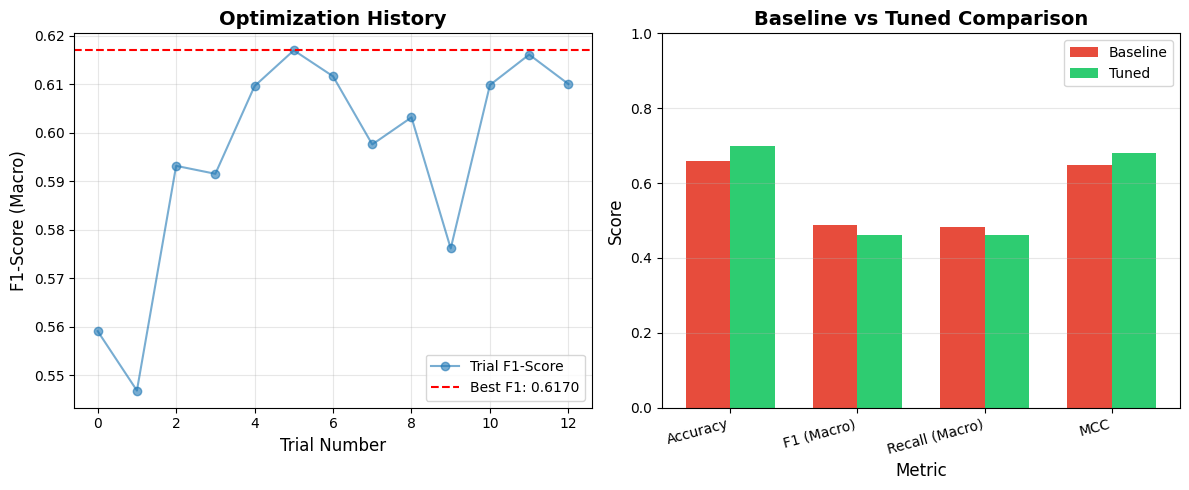

Visualisasi tersimpan!


In [20]:
# Plot 1: Optimization History
fig = plt.figure(figsize=(12, 5))

# Optimization history
plt.subplot(1, 2, 1)
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value for trial in study.trials]
plt.plot(trial_numbers, trial_values, 'o-', alpha=0.6, label='Trial F1-Score')
plt.axhline(y=study.best_value, color='r', linestyle='--', label=f'Best F1: {study.best_value:.4f}')
plt.xlabel('Trial Number', fontsize=12)
plt.ylabel('F1-Score (Macro)', fontsize=12)
plt.title('Optimization History', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

# Comparison bar chart
plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'F1 (Macro)', 'Recall (Macro)', 'MCC']
baseline_vals = comparison_df.iloc[0:4]['Baseline'].values
tuned_vals = comparison_df.iloc[0:4]['Tuned'].values

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, baseline_vals, width, label='Baseline', color='#e74c3c')
plt.bar(x + width/2, tuned_vals, width, label='Tuned', color='#2ecc71')

plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Baseline vs Tuned Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics, rotation=15, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim([0, 1])

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'lightgbm_tuning_visualization.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi tersimpan!")

**2.8.10 Ringkasan Hyperparameter Tuning LightGBM**

In [23]:
print(f"\nHasil Tuning:")
print(f"  Waktu tuning: {elapsed_time/60:.2f} menit")
print(f"  Jumlah trials: {len(study.trials)}")
print(f"  Best CV F1-Score: {study.best_value:.4f}")
print(f"  Test F1-Score: {results['f1_macro']:.4f}")

improvement_f1 = ((results['f1_macro'] - lgb_baseline['f1_macro']) / lgb_baseline['f1_macro']) * 100
improvement_acc = ((results['accuracy'] - lgb_baseline['accuracy']) / lgb_baseline['accuracy']) * 100

print(f"\nTuning Configuration:")
print(f"  Sample size: {len(X_train_sample):,} ({SAMPLE_FRACTION*100:.0f}%)")
print(f"  Trials completed: {len(study.trials)}")
print(f"  Time: {elapsed_time/60:.1f} min")

print(f"\nPerformance:")
print(f"  Baseline F1-Macro: {lgb_baseline['f1_macro']:.4f}")
print(f"  Tuned F1-Macro: {results['f1_macro']:.4f}")
print(f"  Improvement: {improvement_f1:+.2f}%")

print(f"\nImprovement:")
print(f"  F1-Score: +{improvement_f1:.2f}%")
print(f"  Accuracy: +{improvement_acc:.2f}%")

if results['f1_macro'] > lgb_baseline['f1_macro']:
    print(f"\n✓ Tuning BERHASIL meningkatkan performa!")
else:
    print(f"\n✗ Tuning tidak meningkatkan performa secara signifikan")
    print(f"  Kemungkinan: data terlalu imbalanced untuk LightGBM")

print("\n" + "="*60)
print("HPT LIGHTGBM SELESAI!")
print("="*60)
print("\nFile yang tersimpan:")
print("  - lightgbm_best_params.json")
print("  - lightgbm_tuned.pkl")
print("  - lightgbm_tuned_results.json")
print("  - lightgbm_tuning_comparison.csv")
print("  - lightgbm_tuning_visualization.png")
print("  - cm_lightgbm_tuned.npy")
print("  - report_lightgbm_tuned.json")


Hasil Tuning:
  Waktu tuning: 93.18 menit
  Jumlah trials: 13
  Best CV F1-Score: 0.6170
  Test F1-Score: 0.4602

Tuning Configuration:
  Sample size: 1,711,888 (10%)
  Trials completed: 13
  Time: 93.2 min

Performance:
  Baseline F1-Macro: 0.4880
  Tuned F1-Macro: 0.4602
  Improvement: -5.70%

Improvement:
  F1-Score: +-5.70%
  Accuracy: +6.32%

✗ Tuning tidak meningkatkan performa secara signifikan
  Kemungkinan: data terlalu imbalanced untuk LightGBM

HPT LIGHTGBM SELESAI!

File yang tersimpan:
  - lightgbm_best_params.json
  - lightgbm_tuned.pkl
  - lightgbm_tuned_results.json
  - lightgbm_tuning_comparison.csv
  - lightgbm_tuning_visualization.png
  - cm_lightgbm_tuned.npy
  - report_lightgbm_tuned.json


###**2.9 Training Deep Neural Network (DNN) Full Dataset**

In [ ]:
# Clear memory sebelum training
clear_memory()
print_memory_status("Sebelum Training DNN")

  Memory cleared

[Memory Status - Sebelum Training DNN]
  Used: 13.15 GB / 50.99 GB (25.8%)
  Available: 37.84 GB


In [ ]:
num_features = X_train.shape[1]
num_classes = len(np.unique(y_train))

def create_dnn_model(num_features, num_classes):
    """
    Membuat arsitektur DNN
    """
    model = keras.Sequential([
        layers.Input(shape=(num_features,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(16, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Custom callback untuk logging memory
class MemoryLoggingCallback(keras.callbacks.Callback):
    def __init__(self, log_frequency=1):
        super().__init__()
        self.log_frequency = log_frequency
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        print("Training dimulai...")
        print_memory_status("Train Begin")

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.log_frequency == 0:
            elapsed = time.time() - self.start_time
            used, total, available, percent = get_memory_usage()
            print(f"\nEpoch {epoch + 1}:")
            print(f"  Loss: {logs.get('loss'):.4f} - Acc: {logs.get('accuracy'):.4f}")
            print(f"  Val Loss: {logs.get('val_loss'):.4f} - Val Acc: {logs.get('val_accuracy'):.4f}")
            print(f"  Time: {elapsed:.1f}s - RAM: {percent:.1f}% ({available:.1f} GB available)")

dnn_full = create_dnn_model(num_features, num_classes)

In [ ]:
print("Arsitektur DNN:")
dnn_full.summary()

# Callbacks
checkpoint_full = ModelCheckpoint(
    os.path.join(CHECKPOINT_DIR, 'dnn_full_best.h5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

memory_logger = MemoryLoggingCallback(log_frequency=1)

Arsitektur DNN:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 34)             │           578 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,458 (68.20 KB)

 Trainable params: 17,010 (66.45 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
print("Mulai training DNN...")
start_time = time.time()

try:
    history_full = dnn_full.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=50,
        batch_size=512,  # Batch size lebih besar untuk efisiensi memori (Sebelumnya 256)
        callbacks=[checkpoint_full, early_stopping, reduce_lr, memory_logger],
        verbose=0  # Suppress default output, pakai custom callback (Sebelumnya verbose=1)
    )

    dnn_full_time = time.time() - start_time
    print(f"\nTraining selesai dalam {dnn_full_time:.2f} detik ({dnn_full_time/60:.2f} menit)")

    print_memory_status("Setelah Training DNN")

    # Prediksi
    print("\nMelakukan prediksi pada test set...")
    y_pred_dnn_full_proba = dnn_full.predict(X_test, batch_size=512, verbose=0)
    y_pred_dnn_full = np.argmax(y_pred_dnn_full_proba, axis=1)

    # Evaluasi
    dnn_full_results, dnn_full_cm, dnn_full_report = evaluate_model(
        y_test, y_pred_dnn_full, "Deep Neural Network", dnn_full_time
    )
    print_results(dnn_full_results)
    all_results.append(dnn_full_results)

    # Simpan model dan history
    print("\nMenyimpan model DNN...")
    dnn_full.save(os.path.join(MODELS_DIR, 'baseline_dnn_full.h5'))
    np.save(os.path.join(RESULTS_DIR, 'cm_dnn_full.npy'), dnn_full_cm)
    with open(os.path.join(RESULTS_DIR, 'report_dnn_full.json'), 'w') as f:
        json.dump(dnn_full_report, f, indent=4)

    history_full_dict = {
        'loss': [float(x) for x in history_full.history['loss']],
        'accuracy': [float(x) for x in history_full.history['accuracy']],
        'val_loss': [float(x) for x in history_full.history['val_loss']],
        'val_accuracy': [float(x) for x in history_full.history['val_accuracy']]
    }
    with open(os.path.join(RESULTS_DIR, 'dnn_full_history.json'), 'w') as f:
        json.dump(history_full_dict, f, indent=4)

    print("Model DNN tersimpan!")

    # Clear memory
    del y_pred_dnn_full_proba, y_pred_dnn_full
    clear_memory()

except Exception as e:
    print(f"\nError saat training DNN: {e}")
    print("Jika error memory, coba kurangi batch_size atau epochs")

print_memory_status("Setelah DNN")

Mulai training DNN...
Training dimulai...

[Memory Status - Train Begin]
  Used: 20.45 GB / 50.99 GB (40.1%)
  Available: 30.54 GB

Epoch 1: val_loss improved from inf to 0.51752, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 1:
  Loss: 0.5786 - Acc: 0.7224
  Val Loss: 0.5175 - Val Acc: 0.7530
  Time: 86.4s - RAM: 34.2% (33.6 GB available)

Epoch 2: val_loss improved from 0.51752 to 0.50283, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 2:
  Loss: 0.5498 - Acc: 0.7331
  Val Loss: 0.5028 - Val Acc: 0.7589
  Time: 162.6s - RAM: 34.3% (33.5 GB available)

Epoch 3: val_loss improved from 0.50283 to 0.50049, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 3:
  Loss: 0.5403 - Acc: 0.7392
  Val Loss: 0.5005 - Val Acc: 0.7630
  Time: 238.2s - RAM: 34.3% (33.5 GB available)

Epoch 4: val_loss did not improve from 0.50049

Epoch 4:
  Loss: 0.5404 - Acc: 0.7379
  Val Loss: 0.5040 - Val Acc: 0.7626
  Time: 313.0s - RAM: 34.4% (33.5 GB available)

Epoch 5: val_loss did not improve from 0.50049

Epoch 5:
  Loss: 0.5337 - Acc: 0.7419
  Val Loss: 0.5346 - Val Acc: 0.7332
  Time: 387.9s - RAM: 34.4% (33.5 GB available)

Epoch 6: val_loss improved from 0.50049 to 0.49486, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 6:
  Loss: 0.5338 - Acc: 0.7417
  Val Loss: 0.4949 - Val Acc: 0.7528
  Time: 463.7s - RAM: 34.4% (33.5 GB available)

Epoch 7: val_loss did not improve from 0.49486

Epoch 7:
  Loss: 0.5250 - Acc: 0.7462
  Val Loss: 0.5258 - Val Acc: 0.7307
  Time: 538.8s - RAM: 34.5% (33.4 GB available)

Epoch 8: val_loss improved from 0.49486 to 0.48934, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 8:
  Loss: 0.5148 - Acc: 0.7524
  Val Loss: 0.4893 - Val Acc: 0.7624
  Time: 614.3s - RAM: 34.5% (33.4 GB available)

Epoch 9: val_loss did not improve from 0.48934

Epoch 9:
  Loss: 0.5088 - Acc: 0.7548
  Val Loss: 0.5390 - Val Acc: 0.7343
  Time: 688.7s - RAM: 34.5% (33.4 GB available)

Epoch 10: val_loss improved from 0.48934 to 0.48103, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 10:
  Loss: 0.5081 - Acc: 0.7551
  Val Loss: 0.4810 - Val Acc: 0.7614
  Time: 763.8s - RAM: 34.4% (33.4 GB available)

Epoch 11: val_loss did not improve from 0.48103

Epoch 11:
  Loss: 0.5056 - Acc: 0.7561
  Val Loss: 0.4811 - Val Acc: 0.7621
  Time: 838.0s - RAM: 34.5% (33.4 GB available)

Epoch 12: val_loss did not improve from 0.48103

Epoch 12:
  Loss: 0.5045 - Acc: 0.7565
  Val Loss: 0.5140 - Val Acc: 0.7359
  Time: 913.5s - RAM: 34.5% (33.4 GB available)

Epoch 13: val_loss improved from 0.48103 to 0.47562, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 13:
  Loss: 0.5070 - Acc: 0.7556
  Val Loss: 0.4756 - Val Acc: 0.7675
  Time: 990.0s - RAM: 34.5% (33.4 GB available)

Epoch 14: val_loss did not improve from 0.47562

Epoch 14:
  Loss: 0.5031 - Acc: 0.7571
  Val Loss: 0.4781 - Val Acc: 0.7664
  Time: 1065.3s - RAM: 34.5% (33.4 GB available)

Epoch 15: val_loss did not improve from 0.47562

Epoch 15:
  Loss: 0.5037 - Acc: 0.7569
  Val Loss: 0.4811 - Val Acc: 0.7663
  Time: 1140.3s - RAM: 34.6% (33.4 GB available)

Epoch 16: val_loss improved from 0.47562 to 0.47520, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 16:
  Loss: 0.4997 - Acc: 0.7584
  Val Loss: 0.4752 - Val Acc: 0.7684
  Time: 1215.8s - RAM: 34.5% (33.4 GB available)

Epoch 17: val_loss did not improve from 0.47520

Epoch 17:
  Loss: 0.4985 - Acc: 0.7589
  Val Loss: 0.4767 - Val Acc: 0.7654
  Time: 1290.4s - RAM: 34.5% (33.4 GB available)

Epoch 18: val_loss did not improve from 0.47520

Epoch 18:
  Loss: 0.5006 - Acc: 0.7581
  Val Loss: 0.4756 - Val Acc: 0.7691
  Time: 1365.8s - RAM: 34.5% (33.4 GB available)

Epoch 19: val_loss improved from 0.47520 to 0.47210, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 19:
  Loss: 0.4982 - Acc: 0.7589
  Val Loss: 0.4721 - Val Acc: 0.7693
  Time: 1441.3s - RAM: 34.6% (33.4 GB available)

Epoch 20: val_loss improved from 0.47210 to 0.47168, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 20:
  Loss: 0.4977 - Acc: 0.7593
  Val Loss: 0.4717 - Val Acc: 0.7704
  Time: 1517.2s - RAM: 34.5% (33.4 GB available)

Epoch 21: val_loss did not improve from 0.47168

Epoch 21:
  Loss: 0.4977 - Acc: 0.7592
  Val Loss: 0.4750 - Val Acc: 0.7682
  Time: 1591.8s - RAM: 34.5% (33.4 GB available)

Epoch 22: val_loss did not improve from 0.47168

Epoch 22:
  Loss: 0.4968 - Acc: 0.7596
  Val Loss: 0.4747 - Val Acc: 0.7614
  Time: 1666.9s - RAM: 34.5% (33.4 GB available)

Epoch 23: val_loss did not improve from 0.47168

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 23:
  Loss: 0.4960 - Acc: 0.7597
  Val Loss: 0.4718 - Val Acc: 0.7703
  Time: 1741.4s - RAM: 34.6% (33.4 GB available)

Epoch 24: val_loss improved from 0.47168 to 0.47154, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 24:
  Loss: 0.4915 - Acc: 0.7618
  Val Loss: 0.4715 - Val Acc: 0.7692
  Time: 1816.5s - RAM: 34.6% (33.4 GB available)

Epoch 25: val_loss improved from 0.47154 to 0.46958, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 25:
  Loss: 0.4908 - Acc: 0.7621
  Val Loss: 0.4696 - Val Acc: 0.7705
  Time: 1891.5s - RAM: 34.6% (33.4 GB available)

Epoch 26: val_loss improved from 0.46958 to 0.46892, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 26:
  Loss: 0.4904 - Acc: 0.7623
  Val Loss: 0.4689 - Val Acc: 0.7710
  Time: 1967.3s - RAM: 34.5% (33.4 GB available)

Epoch 27: val_loss did not improve from 0.46892

Epoch 27:
  Loss: 0.4901 - Acc: 0.7624
  Val Loss: 0.4694 - Val Acc: 0.7711
  Time: 2042.2s - RAM: 34.6% (33.4 GB available)

Epoch 28: val_loss did not improve from 0.46892

Epoch 28:
  Loss: 0.4899 - Acc: 0.7625
  Val Loss: 0.4692 - Val Acc: 0.7715
  Time: 2116.4s - RAM: 34.6% (33.4 GB available)

Epoch 29: val_loss improved from 0.46892 to 0.46886, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 29:
  Loss: 0.4887 - Acc: 0.7628
  Val Loss: 0.4689 - Val Acc: 0.7714
  Time: 2191.6s - RAM: 34.5% (33.4 GB available)

Epoch 30: val_loss improved from 0.46886 to 0.46734, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 30:
  Loss: 0.4866 - Acc: 0.7638
  Val Loss: 0.4673 - Val Acc: 0.7716
  Time: 2267.3s - RAM: 34.6% (33.4 GB available)

Epoch 31: val_loss improved from 0.46734 to 0.46684, saving model to /content/drive/My Drive/Baseline/Checkpoints/dnn_full_best.h5



Epoch 31:
  Loss: 0.4862 - Acc: 0.7637
  Val Loss: 0.4668 - Val Acc: 0.7717
  Time: 2343.1s - RAM: 34.6% (33.4 GB available)

Epoch 32: val_loss did not improve from 0.46684

Epoch 32:
  Loss: 0.4861 - Acc: 0.7639
  Val Loss: 0.4675 - Val Acc: 0.7707
  Time: 2417.5s - RAM: 34.6% (33.3 GB available)

Epoch 33: val_loss did not improve from 0.46684

Epoch 33:
  Loss: 0.4860 - Acc: 0.7639
  Val Loss: 0.4673 - Val Acc: 0.7719
  Time: 2491.9s - RAM: 34.6% (33.3 GB available)

Epoch 34: val_loss did not improve from 0.46684

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 34:
  Loss: 0.4857 - Acc: 0.7639
  Val Loss: 0.4671 - Val Acc: 0.7723
  Time: 2566.4s - RAM: 34.6% (33.3 GB available)

Epoch 35: val_loss did not improve from 0.46684

Epoch 35:
  Loss: 0.4849 - Acc: 0.7644
  Val Loss: 0.4673 - Val Acc: 0.7721
  Time: 2641.3s - RAM: 34.6% (33.3 GB available)

Epoch 36: val_loss did not improve from 0.46684

Epoch 36:
  Loss: 0.4848 - Acc: 0.7643
  Val L


HASIL EVALUASI: Deep Neural Network (Full)
Waktu Training: 2722.78 detik (45.38 menit)

Metrik Utama:
  Accuracy          : 0.7721
  Precision (Macro) : 0.6104
  Precision (Weighted): 0.7843
  Recall (Macro)    : 0.5616
  Recall (Weighted) : 0.7721
  F1-Score (Macro)  : 0.5631
  F1-Score (Weighted): 0.7594
  MCC               : 0.7595

Menyimpan model DNN...
Model DNN tersimpan!
  Memory cleared

[Memory Status - Setelah DNN]
  Used: 13.25 GB / 50.99 GB (26.0%)
  Available: 37.74 GB


###**2.10 Perbandingan Hasil Semua Model Baseline (Full Dataset)**

In [ ]:
comparison_df = pd.DataFrame(all_results)
print("\n", comparison_df.to_string(index=False))

# Simpan hasil
comparison_df.to_csv(os.path.join(RESULTS_DIR, 'baseline_comparison_full_only.csv'), index=False)

# Identifikasi model terbaik
print("\n" + "="*60)
print("MODEL TERBAIK PER METRIK")
print("="*60)

metrics_to_check = {
    'Accuracy': 'accuracy',
    'F1-Score (Macro)': 'f1_macro',
    'Recall (Macro)': 'recall_macro',
    'MCC': 'mcc'
}

for metric_name, metric_col in metrics_to_check.items():
    best_idx = comparison_df[metric_col].idxmax()
    best_row = comparison_df.loc[best_idx]
    print(f"\n{metric_name}:")
    print(f"  Model: {best_row['model_name']}")
    print(f"  Score: {best_row[metric_col]:.4f}")
    print(f"  Training Time: {best_row['training_time_seconds']:.2f}s")

print("\n" + "="*60)
print("Langkah 2 SELESAI!")
print("="*60)
print("\nSemua model baseline telah selesai ditraining dan dievaluasi dengan full dataset")
print("Model dan hasil tersimpan di Google Drive")

print_memory_status("Akhir Eksekusi")


          model_name dataset_type  training_time_seconds  accuracy  precision_macro  precision_weighted  recall_macro  recall_weighted  f1_macro  f1_weighted      mcc
      Random Forest         Full            1059.580000  0.790300         0.784700            0.798800      0.597400         0.790300  0.613000     0.781200 0.777600
            XGBoost         Full             651.330000  0.794300         0.766000            0.798900      0.614000         0.794300  0.635000     0.789100 0.781300
           LightGBM         Full            1455.865553  0.658434         0.526820            0.714512      0.482959         0.658434  0.488006     0.657005 0.647723
Deep Neural Network         Full            2722.776193  0.772087         0.610397            0.784321      0.561600         0.772087  0.563067     0.759376 0.759464

MODEL TERBAIK PER METRIK

Accuracy:
  Model: XGBoost
  Score: 0.7943
  Training Time: 651.33s

F1-Score (Macro):
  Model: XGBoost
  Score: 0.6350
  Training Time: 651.

# **Langkah 3: Visualisasi Hasil Baseline Models (Full Dataset Only)**

###**3.1 Mount Google Drive dan Load Hasil**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

RESULTS_DIR = '/content/drive/My Drive/Baseline/Results/'
PROCESSED_DIR = '/content/drive/My Drive/Baseline/Processed_Data/'

print("Memuat hasil evaluasi...")

# Load comparison results
comparison_df = pd.read_csv(os.path.join(RESULTS_DIR, 'baseline_comparison_full_only.csv'))

# Load label encoder
with open(os.path.join(PROCESSED_DIR, 'label_encoder.pkl'), 'rb') as f:
    label_encoder = pickle.load(f)

class_names = label_encoder.classes_

print("Data berhasil dimuat!")
print(f"\nJumlah model: {len(comparison_df)}")
print(f"Model yang dievaluasi: {comparison_df['model_name'].tolist()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Memuat hasil evaluasi...
Data berhasil dimuat!

Jumlah model: 4
Model yang dievaluasi: ['Random Forest', 'XGBoost', 'LightGBM', 'Deep Neural Network']


###**3.2 Visualisasi Perbandingan Metrik**

Membuat visualisasi perbandingan metrik...


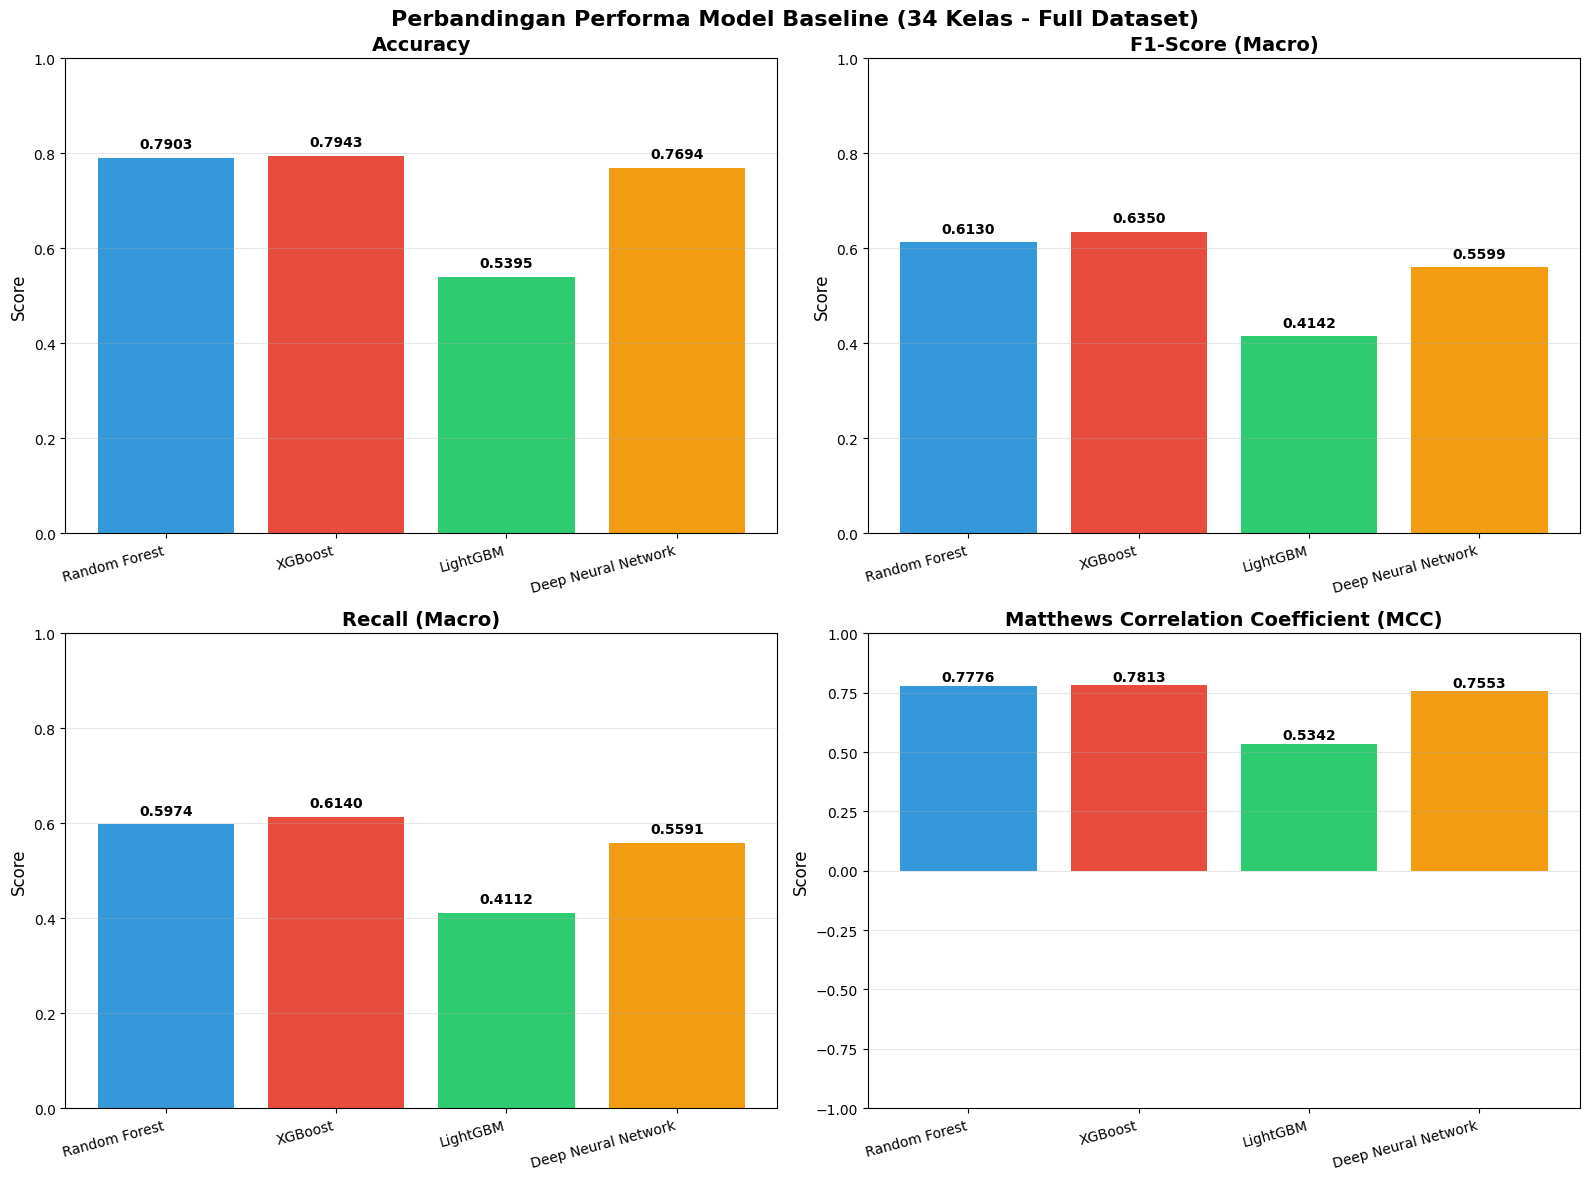

Visualisasi metrik tersimpan!


In [ ]:
print("Membuat visualisasi perbandingan metrik...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Perbandingan Performa Model Baseline (34 Kelas - Full Dataset)',
             fontsize=16, fontweight='bold')

metrics = [
    ('accuracy', 'Accuracy'),
    ('f1_macro', 'F1-Score (Macro)'),
    ('recall_macro', 'Recall (Macro)'),
    ('mcc', 'Matthews Correlation Coefficient (MCC)')
]

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, title) in enumerate(metrics):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    values = comparison_df[metric].values
    models = comparison_df['model_name'].values

    bars = ax.bar(range(len(models)), values, color=colors[:len(models)])

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xticks(range(len(models)))
    ax.set_xticklabels(models, rotation=15, ha='right', fontsize=10)
    ax.grid(axis='y', alpha=0.3)

    if metric == 'mcc':
        ax.set_ylim([-1, 1])
    else:
        ax.set_ylim([0, 1])

    for i, v in enumerate(values):
        ax.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'baseline_metrics_comparison_full.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi metrik tersimpan!")

###**3.3 Visualisasi Waktu Training**

Membuat visualisasi waktu training...


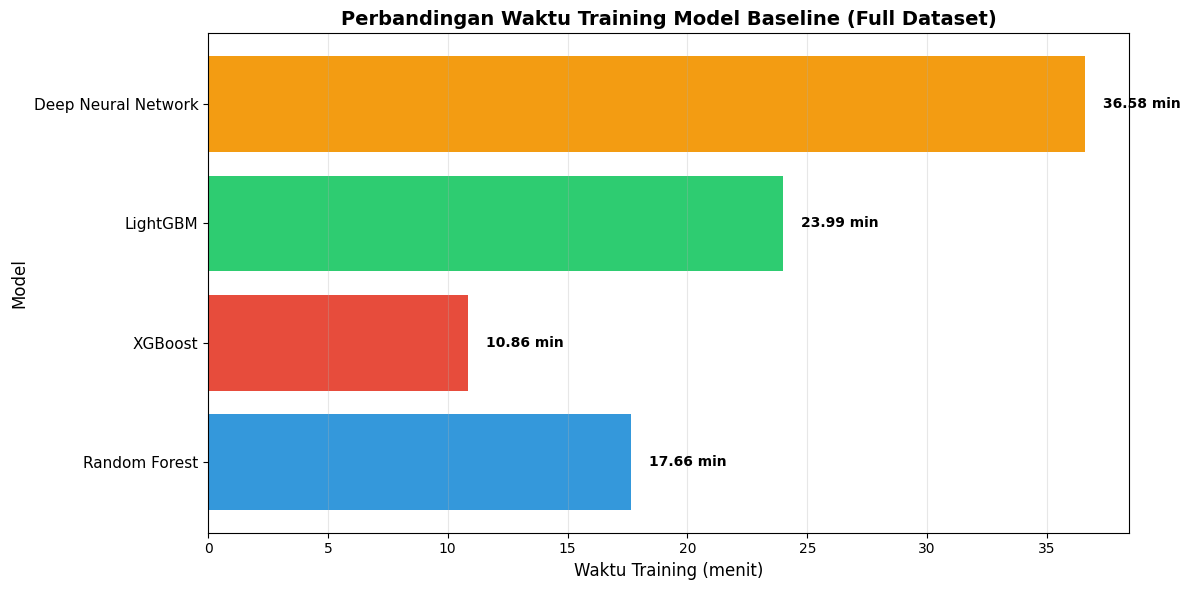

Visualisasi waktu training tersimpan!


In [ ]:
print("Membuat visualisasi waktu training...")

fig, ax = plt.subplots(figsize=(12, 6))

training_times = comparison_df['training_time_seconds'].values / 60  # Convert to minutes
models = comparison_df['model_name'].values

bars = ax.barh(range(len(models)), training_times, color=colors[:len(models)])

ax.set_xlabel('Waktu Training (menit)', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_title('Perbandingan Waktu Training Model Baseline (Full Dataset)',
             fontsize=14, fontweight='bold')
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models, fontsize=11)
ax.grid(axis='x', alpha=0.3)

for i, (bar, time) in enumerate(zip(bars, training_times)):
    width = bar.get_width()
    ax.text(width + max(training_times)*0.02, bar.get_y() + bar.get_height()/2,
            f'{time:.2f} min', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'baseline_training_time_full.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi waktu training tersimpan!")

###**3.4 Confusion Matrix Model Terbaik**

Membuat confusion matrix untuk model terbaik...
Model terbaik: XGBoost


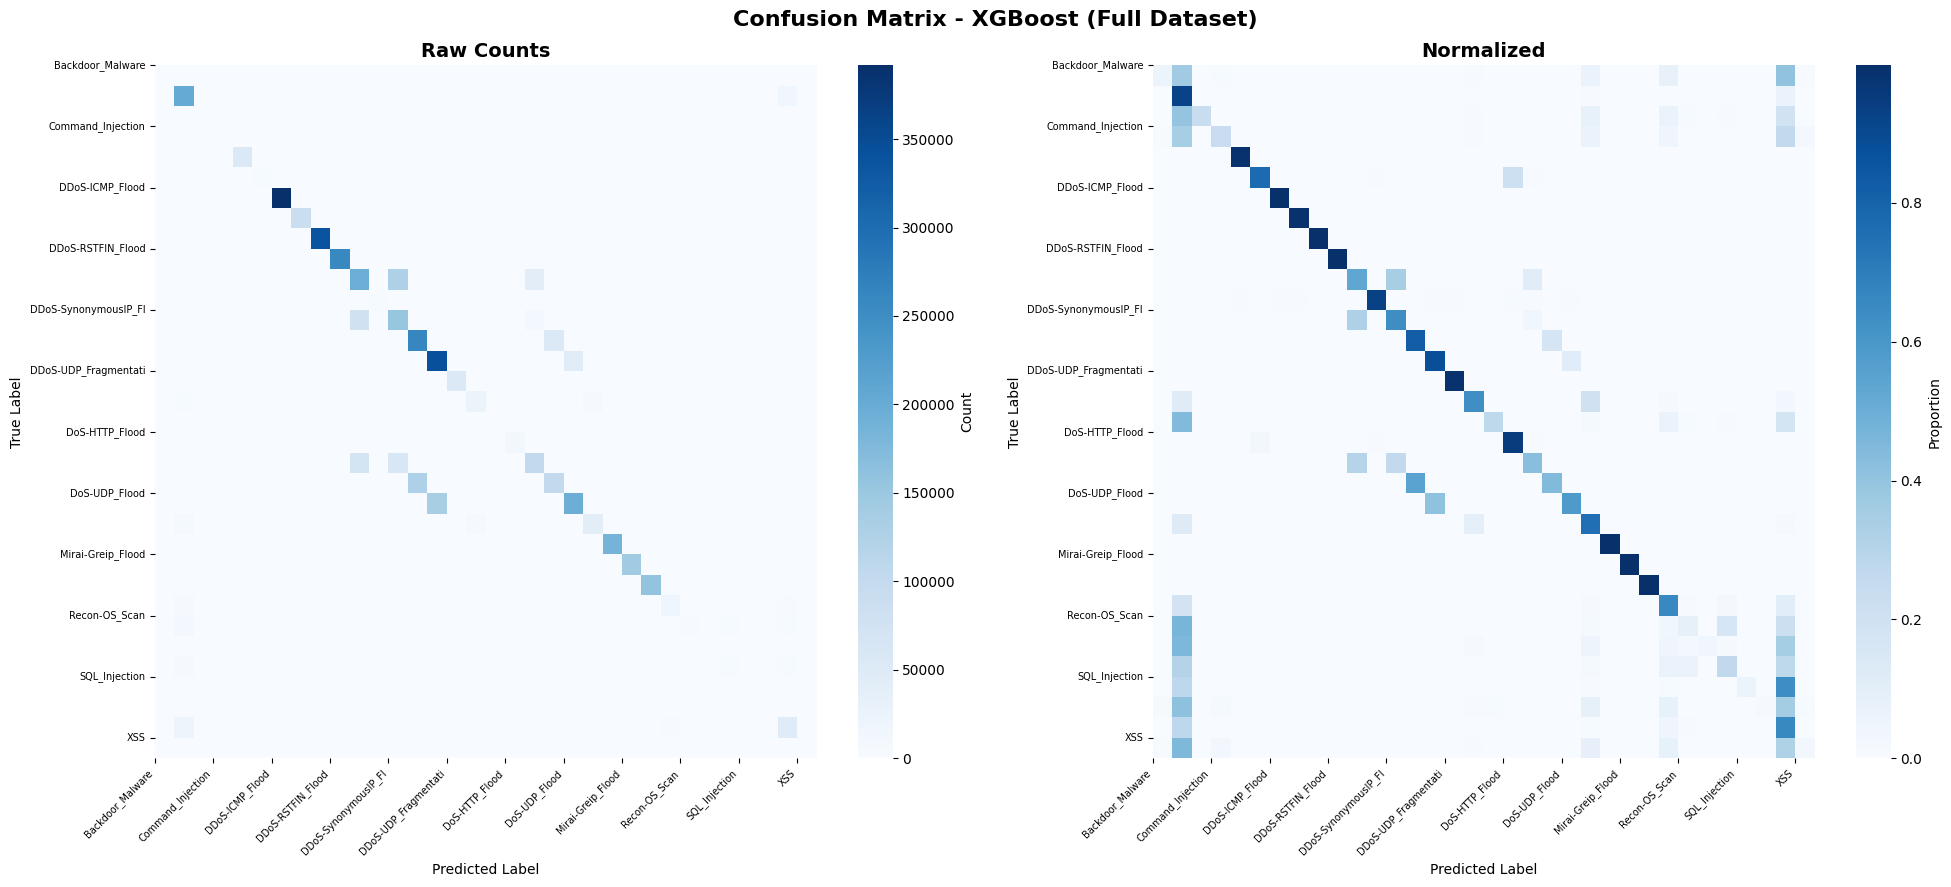

Confusion matrix tersimpan!


In [ ]:
print("Membuat confusion matrix untuk model terbaik...")

# Cari model terbaik berdasarkan F1-score
best_idx = comparison_df['f1_macro'].idxmax()
best_model = comparison_df.loc[best_idx, 'model_name']

print(f"Model terbaik: {best_model}")

# Load confusion matrix
model_mapping = {
    'Random Forest': 'rf',
    'XGBoost': 'xgboost',
    'LightGBM': 'lightgbm',
    'Deep Neural Network': 'dnn'
}

model_key = model_mapping[best_model]
cm_filename = f'cm_{model_key}_full.npy'

cm = np.load(os.path.join(RESULTS_DIR, cm_filename))

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 9))
fig.suptitle(f'Confusion Matrix - {best_model} (Full Dataset)',
             fontsize=16, fontweight='bold')

# Raw counts
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=axes[0],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Raw Counts', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=10)
axes[0].set_ylabel('True Label', fontsize=10)

# Normalized
sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', ax=axes[1],
            cbar_kws={'label': 'Proportion'})
axes[1].set_title('Normalized', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=10)
axes[1].set_ylabel('True Label', fontsize=10)

# Set tick labels (setiap 3 kelas untuk 34 kelas)
tick_positions = range(0, len(class_names), 3)
tick_labels = [class_names[i][:20] if i < len(class_names) else '' for i in tick_positions]

for ax in axes:
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=7)
    ax.set_yticklabels(tick_labels, rotation=0, fontsize=7)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix_best_model_full.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix tersimpan!")

### **3.5 Analisis Per-Kelas (Model Terbaik)**

Membuat analisis per-class untuk model terbaik...
Model terbaik: XGBoost


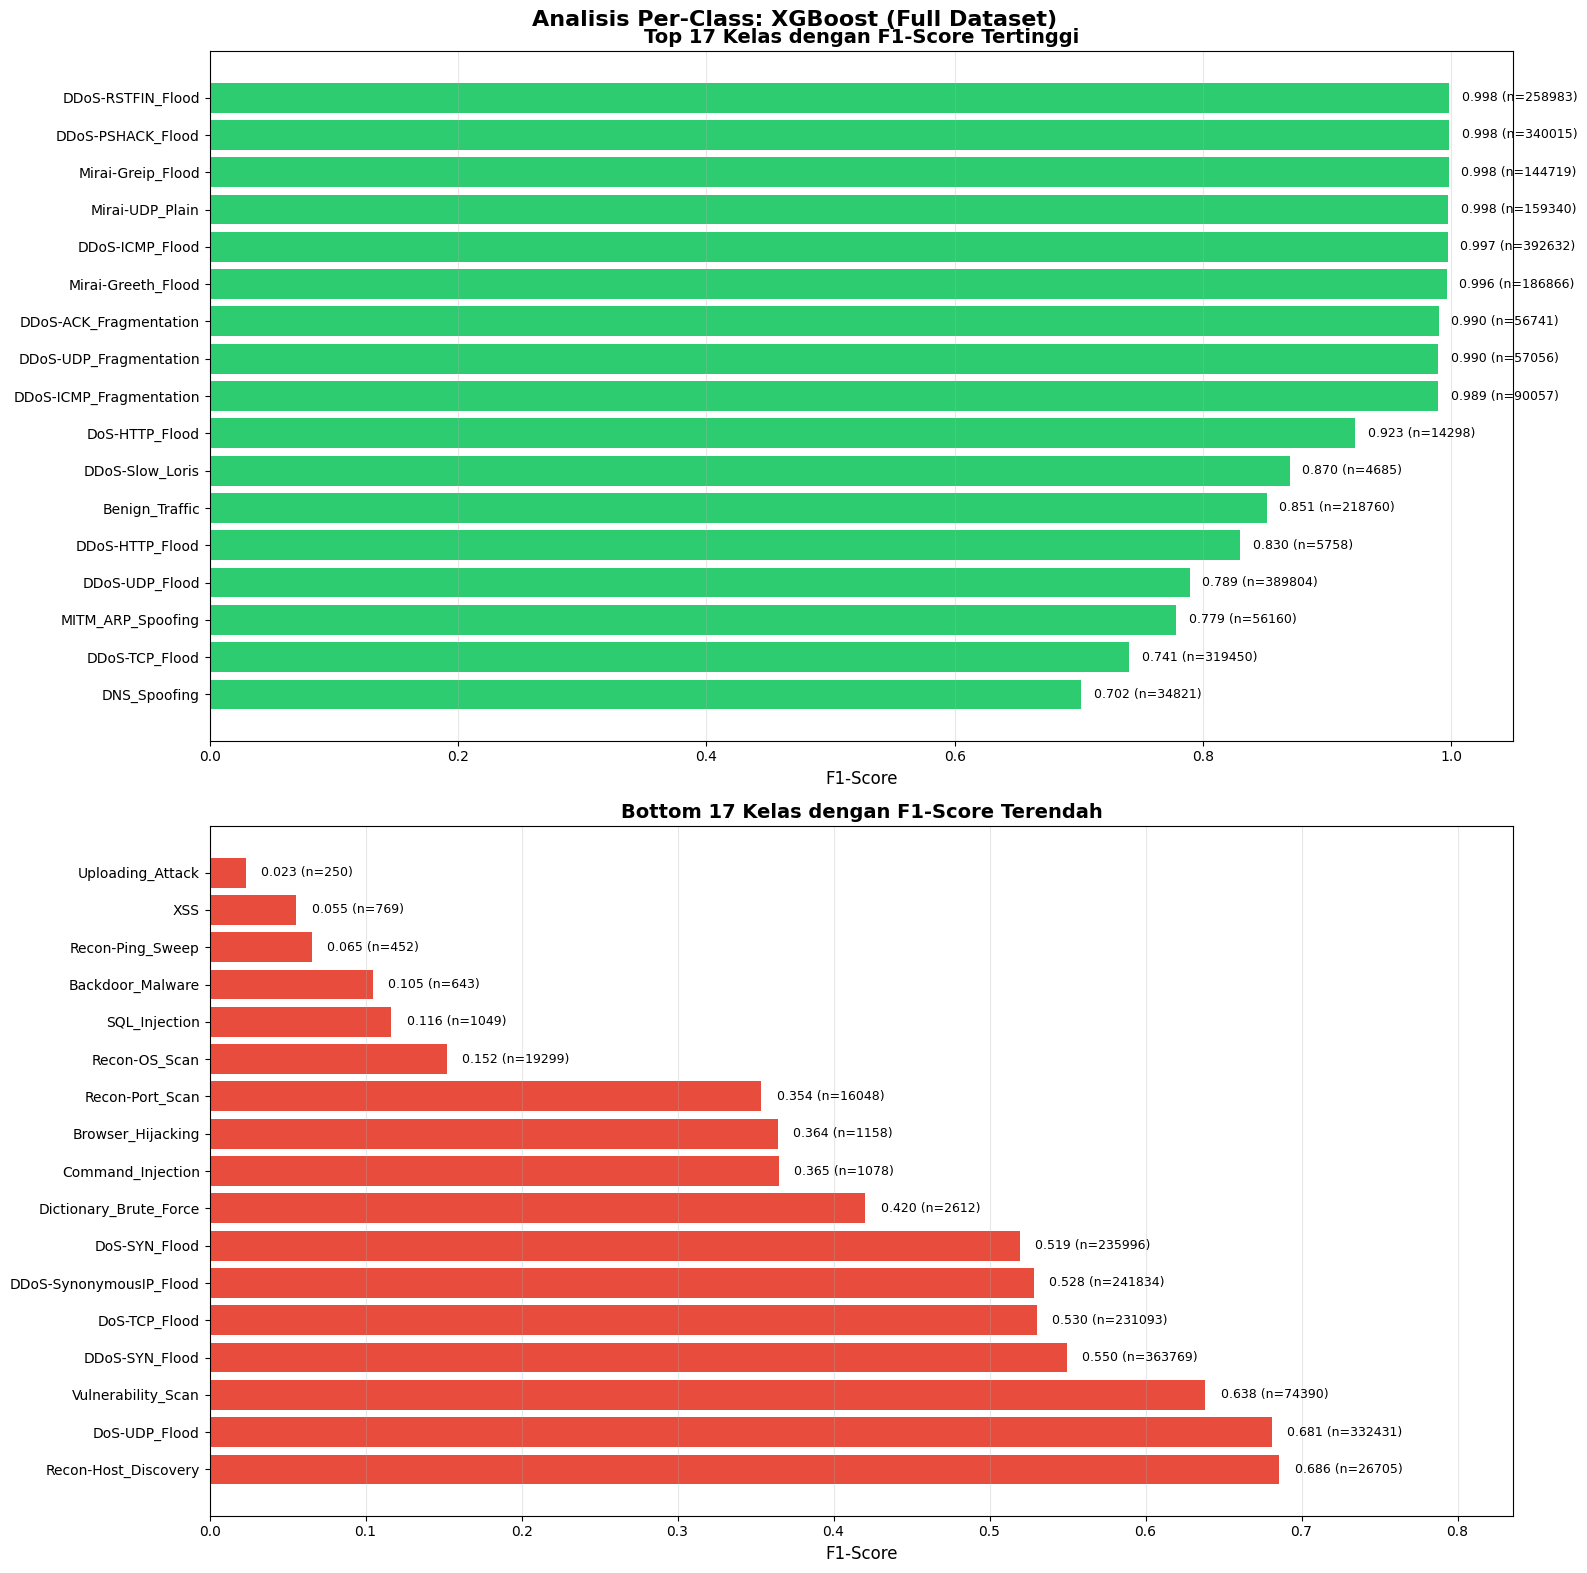

Analisis per-class tersimpan!


In [ ]:
print("Membuat analisis per-class untuk model terbaik...")

# Cari model terbaik berdasarkan F1-score
best_idx = comparison_df['f1_macro'].idxmax()
best_model = comparison_df.loc[best_idx, 'model_name']

print(f"Model terbaik: {best_model}")

# Mapping untuk nama file confusion matrix dan report
model_mapping = {
    'Random Forest': 'rf',
    'XGBoost': 'xgboost',
    'LightGBM': 'lightgbm',
    'Deep Neural Network': 'dnn'
}

model_key = model_mapping[best_model]

# Load classification report
report_filename = f'report_{model_key}_full.json'
with open(os.path.join(RESULTS_DIR, report_filename), 'r') as f:
    report = json.load(f)

# Ekstrak metrics per class
class_metrics = []
for class_name in class_names:
    if class_name in report:
        class_metrics.append({
            'Class': class_name,
            'F1-Score': report[class_name]['f1-score'],
            'Precision': report[class_name]['precision'],
            'Recall': report[class_name]['recall'],
            'Support': report[class_name]['support']
        })

metrics_df = pd.DataFrame(class_metrics)
metrics_df = metrics_df.sort_values('F1-Score', ascending=False)

# Simpan semua metrics
metrics_df.to_csv(os.path.join(RESULTS_DIR, 'per_class_metrics_all_classes.csv'), index=False)

# Plot 17 top dan 17 bottom
fig, axes = plt.subplots(2, 1, figsize=(16, 16))
fig.suptitle(f'Analisis Per-Class: {best_model} (Full Dataset)',
             fontsize=16, fontweight='bold')

# Top 17
top17 = metrics_df.head(17)
axes[0].barh(range(len(top17)), top17['F1-Score'], color='#2ecc71')
axes[0].set_yticks(range(len(top17)))
axes[0].set_yticklabels(top17['Class'], fontsize=10)
axes[0].set_xlabel('F1-Score', fontsize=12)
axes[0].set_title('Top 17 Kelas dengan F1-Score Tertinggi',
                  fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].set_xlim([0, 1.05])
axes[0].invert_yaxis()

for i, (idx, row) in enumerate(top17.iterrows()):
    axes[0].text(row['F1-Score'] + 0.01, i,
                f"{row['F1-Score']:.3f} (n={int(row['Support'])})",
                va='center', fontsize=9)

# Bottom 17
bottom17 = metrics_df.tail(17).sort_values('F1-Score', ascending=True)
axes[1].barh(range(len(bottom17)), bottom17['F1-Score'], color='#e74c3c')
axes[1].set_yticks(range(len(bottom17)))
axes[1].set_yticklabels(bottom17['Class'], fontsize=10)
axes[1].set_xlabel('F1-Score', fontsize=12)
axes[1].set_title('Bottom 17 Kelas dengan F1-Score Terendah',
                  fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].set_xlim([0, max(bottom17['F1-Score']) + 0.15])
axes[1].invert_yaxis()

for i, (idx, row) in enumerate(bottom17.iterrows()):
    axes[1].text(row['F1-Score'] + 0.01, i,
                f"{row['F1-Score']:.3f} (n={int(row['Support'])})",
                va='center', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'per_class_analysis_17_17.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("Analisis per-class tersimpan!")

# Simpan detail per-class
metrics_df.to_csv(os.path.join(RESULTS_DIR, 'per_class_metrics_best_model_full.csv'), index=False)

###**3.6 Visualisasi Semua 34 Kelas**


Membuat visualisasi semua 34 kelas...


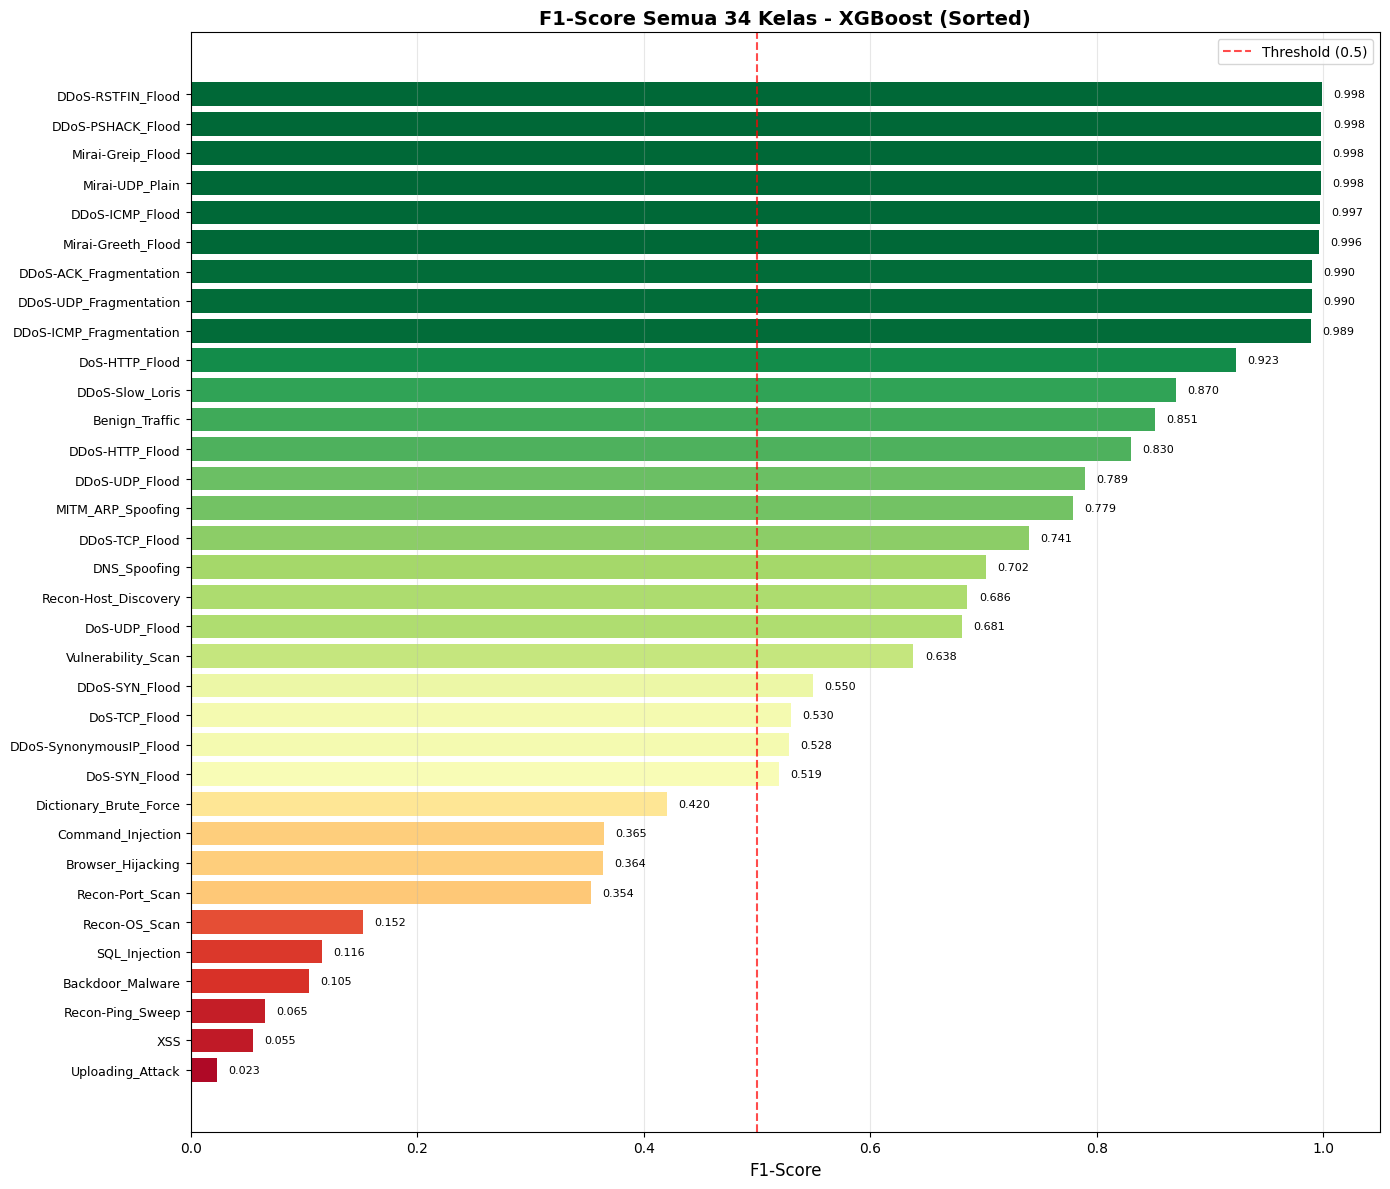

Visualisasi semua 34 kelas tersimpan!


In [ ]:
print("\nMembuat visualisasi semua 34 kelas...")

fig, ax = plt.subplots(figsize=(14, 12))

# Warna gradient berdasarkan F1-score
colors_gradient = plt.cm.RdYlGn(metrics_df['F1-Score'].values)

bars = ax.barh(range(len(metrics_df)), metrics_df['F1-Score'], color=colors_gradient)

ax.set_yticks(range(len(metrics_df)))
ax.set_yticklabels(metrics_df['Class'], fontsize=9)
ax.set_xlabel('F1-Score', fontsize=12)
ax.set_title(f'F1-Score Semua 34 Kelas - {best_model} (Sorted)',
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.set_xlim([0, 1.05])
ax.invert_yaxis()

# Tambahkan garis threshold
ax.axvline(x=0.5, color='red', linestyle='--', linewidth=1.5,
           alpha=0.7, label='Threshold (0.5)')
ax.legend(fontsize=10)

# Annotate values
for i, (idx, row) in enumerate(metrics_df.iterrows()):
    ax.text(row['F1-Score'] + 0.01, i, f"{row['F1-Score']:.3f}",
            va='center', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'all_34_classes_sorted.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("Visualisasi semua 34 kelas tersimpan!")

### **3.7 Analisis Kelas Problematik**

#### Alasan Pemilihan Threshold 0.5:

1. Standar Industri untuk Imbalanced Classification

    * F1-Score 0.5 adalah titik tengah antara perfect (1.0) dan random guess untuk binary

    * Dalam cybersecurity/IDS, F1 < 0.5 dianggap "tidak dapat diandalkan" untuk deployment

    * Beberapa paper akademik menggunakan 0.5 sebagai "minimum acceptable performance"

2. Trade-off Praktis

    * F1 ≥ 0.5: Model mulai "useful" untuk deteksi serangan

    * F1 < 0.5: Model lebih buruk dari heuristic sederhana

    * Untuk 34 kelas dengan imbalance 1:5751, threshold 0.5 cukup reasonable

3. Berdasarkan Hasil:

    * 10 kelas memiliki F1 < 0.5 (29% dari total kelas)

    * Ini menunjukkan problem sistemik yang perlu diperbaiki

    * Threshold lebih rendah (0.3) akan terlalu permisif

    * Threshold lebih tinggi (0.7) akan menandai terlalu banyak kelas

  Alternatif yang Bisa Dipertimbangkan:

  * Threshold 0.3: Untuk kelas "sangat problematik" (urgent priority)

  * Threshold 0.7: Untuk kelas "perlu improvement" (medium priority)


Kelas dengan F1-Score < 0.5:
Jumlah: 10 dari 34 kelas (29.41%)

Detail kelas problematik:
                 Class  F1-Score  Precision   Recall  Support
      Uploading_Attack  0.023256   0.375000 0.012000    250.0
                   XSS  0.055355   0.370968 0.029909    769.0
      Recon-Ping_Sweep  0.065440   0.432432 0.035398    452.0
      Backdoor_Malware  0.104668   0.578125 0.057543    643.0
         SQL_Injection  0.116279   0.942029 0.061964   1049.0
         Recon-OS_Scan  0.152020   0.501450 0.089590  19299.0
       Recon-Port_Scan  0.353641   0.516898 0.268756  16048.0
     Browser_Hijacking  0.364123   0.809524 0.234888   1158.0
     Command_Injection  0.364953   0.831683 0.233766   1078.0
Dictionary_Brute_Force  0.420315   0.884521 0.275651   2612.0


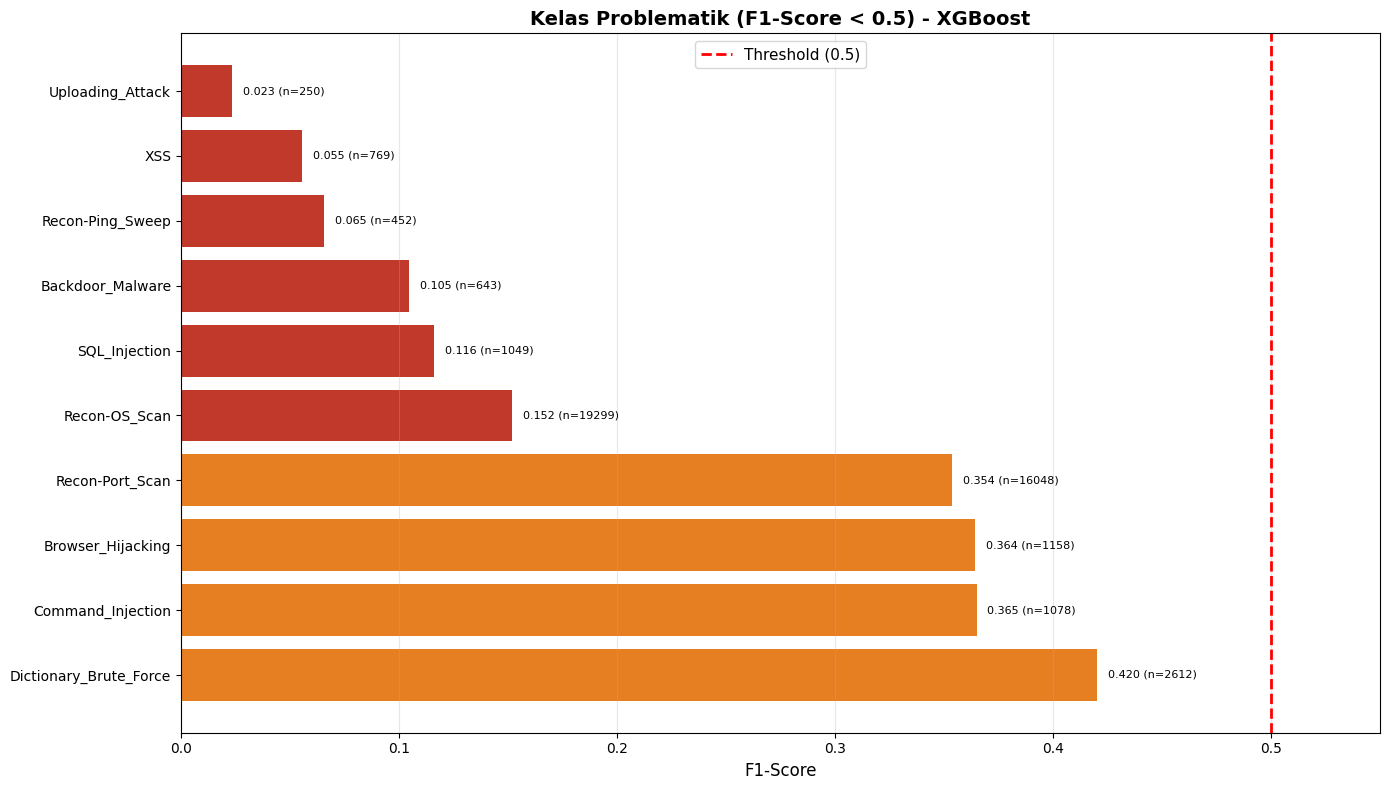


Visualisasi kelas problematik tersimpan!

ANALISIS PENYEBAB KELAS PROBLEMATIK

Uploading_Attack:
  F1-Score: 0.023
  Precision: 0.375
  Recall: 0.012
  Support: 250 samples
  Masalah: Recall sangat rendah (banyak False Negatives)
  Solusi: Perlu augmentasi data untuk kelas ini

XSS:
  F1-Score: 0.055
  Precision: 0.371
  Recall: 0.030
  Support: 769 samples
  Masalah: Recall sangat rendah (banyak False Negatives)
  Solusi: Perlu augmentasi data untuk kelas ini

Recon-Ping_Sweep:
  F1-Score: 0.065
  Precision: 0.432
  Recall: 0.035
  Support: 452 samples
  Masalah: Recall sangat rendah (banyak False Negatives)
  Solusi: Perlu augmentasi data untuk kelas ini

Backdoor_Malware:
  F1-Score: 0.105
  Precision: 0.578
  Recall: 0.058
  Support: 643 samples
  Masalah: Recall sangat rendah (banyak False Negatives)
  Solusi: Perlu augmentasi data untuk kelas ini

SQL_Injection:
  F1-Score: 0.116
  Precision: 0.942
  Recall: 0.062
  Support: 1049 samples
  Masalah: Recall sangat rendah (banyak F

In [ ]:
threshold = 0.5
problematic = metrics_df[metrics_df['F1-Score'] < threshold].sort_values('F1-Score')

print(f"\nKelas dengan F1-Score < {threshold}:")
print(f"Jumlah: {len(problematic)} dari {len(class_names)} kelas ({len(problematic)/len(class_names)*100:.2f}%)")

if len(problematic) > 0:
    print("\nDetail kelas problematik:")
    print(problematic[['Class', 'F1-Score', 'Precision', 'Recall', 'Support']].to_string(index=False))

    # Simpan
    problematic.to_csv(os.path.join(RESULTS_DIR, 'problematic_classes_full.csv'), index=False)

    # Visualisasi
    fig, ax = plt.subplots(figsize=(14, max(8, len(problematic) * 0.4)))

    colors_prob = ['#c0392b' if x < 0.3 else '#e67e22' for x in problematic['F1-Score']]
    bars = ax.barh(range(len(problematic)), problematic['F1-Score'], color=colors_prob)

    ax.set_yticks(range(len(problematic)))
    ax.set_yticklabels(problematic['Class'], fontsize=10)
    ax.set_xlabel('F1-Score', fontsize=12)
    ax.set_title(f'Kelas Problematik (F1-Score < {threshold}) - {best_model}',
                 fontsize=14, fontweight='bold')
    ax.axvline(x=threshold, color='red', linestyle='--', linewidth=2,
               label=f'Threshold ({threshold})')
    ax.grid(axis='x', alpha=0.3)
    ax.legend(fontsize=11)
    ax.set_xlim([0, threshold + 0.05])
    ax.invert_yaxis()

    for i, (idx, row) in enumerate(problematic.iterrows()):
        ax.text(row['F1-Score'] + 0.005, i,
               f"{row['F1-Score']:.3f} (n={int(row['Support'])})",
               va='center', fontsize=8)

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'problematic_classes_full.png'),
                dpi=300, bbox_inches='tight')
    plt.show()

    print("\nVisualisasi kelas problematik tersimpan!")

    # Analisis kenapa problematik
    print("\n" + "="*60)
    print("ANALISIS PENYEBAB KELAS PROBLEMATIK")
    print("="*60)

    for idx, row in problematic.head(10).iterrows():
        print(f"\n{row['Class']}:")
        print(f"  F1-Score: {row['F1-Score']:.3f}")
        print(f"  Precision: {row['Precision']:.3f}")
        print(f"  Recall: {row['Recall']:.3f}")
        print(f"  Support: {int(row['Support'])} samples")

        if row['Recall'] < 0.3:
            print("  Masalah: Recall sangat rendah (banyak False Negatives)")
            print("  Solusi: Perlu augmentasi data untuk kelas ini")
        elif row['Precision'] < 0.3:
            print("  Masalah: Precision sangat rendah (banyak False Positives)")
            print("  Solusi: Perlu feature engineering atau model lebih kompleks")
        else:
            print("  Masalah: Recall dan Precision rendah")
            print("  Solusi: Perlu kombinasi augmentasi dan feature engineering")
else:
    print("\nTidak ada kelas problematik!")

#### Mengapa Recall < 0.3 = Perlu Augmentasi?

Penjelasan Detail:

1. Apa itu Recall?

    Recall = TP / (TP + FN)

    * TP (True Positive): Serangan yang berhasil dideteksi
    * FN (False Negative): Serangan yang TIDAK terdeteksi (BAHAYA!)

2. Recall < 0.3 artinya:
    * Model hanya mendeteksi < 30% serangan dari kelas tersebut
    * 70% serangan lolos tanpa terdeteksi ini sangat berbahaya untuk IDS!

3. Mengapa Augmentasi adalah Solusi?

    * Akar penyebabnya adalah Data Scarcity (Kekurangan Data/Kelangkaan Data)

    * Kelas dengan recall rendah biasanya punya support kecil
    * Contoh dari hasil ini:

      * Uploading_Attack: Support 250, Recall 0.012 (1.2%)
      * XSS: Support 769, Recall 0.030 (3%)

Model tidak bisa belajar pattern dari data yang terlalu sedikit!, maka
solusinya adalah "Data Augmentation"

Sebelum Augmentasi:
    Support: 250 samples → Model underfitting

Setelah Augmentasi (misal SMOTE):
    Support: 2500 samples → Model bisa belajar pattern
  
Hasil:
    Recall meningkat dari 0.012 ke ~0.3-0.5

4. Kenapa Bukan Solusi Lain?
    * ❌ Feature Engineering: Tidak akan membantu jika data terlalu sedikit
    * ❌ Model Lebih Kompleks: Akan overfitting dengan data sedikit
    * ✅ Augmentasi: Menambah "pengalaman" model terhadap kelas minoritas

#### Mengapa Precision < 0.3 = Feature Engineering?

Penjelasan Detail:

1. Apa itu Precision?
    
    Precision = TP / (TP + FP)

    * TP (True Positive): Deteksi benar
    * FP (False Positive): Deteksi salah (alarm palsu)

2. Precision < 0.3 artinya:

    * Dari 100 alarm yang model kumpulkan, hanya 30 yang benar
    * 70 alarm palsu (False Positive)
    * Model kewalahan dengan alarm palsu

3. Mengapa Feature Engineering adalah Solusi?

    * Akar penyebabnya adalah Feature Overlap (Fitur tidak jauh berbeda)

    * Kelas minoritas punya fitur yang mirip dengan kelas mayoritas
    * Model bingung membedakan kedua kelas

      Contoh:

      Web Attack XSS vs Normal HTTP Traffic:

      Kedua-duanya:
      - Protokol: HTTP/HTTPS
      - Port: 80/443
      - Packet size: Similar range
      
      Model kesulitan membedakan!

      Solusi: Feature Engineering

    * Menambahkan fitur baru yang lebih diskriminatif:

      - Payload entropy (XSS biasanya lebih acak)
      - Jumlah special characters (<, >, script)
      - Sequence pattern (DOM manipulation pattern)
    
    * Hasil:

      Precision meningkat dari 0.3 ke ~0.6-0.8

4. Kenapa Bukan Augmentasi?

    * ❌ Augmentasi: Menambah data tapi tidak meningkatkan "kualitas fitur"

      - SMOTE/GAN akan generate data dengan fitur yang sama (tetap overlap)
      - FP tetap tinggi karena model tetap bingung

    * ✅ Feature Engineering: Membuat fitur yang lebih "unique" untuk kelas tersebut

### **3.8 Summary Table (Ringkasan Hasil Baseline)**

In [ ]:
summary_table = comparison_df[['model_name', 'accuracy', 'f1_macro',
                               'recall_macro', 'mcc', 'training_time_seconds']].copy()
summary_table['training_time_minutes'] = summary_table['training_time_seconds'] / 60
summary_table = summary_table.drop('training_time_seconds', axis=1)
summary_table.columns = ['Model', 'Accuracy', 'F1 (Macro)',
                        'Recall (Macro)', 'MCC', 'Training Time (min)']

print("\n", summary_table.to_string(index=False))

# Simpan summary
summary_table.to_csv(os.path.join(RESULTS_DIR, 'baseline_summary_table.csv'), index=False)

# Ranking model
print("\n" + "="*60)
print("RANKING MODEL BERDASARKAN METRIK")
print("="*60)

metrics_rank = {
    'Accuracy': 'accuracy',
    'F1-Score (Macro)': 'f1_macro',
    'Recall (Macro)': 'recall_macro',
    'MCC': 'mcc'
}

for metric_name, metric_col in metrics_rank.items():
    print(f"\n{metric_name}:")
    ranked = comparison_df.sort_values(metric_col, ascending=False)
    for rank, (idx, row) in enumerate(ranked.iterrows(), 1):
        print(f"  {rank}. {row['model_name']}: {row[metric_col]:.4f}")

print("\n" + "="*60)
print("REKOMENDASI")
print("="*60)

best_model_name = comparison_df.loc[comparison_df['f1_macro'].idxmax(), 'model_name']
print(f"\nModel terbaik untuk baseline: {best_model_name}")
print(f"  F1-Score (Macro): {comparison_df['f1_macro'].max():.4f}")
print(f"  Kelas problematik: {len(problematic)} kelas perlu augmentasi")
print(f"\nLangkah selanjutnya:")
print(f"  1. Implementasi data augmentation (SMOTE/GAN/FIGS)")
print(f"  2. Fokus pada {len(problematic)} kelas dengan F1-Score < 0.5")
print(f"  3. Hyperparameter tuning untuk LightGBM")

print("\n" + "="*60)
print("LANGKAH 3 SELESAI!")
print("="*60)
print("\nSemua visualisasi dan analisis tersimpan di Google Drive")
print(f"Lokasi: {RESULTS_DIR}")
print("\nFile yang tersimpan:")
print("  - baseline_metrics_comparison_full.png")
print("  - baseline_training_time_full.png")
print("  - confusion_matrix_best_model_full.png")
print("  - per_class_analysis_17_17.png (BARU)")
print("  - all_34_classes_sorted.png (BARU)")
print("  - per_class_metrics_all_classes.csv (BARU)")
print("  - problematic_classes_full.csv")
print("  - problematic_classes_full.png")
print("  - baseline_summary_table.csv")


               Model  Accuracy  F1 (Macro)  Recall (Macro)      MCC  Training Time (min)
      Random Forest  0.790300    0.613000        0.597400 0.777600            17.659667
            XGBoost  0.794300    0.635000        0.614000 0.781300            10.855500
           LightGBM  0.658434    0.488006        0.482959 0.647723            24.264426
Deep Neural Network  0.772087    0.563067        0.561600 0.759464            45.379603

RANKING MODEL BERDASARKAN METRIK

Accuracy:
  1. XGBoost: 0.7943
  2. Random Forest: 0.7903
  3. Deep Neural Network: 0.7721
  4. LightGBM: 0.6584

F1-Score (Macro):
  1. XGBoost: 0.6350
  2. Random Forest: 0.6130
  3. Deep Neural Network: 0.5631
  4. LightGBM: 0.4880

Recall (Macro):
  1. XGBoost: 0.6140
  2. Random Forest: 0.5974
  3. Deep Neural Network: 0.5616
  4. LightGBM: 0.4830

MCC:
  1. XGBoost: 0.7813
  2. Random Forest: 0.7776
  3. Deep Neural Network: 0.7595
  4. LightGBM: 0.6477

REKOMENDASI

Model terbaik untuk baseline: XGBoost
  F1-Sc

# **Langkah 3 (Complete Revision): Visualisasi Hasil Baseline Models (Full Dataset Only)**

  1. Feature Importance (4 Models) dengan load model yang sudah ada

  2. Confusion Matrix (4 Models)

  3. Menambahkan Macro/Micro Metrics

###**3.1 Mount Google Drive dan Load Data**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

PROCESSED_DIR = '/content/drive/My Drive/Baseline/Processed_Data/'
MODELS_DIR = '/content/drive/My Drive/Baseline/Models/'
RESULTS_DIR = '/content/drive/My Drive/Baseline/Results/'
EDA_DIR = '/content/drive/My Drive/EDA_Results/'

print("Memuat data dan models...")

# Load data
X_train = np.load(os.path.join(PROCESSED_DIR, 'X_train.npy'))
X_test = np.load(os.path.join(PROCESSED_DIR, 'X_test.npy'))
y_train = np.load(os.path.join(PROCESSED_DIR, 'y_train.npy'))
y_test = np.load(os.path.join(PROCESSED_DIR, 'y_test.npy'))

with open(os.path.join(PROCESSED_DIR, 'label_encoder.pkl'), 'rb') as f:
    label_encoder = pickle.load(f)

with open(os.path.join(PROCESSED_DIR, 'feature_names.json'), 'r') as f:
    feature_names = json.load(f)

print(f"\nData dimuat:")
print(f"Test set: {X_test.shape}")
print(f"Features: {len(feature_names)}")
print(f"Classes: {len(label_encoder.classes_)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Memuat data dan models...

Data dimuat:
Test set: (4279721, 39)
Features: 39
Classes: 34


###**3.2 Load Model Yang Sudah Ditraining**

In [7]:
models = {}

# Load Random Forest
try:
    with open(os.path.join(MODELS_DIR, 'baseline_rf_full.pkl'), 'rb') as f:
        models['RF'] = pickle.load(f)
    print("✓ Random Forest loaded")
except:
    print("✗ Random Forest not found")

# Load XGBoost
try:
    import xgboost as xgb
    models['XGBoost'] = xgb.XGBClassifier()
    models['XGBoost'].load_model(os.path.join(MODELS_DIR, 'baseline_xgboost_full.json'))
    print("✓ XGBoost loaded")
except:
    print("✗ XGBoost not found")

# Load LightGBM (baseline, bukan tuned karena performa turun)
try:
    import lightgbm as lgb
    with open(os.path.join(MODELS_DIR, 'baseline_lightgbm_full.pkl'), 'rb') as f:
        models['LightGBM'] = pickle.load(f)
    print("✓ LightGBM loaded")
except:
    print("✗ LightGBM not found")

# Load DNN
try:
    from tensorflow import keras
    models['DNN'] = keras.models.load_model(os.path.join(MODELS_DIR, 'baseline_dnn_full.h5'))
    print("✓ DNN loaded")
except:
    print("✗ DNN not found")

print(f"\nTotal models loaded: {len(models)}")

✓ Random Forest loaded
✓ XGBoost loaded
✓ LightGBM loaded


✓ DNN loaded

Total models loaded: 4


###**3.3 Feature Importance**

In [12]:
feature_importance_dict = {}

# === 3.1 Random Forest ===
if 'RF' in models:
    print("\n1. Extracting feature importance from Random Forest...")
    feature_importance_dict['RF'] = models['RF'].feature_importances_
    print("   ✓ Done")

# === 3.2 XGBoost ===
if 'XGBoost' in models:
    print("2. Extracting feature importance from XGBoost...")
    feature_importance_dict['XGBoost'] = models['XGBoost'].feature_importances_
    print("   ✓ Done")

# === 3.3 LightGBM ===
if 'LightGBM' in models:
    print("3. Extracting feature importance from LightGBM...")
    feature_importance_dict['LightGBM'] = models['LightGBM'].feature_importances_
    print("   ✓ Done")

# === 3.4 DNN (Permutation Importance) ===
if 'DNN' in models:
    print("4. Computing permutation importance for DNN...")
    print("   Catatan: Ini memakan waktu 10-15 menit")

    # Gunakan sample untuk efisiensi
    sample_size = 10000
    indices = np.random.choice(len(X_test), sample_size, replace=False)
    X_test_sample = X_test[indices]
    y_test_sample = y_test[indices]

    # Define a custom score function for make_scorer that handles Keras probabilities
    from sklearn.metrics import make_scorer, accuracy_score

    def dnn_accuracy_score_func(y_true, y_pred_proba, **kwargs): # Add **kwargs to absorb unexpected arguments
        y_pred_labels = np.argmax(y_pred_proba, axis=1)
        return accuracy_score(y_true, y_pred_labels)

    # Create the scorer, indicating it needs probabilities from the estimator
    custom_dnn_scorer = make_scorer(dnn_accuracy_score_func, needs_proba=True)

    start_time = time.time()
    perm_importance = permutation_importance(
        models['DNN'],
        X_test_sample,
        y_test_sample,
        scoring=custom_dnn_scorer, # Use the custom scorer here
        n_repeats=5,
        random_state=42,
        n_jobs=-1
    )
    elapsed = time.time() - start_time

    feature_importance_dict['DNN'] = perm_importance.importances_mean
    print(f"   ✓ Done dalam {elapsed:.1f} detik")

# === 3.5 Create DataFrame ===
importance_df = pd.DataFrame({
    'Feature': feature_names,
    **feature_importance_dict
})

# Normalize importances (0-1 scale) untuk fair comparison
for model in feature_importance_dict.keys():
    max_val = importance_df[model].max()
    if max_val > 0:
        importance_df[f'{model}_norm'] = importance_df[model] / max_val

# Calculate average importance
norm_cols = [col for col in importance_df.columns if col.endswith('_norm')]
importance_df['Average'] = importance_df[norm_cols].mean(axis=1)
importance_df = importance_df.sort_values('Average', ascending=False)

# Simpan
importance_df.to_csv(os.path.join(EDA_DIR, 'feature_importance_4models.csv'), index=False)


1. Extracting feature importance from Random Forest...
   ✓ Done
2. Extracting feature importance from XGBoost...
   ✓ Done
3. Extracting feature importance from LightGBM...
   ✓ Done
4. Computing permutation importance for DNN...
   Catatan: Ini memakan waktu 10-15 menit
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
   ✓ Done dalam 33.7 detik


Normalizing LightGBM feature importance to relative scale (0-1)...
TOP 20 FEATURES (BY AVERAGE IMPORTANCE)
        Feature  Average       RF  XGBoost  LightGBM      DNN
  Protocol Type 0.608286 0.074764 0.327952  0.003395  0.12826
            UDP 0.483057 0.056607 0.049268  0.023194  0.25932
            TCP 0.454236 0.044090 0.021484  0.017709  0.31894
        Tot sum 0.429189 0.051956 0.025546  0.058033  0.13204
  Header_Length 0.424142 0.055825 0.005672  0.071063  0.09048
           ICMP 0.422237 0.058299 0.074188  0.016620  0.16942
syn_flag_number 0.390569 0.048845 0.032299  0.029100  0.17374
            Max 0.366082 0.056111 0.009194  0.056101  0.05534
            AVG 0.364520 0.059761 0.017692  0.048997  0.05020
psh_flag_number 0.362490 0.052519 0.029526  0.026216  0.13334
      syn_count 0.335611 0.054451 0.093114  0.016954  0.05594
            IAT 0.315222 0.019123 0.001717  0.109513 -0.00004
           Rate 0.306585 0.019615 0.001501  0.100693  0.01274
      ack_count 0.306201 

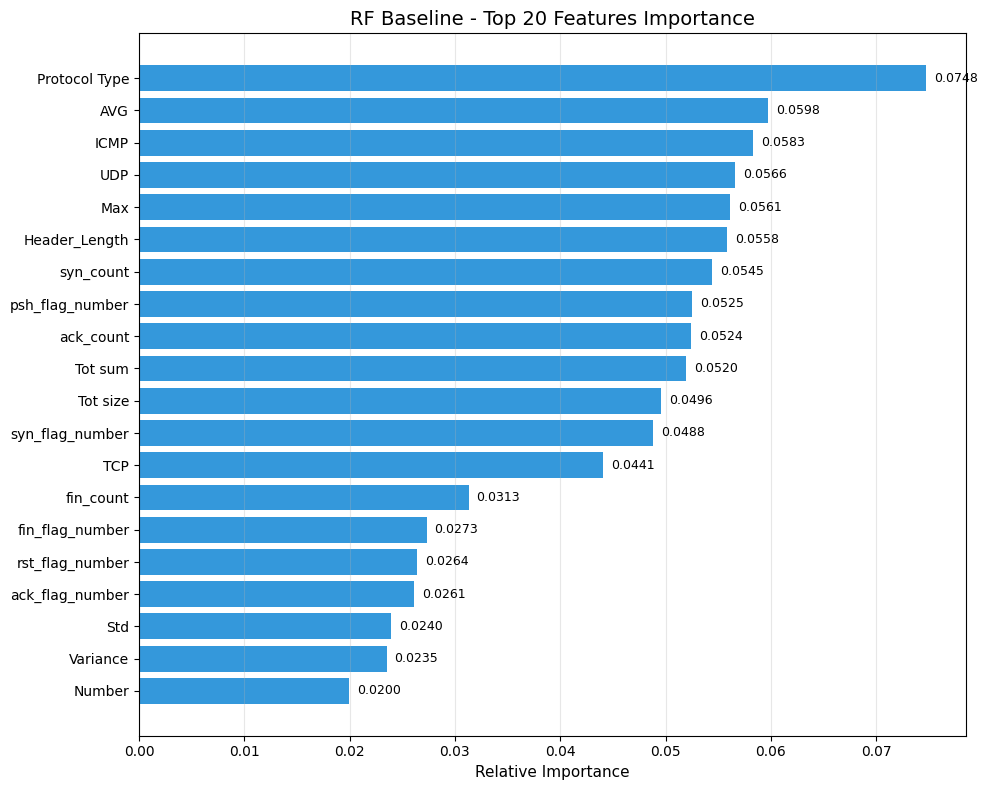

✓ Saved: /content/drive/My Drive/Baseline/Results/feature_importance_rf_baseline.png


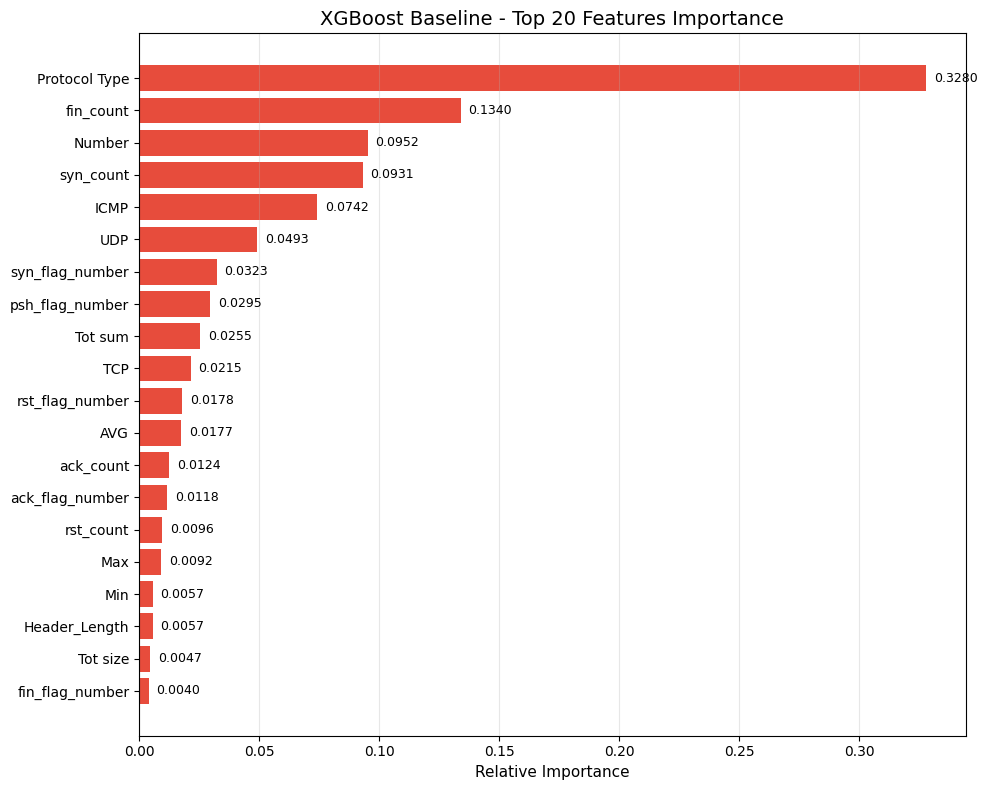

✓ Saved: /content/drive/My Drive/Baseline/Results/feature_importance_xgboost_baseline.png


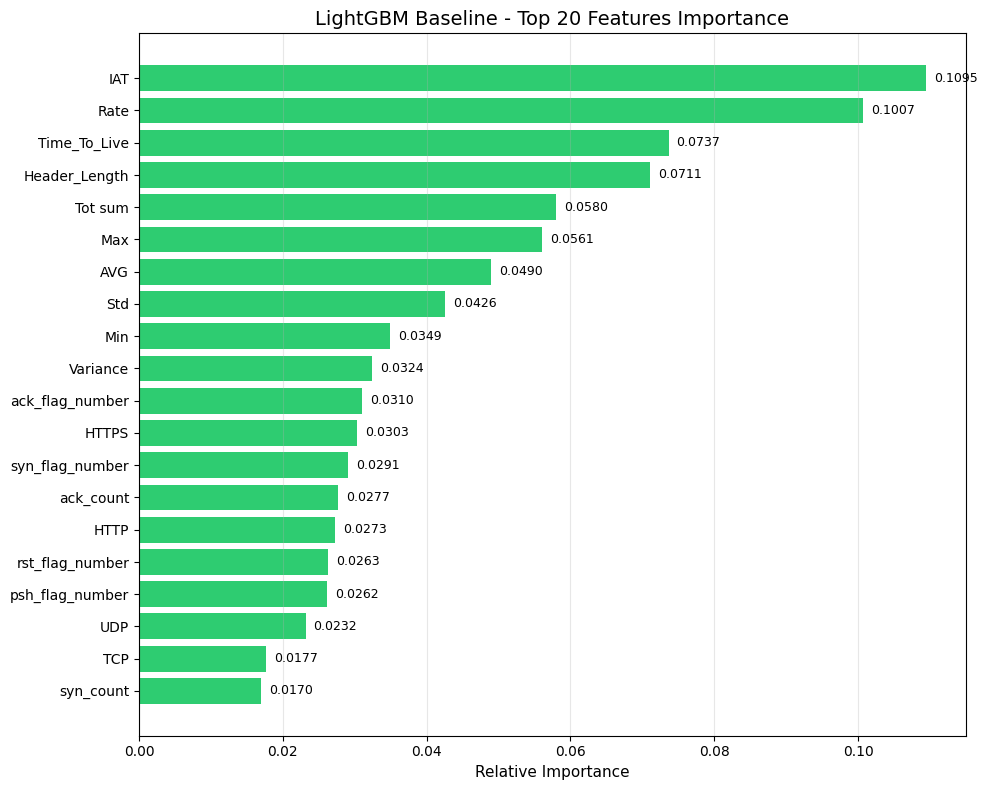

✓ Saved: /content/drive/My Drive/Baseline/Results/feature_importance_lightgbm_baseline.png


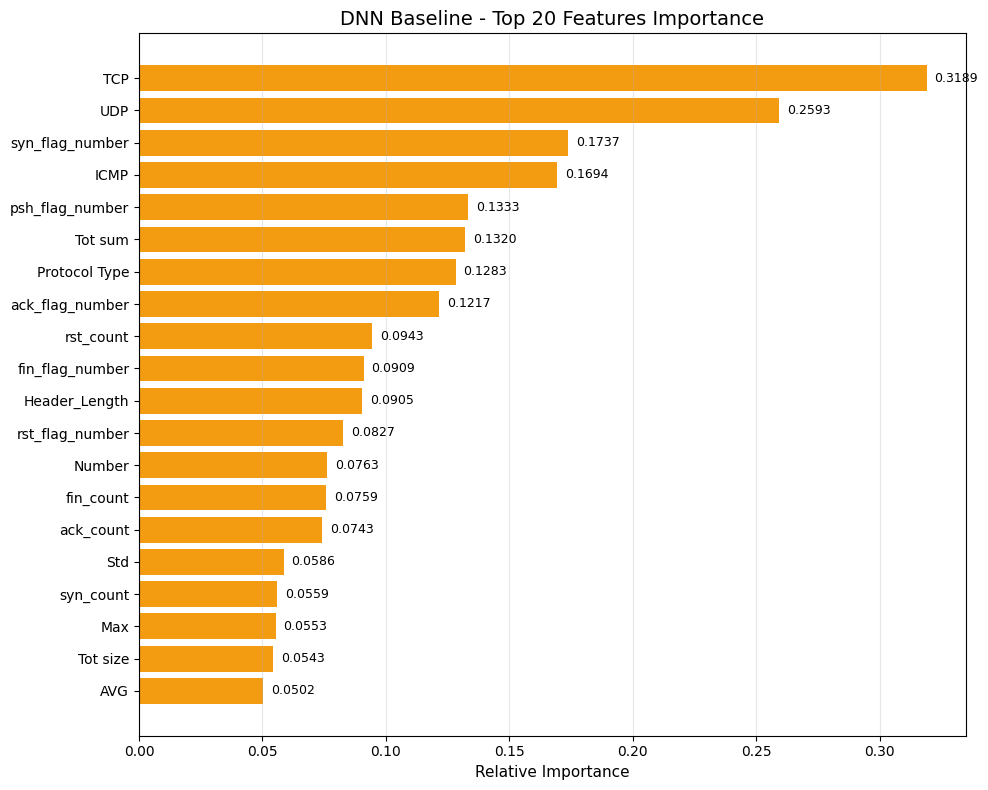

✓ Saved: /content/drive/My Drive/Baseline/Results/feature_importance_dnn_baseline.png

✓ Feature importance visualization saved


In [25]:
# Normalize LightGBM importance to be relative (sum to 1) like RF/XGBoost
# This converts raw 'split counts' to 'relative proportion'
if 'LightGBM' in importance_df.columns:
    print("Normalizing LightGBM feature importance to relative scale (0-1)...")
    importance_df['LightGBM'] = importance_df['LightGBM'] / importance_df['LightGBM'].sum()

print("TOP 20 FEATURES (BY AVERAGE IMPORTANCE)")
print(importance_df[['Feature', 'Average'] + list(feature_importance_dict.keys())].head(20).to_string(index=False))

# === 3.6 Visualisasi Feature Importance (Separate Plots) ===
print("\nGenerating separate Feature Importance plots...")

model_list = list(feature_importance_dict.keys())
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, model_name in enumerate(model_list):
    # Create separate figure for each model
    fig, ax = plt.subplots(figsize=(10, 8))

    # Get top 20 for this model (sorted by its own importance)
    model_importance = importance_df.nlargest(20, model_name)[['Feature', model_name]].sort_values(model_name, ascending=True)

    bars = ax.barh(range(len(model_importance)), model_importance[model_name],
                   color=colors[idx])
    ax.set_yticks(range(len(model_importance)))
    ax.set_yticklabels(model_importance['Feature'], fontsize=10)
    ax.set_xlabel('Relative Importance', fontsize=11)

    # Title: "{Model Name} Baseline - Top 20 Features Importance" (No bold)
    ax.set_title(f'{model_name} Baseline - Top 20 Features Importance', fontsize=14)

    ax.grid(axis='x', alpha=0.3)

    # Add values
    for i, (bar, val) in enumerate(zip(bars, model_importance[model_name])):
        ax.text(val + max(model_importance[model_name])*0.01, i, f'{val:.4f}',
                va='center', fontsize=9)

    plt.tight_layout()
    save_path = os.path.join(RESULTS_DIR, f'feature_importance_{model_name.lower()}_baseline.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")

print("\n✓ Feature importance visualization saved")

###**3.4 Generate Predictions**

In [15]:
predictions = {}

for model_name, model in models.items():
    print(f"Predicting with {model_name}...")

    if model_name == 'DNN':
        y_pred_proba = model.predict(X_test, batch_size=512, verbose=0)
        predictions[model_name] = np.argmax(y_pred_proba, axis=1)
    else:
        predictions[model_name] = model.predict(X_test)

    print(f"   ✓ Done")

Predicting with RF...


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   25.2s finished


   ✓ Done
Predicting with XGBoost...
   ✓ Done
Predicting with LightGBM...


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


   ✓ Done
Predicting with DNN...
   ✓ Done


###**3.5 Confusion Matrix**

Creating separate 34-Class Confusion Matrices...


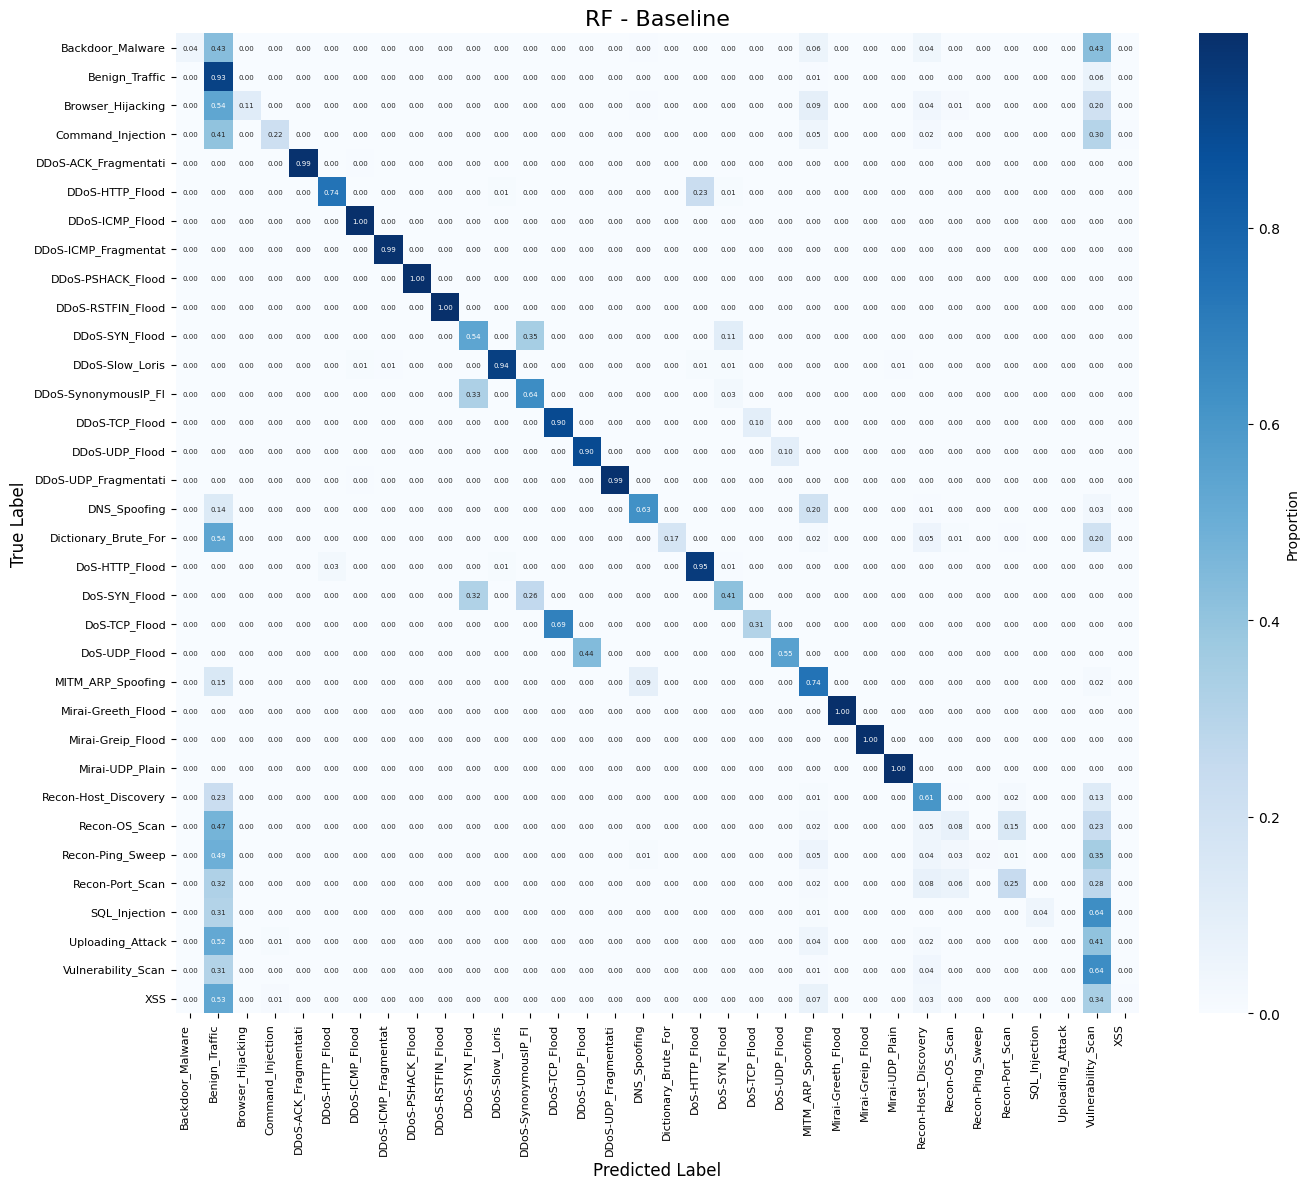

✓ Saved: /content/drive/My Drive/Baseline/Results/cm_34class_rf_baseline.png


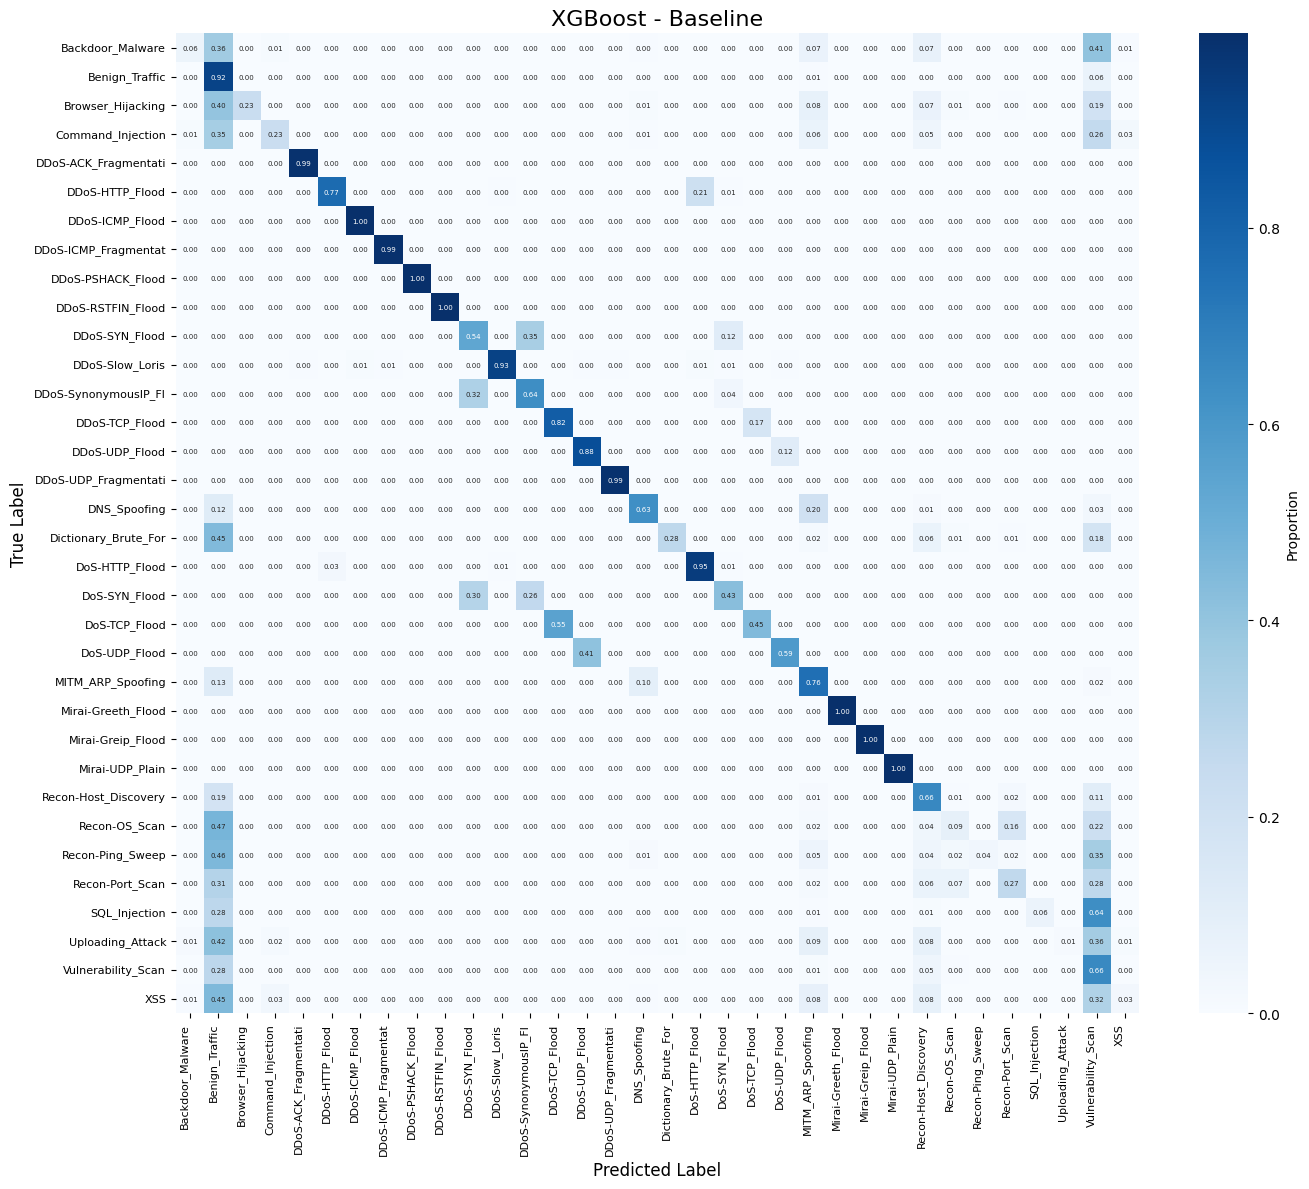

✓ Saved: /content/drive/My Drive/Baseline/Results/cm_34class_xgboost_baseline.png


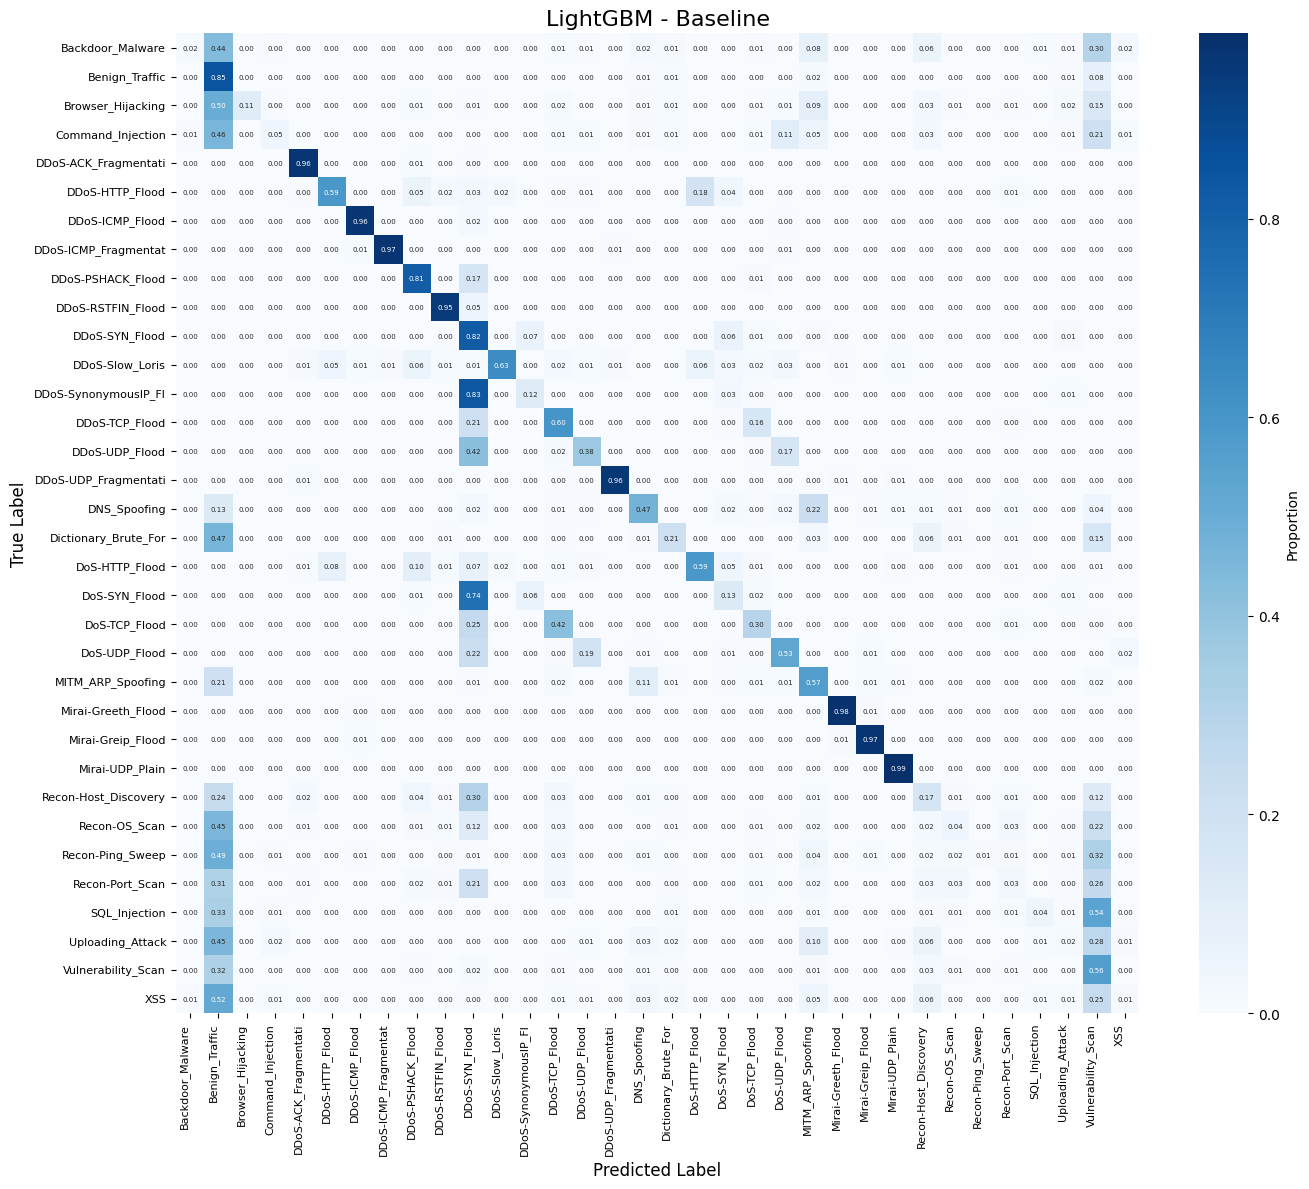

✓ Saved: /content/drive/My Drive/Baseline/Results/cm_34class_lightgbm_baseline.png


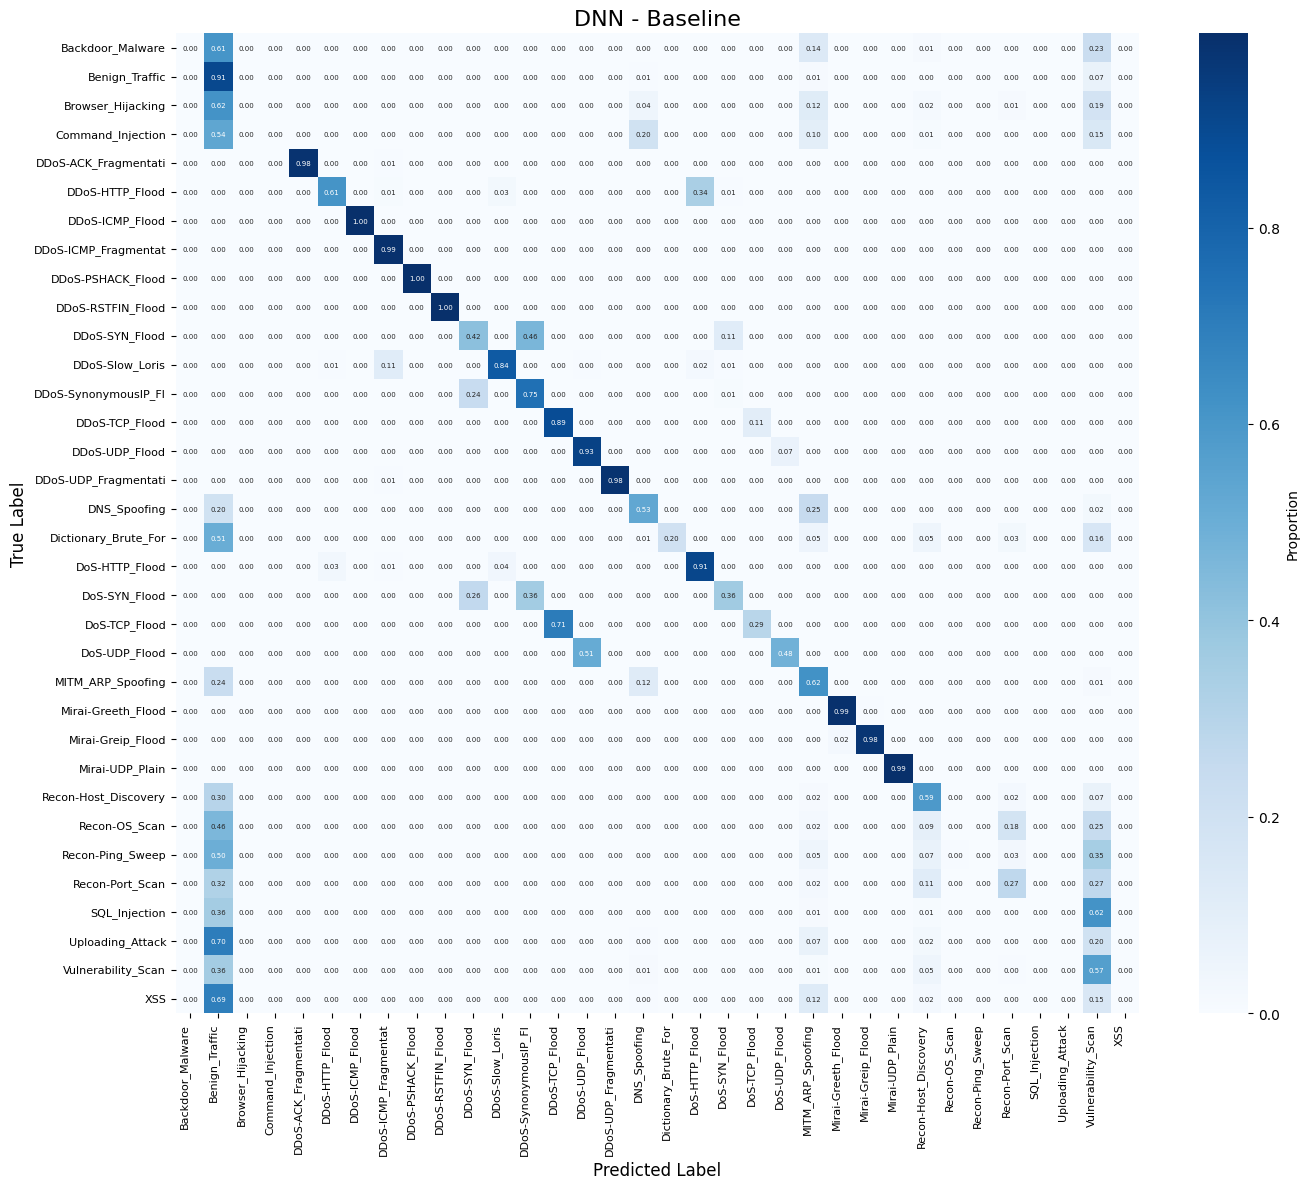

✓ Saved: /content/drive/My Drive/Baseline/Results/cm_34class_dnn_baseline.png
✓ All separate 34-class confusion matrices saved

Membuat Binary Confusion Matrix Terpisah (Negative vs Positive)...


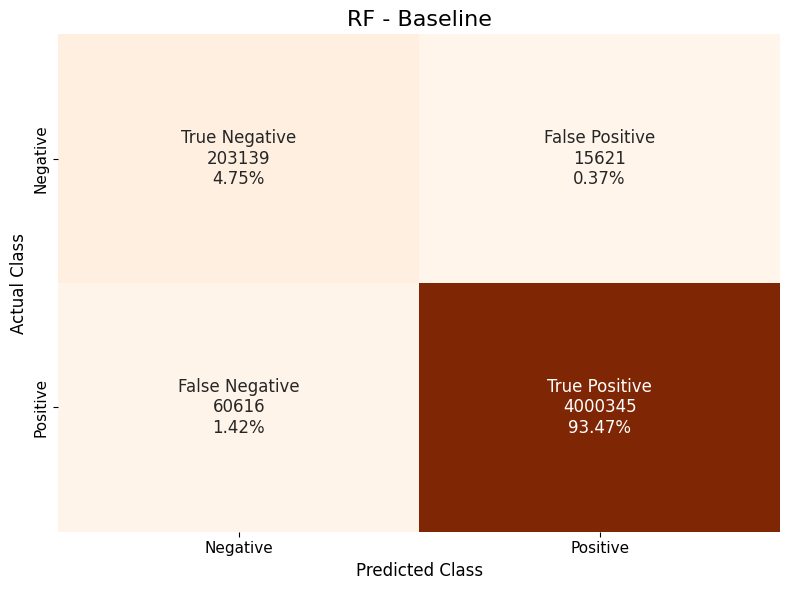

✓ Saved: /content/drive/My Drive/Baseline/Results/binary_cm_rf_baseline.png


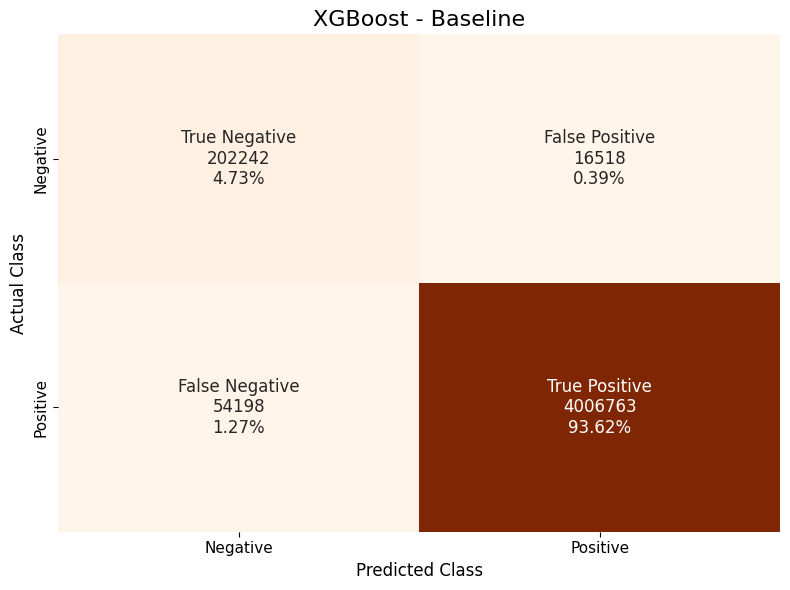

✓ Saved: /content/drive/My Drive/Baseline/Results/binary_cm_xgboost_baseline.png


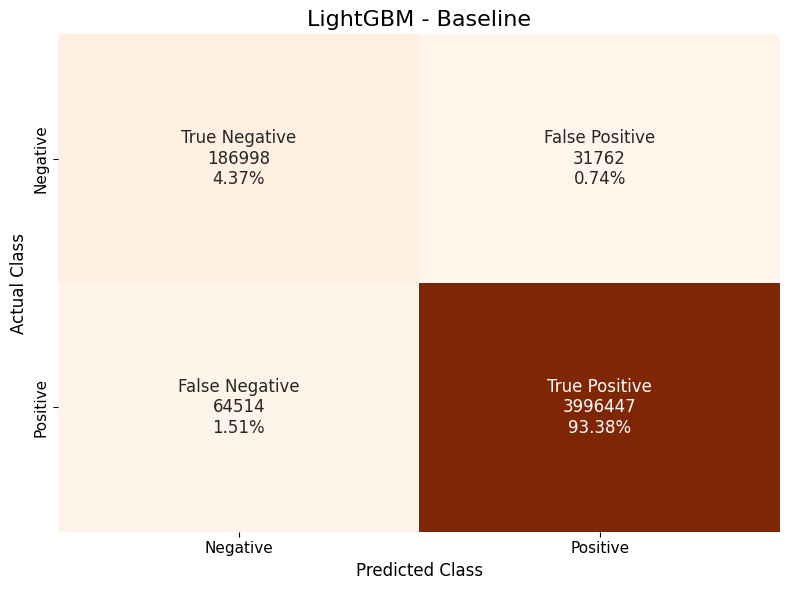

✓ Saved: /content/drive/My Drive/Baseline/Results/binary_cm_lightgbm_baseline.png


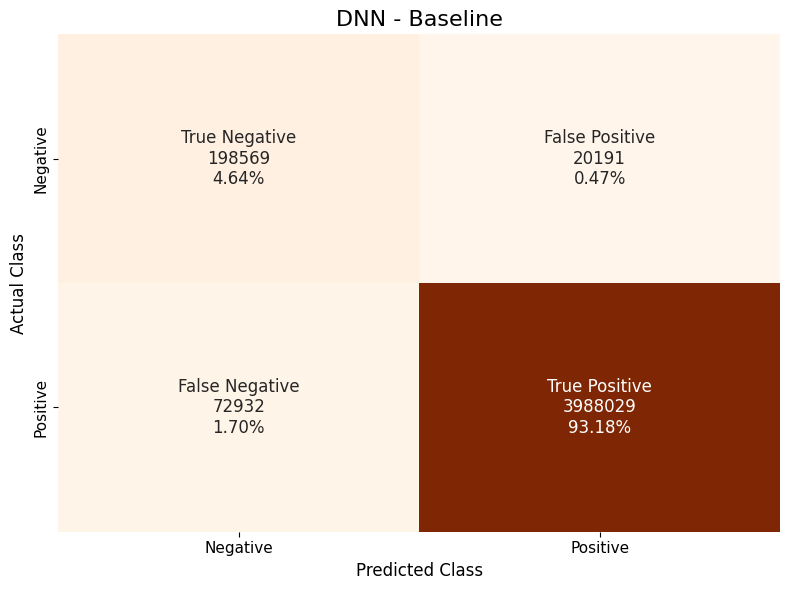

✓ Saved: /content/drive/My Drive/Baseline/Results/binary_cm_dnn_baseline.png
✓ All separate binary confusion matrices saved


In [22]:
# === Part 1: 34-Class Confusion Matrix (Separate Plots) ===
print("Creating separate 34-Class Confusion Matrices...")

model_list = list(predictions.keys())

# Prepare tick labels for all classes
tick_labels = [label_encoder.classes_[i][:20] for i in range(len(label_encoder.classes_))]

for model_name in model_list:
    # Create separate figure for each model
    fig, ax = plt.subplots(figsize=(14, 12)) # Increased size slightly for annotations

    # Compute confusion matrix
    cm = confusion_matrix(y_test, predictions[model_name])

    # Normalize
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot using sns.heatmap for annotations
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                cbar_kws={'label': 'Proportion'}, annot_kws={"size": 5}, # Small font for 34x34 grid
                xticklabels=tick_labels, yticklabels=tick_labels)

    # Title: "{Model Name} - Baseline"
    ax.set_title(f"{model_name} - Baseline", fontsize=16) # No bold

    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)

    # Rotate x-axis labels
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    save_path = os.path.join(RESULTS_DIR, f'cm_34class_{model_name.lower()}_baseline.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")

    # Save raw numpy array
    np.save(os.path.join(RESULTS_DIR, f'cm_{model_name.lower()}_final.npy'), cm)

print("✓ All separate 34-class confusion matrices saved")


# === Part 2: Binary Confusion Matrix (Actual/Predicted Positive/Negative) - TERPISAH ===
print("\nMembuat Binary Confusion Matrix Terpisah (Negative vs Positive)...")

# Identifikasi index kelas 'Benign_Traffic'
if 'Benign_Traffic' in label_encoder.classes_:
    benign_idx = np.where(label_encoder.classes_ == 'Benign_Traffic')[0][0]
else:
    benign_idx = 1 # Fallback asumsi

# Fungsi konversi ke Binary (0: Negative, 1: Positive)
def get_binary_labels(y_data, benign_idx):
    # Jika label == benign_idx -> 0 (Negative)
    # Jika label != benign_idx -> 1 (Positive)
    return (y_data != benign_idx).astype(int)

y_test_bin = get_binary_labels(y_test, benign_idx)

labels_binary = ['Negative', 'Positive']

for model_name in model_list:
    # Create separate figure for each model
    fig, ax = plt.subplots(figsize=(8, 6))

    # Convert predictions to binary
    y_pred_bin = get_binary_labels(predictions[model_name], benign_idx)

    # Compute Confusion Matrix
    cm_bin = confusion_matrix(y_test_bin, y_pred_bin)

    # Extract TN, FP, FN, TP
    tn, fp, fn, tp = cm_bin.ravel()

    # Annotations
    group_names = ['True Negative', 'False Positive',
                   'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cm_bin.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm_bin.flatten()/np.sum(cm_bin)]

    box_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(2,2)

    sns.heatmap(cm_bin, annot=box_labels, fmt='', cmap='Oranges', ax=ax,
                cbar=False, annot_kws={"fontsize":12})

    # Title: "{Model Name} - Baseline"
    ax.set_title(f"{model_name} - Baseline", fontsize=16)

    ax.set_xlabel('Predicted Class', fontsize=12)
    ax.set_ylabel('Actual Class', fontsize=12)
    ax.set_xticklabels(labels_binary, fontsize=11)
    ax.set_yticklabels(labels_binary, fontsize=11)

    plt.tight_layout()
    save_path = os.path.join(RESULTS_DIR, f'binary_cm_{model_name.lower()}_baseline.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {save_path}")

print("✓ All separate binary confusion matrices saved")

###**3.6 Comprehensive Metrics (Macro + Micro)**

In [26]:
comprehensive_results = []

for model_name, y_pred in predictions.items():

    # Basic metrics
    acc = accuracy_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)

    # Macro metrics
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # Micro metrics
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)

    # Weighted metrics
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    comprehensive_results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision_Macro': precision_macro,
        'Recall_Macro': recall_macro,
        'F1_Macro': f1_macro,
        'Precision_Micro': precision_micro,
        'Recall_Micro': recall_micro,
        'F1_Micro': f1_micro,
        'Precision_Weighted': precision_weighted,
        'Recall_Weighted': recall_weighted,
        'F1_Weighted': f1_weighted,
        'MCC': mcc
    })

comprehensive_df = pd.DataFrame(comprehensive_results)

print("\n" + "="*60)
print("COMPREHENSIVE METRICS COMPARISON")
print("="*60)
print("\n", comprehensive_df.to_string(index=False))

# Simpan
comprehensive_df.to_csv(os.path.join(RESULTS_DIR, 'comprehensive_metrics_4models.csv'), index=False)


COMPREHENSIVE METRICS COMPARISON

    Model  Accuracy  Precision_Macro  Recall_Macro  F1_Macro  Precision_Micro  Recall_Micro  F1_Micro  Precision_Weighted  Recall_Weighted  F1_Weighted      MCC
      RF  0.790305         0.784656      0.597447  0.613031         0.790305      0.790305  0.790305            0.798838         0.790305     0.781174 0.777607
 XGBoost  0.794322         0.766014      0.614035  0.635044         0.794322      0.794322  0.794322            0.798912         0.794322     0.789097 0.781286
LightGBM  0.658434         0.526820      0.482959  0.488006         0.658434      0.658434  0.658434            0.714512         0.658434     0.657005 0.647723
     DNN  0.772087         0.610397      0.561600  0.563067         0.772087      0.772087  0.772087            0.784321         0.772087     0.759376 0.759464


###**3.7 Visualisasi Metrics Comparison**

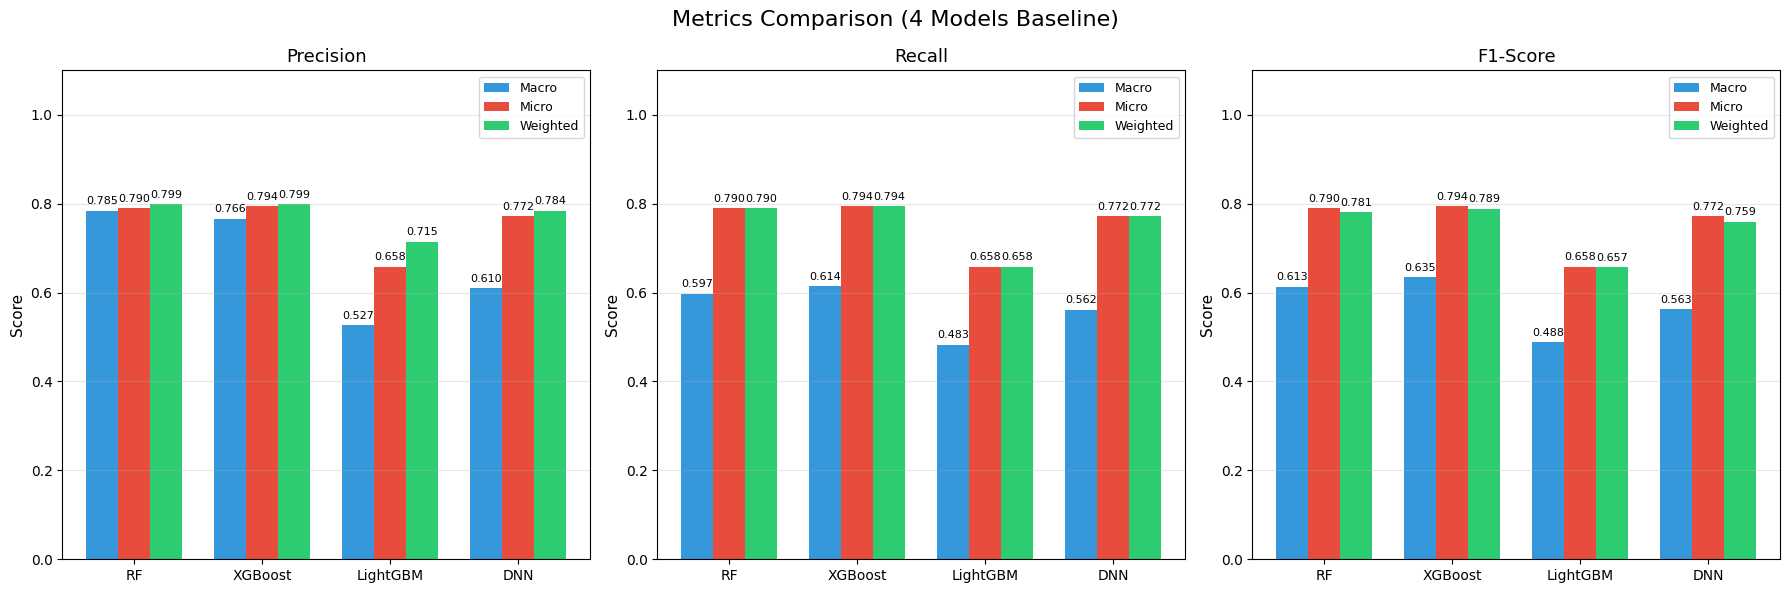

✓ Metrics comparison saved


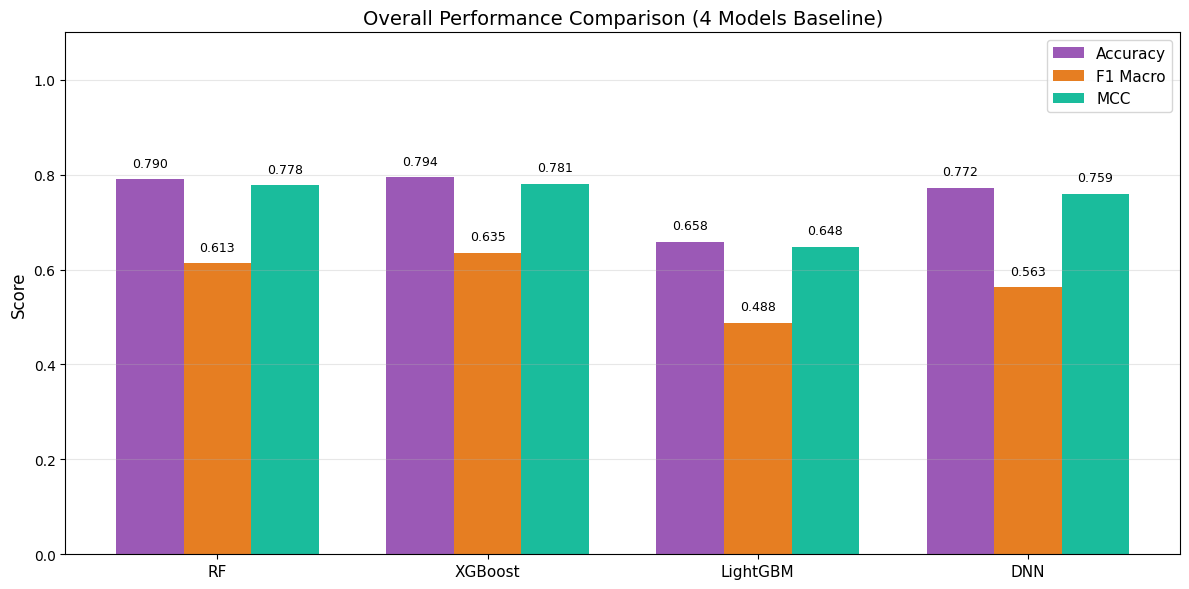

✓ Overall performance saved


In [29]:
# Plot 1: Macro vs Micro vs Weighted
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Metrics Comparison (4 Models Baseline)', fontsize=16) # Removed bold

metrics_groups = [
    (['Precision_Macro', 'Precision_Micro', 'Precision_Weighted'], 'Precision'),
    (['Recall_Macro', 'Recall_Micro', 'Recall_Weighted'], 'Recall'),
    (['F1_Macro', 'F1_Micro', 'F1_Weighted'], 'F1-Score')
]

colors_bar = ['#3498db', '#e74c3c', '#2ecc71']
x_pos = np.arange(len(model_list))
width = 0.25

for ax_idx, (metrics, title) in enumerate(metrics_groups):
    ax = axes[ax_idx]

    for i, metric in enumerate(metrics):
        values = comprehensive_df[metric].values
        offset = (i - 1) * width
        bars = ax.bar(x_pos + offset, values, width,
                      label=metric.split('_')[1], color=colors_bar[i])

        # Add values on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(title, fontsize=13) # Removed bold
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_list, fontsize=10)
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'metrics_comparison_macro_micro_weighted.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Metrics comparison saved")

# Plot 2: Overall Performance (Accuracy + MCC + F1-Macro)
fig, ax = plt.subplots(figsize=(12, 6))

metrics_overall = ['Accuracy', 'F1_Macro', 'MCC']
x_pos = np.arange(len(model_list))
width = 0.25
colors_overall = ['#9b59b6', '#e67e22', '#1abc9c']

for i, metric in enumerate(metrics_overall):
    values = comprehensive_df[metric].values
    offset = (i - 1) * width
    bars = ax.bar(x_pos + offset, values, width,
                  label=metric.replace('_', ' '), color=colors_overall[i])

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9) # Removed bold

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Overall Performance Comparison (4 Models Baseline)', fontsize=14) # Removed bold
ax.set_xticks(x_pos)
ax.set_xticklabels(model_list, fontsize=11)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'overall_performance_4models.png'),
            dpi=300, bbox_inches='tight')
plt.show()

print("✓ Overall performance saved")

###**3.8 Ranking Models**

In [30]:
# Rank berdasarkan F1-Macro (metrik utama untuk imbalanced data)
ranking = comprehensive_df.sort_values('F1_Macro', ascending=False)

print("Ranking berdasarkan F1-Score (Macro):")
for rank, (idx, row) in enumerate(ranking.iterrows(), 1):
    print(f"{rank}. {row['Model']}: {row['F1_Macro']:.4f}")

best_model = ranking.iloc[0]['Model']
print(f"\n✓ Best Model: {best_model}")

Ranking berdasarkan F1-Score (Macro):
1. XGBoost: 0.6350
2. RF: 0.6130
3. DNN: 0.5631
4. LightGBM: 0.4880

✓ Best Model: XGBoost


###**3.9 Summary Report**


In [31]:
summary_report = {
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'best_model': best_model,
    'best_f1_macro': float(ranking.iloc[0]['F1_Macro']),
    'models_evaluated': model_list,
    'metrics': {
        'Accuracy': {m: float(comprehensive_df[comprehensive_df['Model']==m]['Accuracy'].values[0])
                    for m in model_list},
        'F1_Macro': {m: float(comprehensive_df[comprehensive_df['Model']==m]['F1_Macro'].values[0])
                    for m in model_list},
        'F1_Micro': {m: float(comprehensive_df[comprehensive_df['Model']==m]['F1_Micro'].values[0])
                    for m in model_list},
        'MCC': {m: float(comprehensive_df[comprehensive_df['Model']==m]['MCC'].values[0])
               for m in model_list}
    }
}

with open(os.path.join(RESULTS_DIR, 'phase3_summary_report.json'), 'w') as f:
    json.dump(summary_report, f, indent=4)

print("\nSummary report tersimpan!")

print("\n" + "="*60)
print("LANGKAH 3 COMPLETE REVISION SELESAI!")
print("="*60)

print(f"\n✓ Feature Importance (4 models) analyzed")
print(f"✓ Confusion Matrices created")
print(f"✓ Comprehensive Metrics (Macro/Micro/Weighted) computed")
print(f"✓ Best Model: {best_model} (F1-Macro: {ranking.iloc[0]['F1_Macro']:.4f})")

print(f"\nFiles tersimpan di:")
print(f"  {EDA_DIR}")
print(f"    - feature_importance_4models.csv")
print(f"  {RESULTS_DIR}")
print(f"    - feature_importance_4models.png")
print(f"    - confusion_matrices_4models_figs_style.png")
print(f"    - comprehensive_metrics_4models.csv")
print(f"    - metrics_comparison_macro_micro_weighted.png")
print(f"    - overall_performance_4models.png")
print(f"    - phase3_summary_report.json")


Summary report tersimpan!

LANGKAH 3 COMPLETE REVISION SELESAI!

✓ Feature Importance (4 models) analyzed
✓ Confusion Matrices created
✓ Comprehensive Metrics (Macro/Micro/Weighted) computed
✓ Best Model: XGBoost (F1-Macro: 0.6350)

Files tersimpan di:
  /content/drive/My Drive/EDA_Results/
    - feature_importance_4models.csv
  /content/drive/My Drive/Baseline/Results/
    - feature_importance_4models.png
    - confusion_matrices_4models_figs_style.png
    - comprehensive_metrics_4models.csv
    - metrics_comparison_macro_micro_weighted.png
    - overall_performance_4models.png
    - phase3_summary_report.json
